In [1]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import sklearn
import sklearn.mixture
from collections import defaultdict
from scipy import stats
import seaborn as sns
from statannotations import Annotator
import pathlib
plt.rcParams['figure.figsize'] = [20, 10]

Global seed set to 0
/home/x_mamin/.conda/envs/lilliput_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/x_mamin/.conda/envs/lilliput_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
scvi.__version__

'0.19.0'

In [3]:
adata = sc.read_h5ad("IRF1.h5ad")

In [4]:
adata = adata[adata.obs["Lenti"] == "Pooled"]

In [5]:
print(adata.X.shape)
print(adata.obs.keys())
print(adata.var.keys())

(8064, 20387)
Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'IRF1',
       'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nFeature_GDO', 'HTO_maxID',
       'HTO_secondID', 'HTO_margin', 'HTO_classification',
       'HTO_classification.global', 'hash.ID', 'GDO_maxID', 'GDO_secondID',
       'GDO_margin', 'GDO_classification', 'GDO_classification.global',
       'Perturbed', 'NT', 'gene', 'Time', 'barcode', 'Lenti'],
      dtype='object')
Index(['features'], dtype='object')


In [6]:
len(adata.var["features"])

20387

In [7]:
adata.obs["Time"] = [float(i[:-2]) for i in adata.obs["Time"]]
pd.unique(adata.obs["Time"])

/tmp/ipykernel_3387728/1573652415.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Time"] = [float(i[:-2]) for i in adata.obs["Time"]]
/home/x_mamin/.conda/envs/lilliput_env/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


array([6. , 0. , 1.5, 3. ])

In [8]:
adata.layers["counts"] = adata.X.copy()

## Score cell cycle

In [9]:
cell_phase_genes = defaultdict(list)
cell_phase_genes['G1-S'] = ['ARGLU1', 'BRD7', 'CDC6', 'CLSPN', 'ESD', 'GINS2',
                                          'GMNN', 'LUC7L3', 'MCM5', 'MCM6', 'NASP', 'PCNA',
                                          'PNN', 'SLBP', 'SRSF7', 'SSR3', 'ZRANB2']
cell_phase_genes['S'] = ['ASF1B', 'CALM2', 'CDC45', 'CDCA5', 'CENPM', 'DHFR',
                                        'EZH2', 'FEN1', 'HIST1H2AC', 'HIST1H4C', 'NEAT1',
                                        'PKMYT1', 'PRIM1', 'RFC2', 'RPA2', 'RRM2', 'RSRC2',
                                        'SRSF5', 'SVIP', 'TOP2A', 'TYMS', 'UBE2T', 'ZWINT']
cell_phase_genes['G2-M'] = ['AURKB', 'BUB3', 'CCNA2', 'CCNF', 'CDCA2', 'CDCA3',
                                           'CDCA8', 'CDK1', 'CKAP2', 'DCAF7', 'HMGB2', 'HN1',
                                           'KIF5B', 'KIF20B', 'KIF22', 'KIF23', 'KIFC1', 'KPNA2',
                                           'LBR', 'MAD2L1', 'MALAT1', 'MND1', 'NDC80', 'NUCKS1',
                                           'NUSAP1', 'PIF1', 'PSMD11', 'PSRC1', 'SMC4', 'TIMP1',
                                           'TMEM99', 'TOP2A', 'TUBB', 'TUBB4B', 'VPS25']
cell_phase_genes['M'] = ['ANP32B', 'ANP32E', 'ARL6IP1', 'AURKA', 'BIRC5', 'BUB1',
                                        'CCNA2', 'CCNB2', 'CDC20', 'CDC27', 'CDC42EP1', 'CDCA3',
                                        'CENPA', 'CENPE', 'CENPF', 'CKAP2', 'CKAP5', 'CKS1B',
                                        'CKS2', 'DEPDC1', 'DLGAP5', 'DNAJA1', 'DNAJB1', 'GRK6',
                                        'GTSE1', 'HMG20B', 'HMGB3', 'HMMR', 'HN1', 'HSPA8',
                                        'KIF2C', 'KIF5B', 'KIF20B', 'LBR', 'MKI67', 'MZT1',
                                        'NUF2', 'NUSAP1', 'PBK', 'PLK1', 'PRR11', 'PSMG3', 'PWP1',
                                        'RAD51C', 'RBM8A', 'RNF126', 'RNPS1', 'RRP1', 'SFPQ',
                                        'SGOL2', 'SMARCB1', 'SRSF3', 'TACC3', 'THRAP3', 'TPX2',
                                        'TUBB4B', 'UBE2D3', 'USP16', 'WIBG', 'YWHAH', 'ZNF207']
cell_phase_genes['M-G1'] = ['AMD1', 'ANP32E', 'CBX3', 'CDC42', 'CNIH4', 'CWC15',
                                           'DKC1', 'DNAJB6', 'DYNLL1', 'EIF4E', 'FXR1', 'GRPEL1',
                                           'GSPT1', 'HMG20B', 'HSPA8', 'ILF2', 'KIF5B', 'KPNB1',
                                           'LARP1', 'LYAR', 'MORF4L2', 'MRPL19', 'MRPS2', 'MRPS18B',
                                           'NUCKS1', 'PRC1', 'PTMS', 'PTTG1', 'RAN', 'RHEB', 'RPL13A',
                                           'SRSF3', 'SYNCRIP', 'TAF9', 'TMEM138', 'TOP1', 'TROAP',
                                           'UBE2D3', 'ZNF593']

In [10]:
adata.var_names = adata.var["features"]

In [11]:
sc.tl.score_genes_cell_cycle(adata=adata, s_genes=cell_phase_genes["S"], g2m_genes=cell_phase_genes["G2-M"], 
                             copy=False, use_raw=False)

/home/x_mamin/.conda/envs/lilliput_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/x_mamin/.conda/envs/lilliput_env/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


### Normalizing data

In [12]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

In [19]:
mean_row = np.mean(adata.X, axis=0)
adata.X = adata.X - mean_row

In [47]:
adata.var["features"][adata.var["features"].str.startswith("IFI")]

features
IFI6          IFI6
IFI44L      IFI44L
IFI44        IFI44
IFI16        IFI16
IFIH1        IFIH1
IFITM2      IFITM2
IFITM1      IFITM1
IFITM3      IFITM3
IFITM10    IFITM10
IFIT2        IFIT2
IFIT3        IFIT3
IFIT1        IFIT1
IFIT5        IFIT5
IFI27L1    IFI27L1
IFI27        IFI27
IFI27L2    IFI27L2
IFI35        IFI35
IFI30        IFI30
Name: features, dtype: object

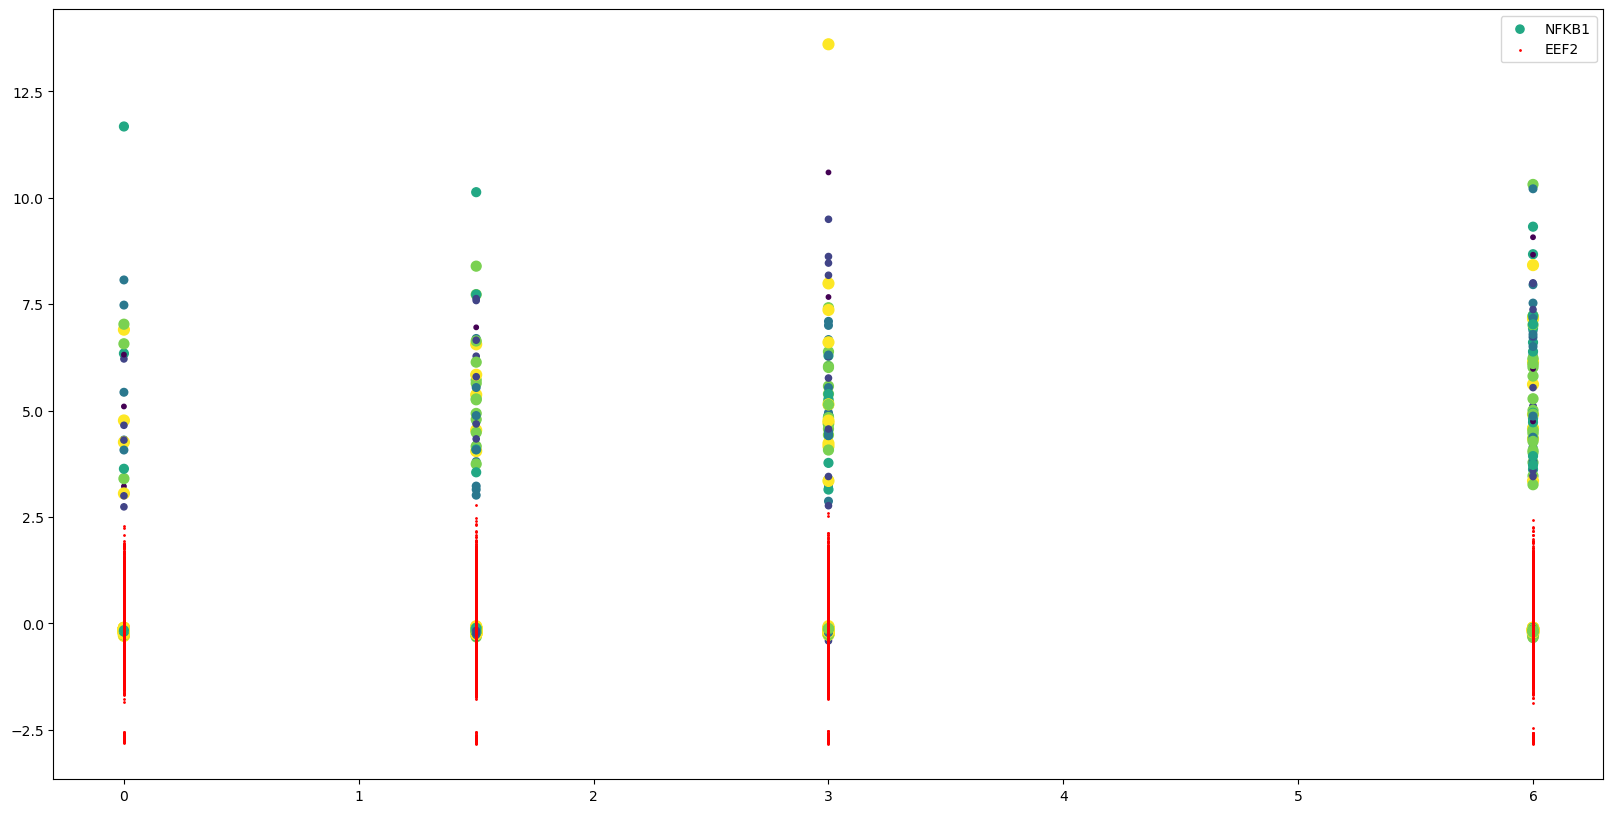

In [50]:
color_dict = {'IRF1-enhancer-2': 1, 'IRF1-enhancer-3': 2, 'IRF1-enhancer-4': 3, 'IRF1-enhancer-M': 4, 'IRF1-promoter': 5, 'NT': 6}
plt.scatter(adata.obs["Time"], adata[#adata.obs["NT"] == "NT", 
                                                              :, adata.var["features"] == "IRF9"].X, c=[color_dict[i] for i in adata.obs["NT"].values], 
            s=[color_dict[i]*10 for i in adata.obs["NT"].values])
plt.scatter(adata.obs["Time"], adata[#adata.obs["NT"] == "NT", 
                                                              :, adata.var["features"] == "EEF2"].X, s=1, c="red")
plt.legend(["IRF9", "EEF2"])

### scvi-tools normalization + imputation

In [12]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    #categorical_covariate_keys=["Lenti"],
    continuous_covariate_keys=["percent.mt", "S_score", "G2M_score"]
)

In [13]:
if not pathlib.Path.cwd().joinpath("my_model_pooled").exists():
    model = scvi.model.SCVI(adata)
    model.train()
    model.save("my_model_pooled/")
else:
    model = scvi.model.SCVI.load("my_model_pooled/", adata=adata, use_gpu=True)

INFO     File my_model_pooled/model.pt already downloaded                                    


In [14]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [15]:
 adata.layers["scvi_normalized"]= model.get_normalized_expression(adata)


In [16]:
mean_row = np.mean(adata.layers["scvi_normalized"], axis=0)
adata.layers["scvi_normalized"] = adata.layers["scvi_normalized"] - mean_row

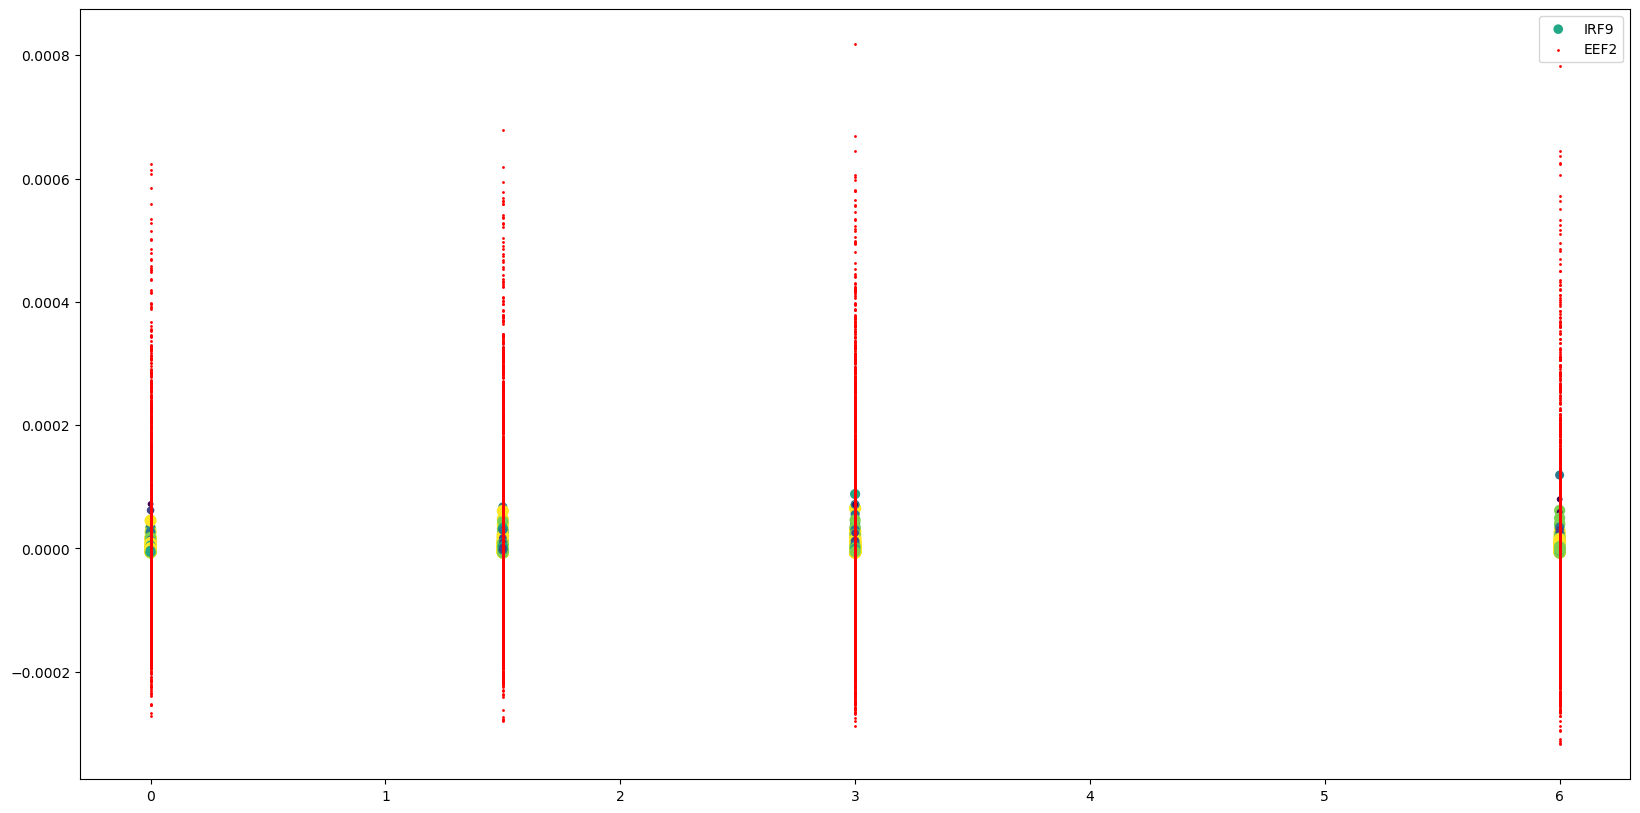

In [17]:
color_dict = {'IRF1-enhancer-2': 1, 'IRF1-enhancer-3': 2, 'IRF1-enhancer-4': 3, 'IRF1-enhancer-M': 4, 'IRF1-promoter': 5, 'NT': 6}
plt.scatter(adata.obs["Time"], adata[:, adata.var["features"] == "IRF9"].layers["scvi_normalized"], c=[color_dict[i] for i in adata.obs["NT"].values], 
            s=[color_dict[i]*10 for i in adata.obs["NT"].values])
plt.scatter(adata.obs["Time"], adata[:, adata.var["features"] == "EEF2"].layers["scvi_normalized"], s=1, c="red")
plt.legend(["IRF9", "EEF2"])

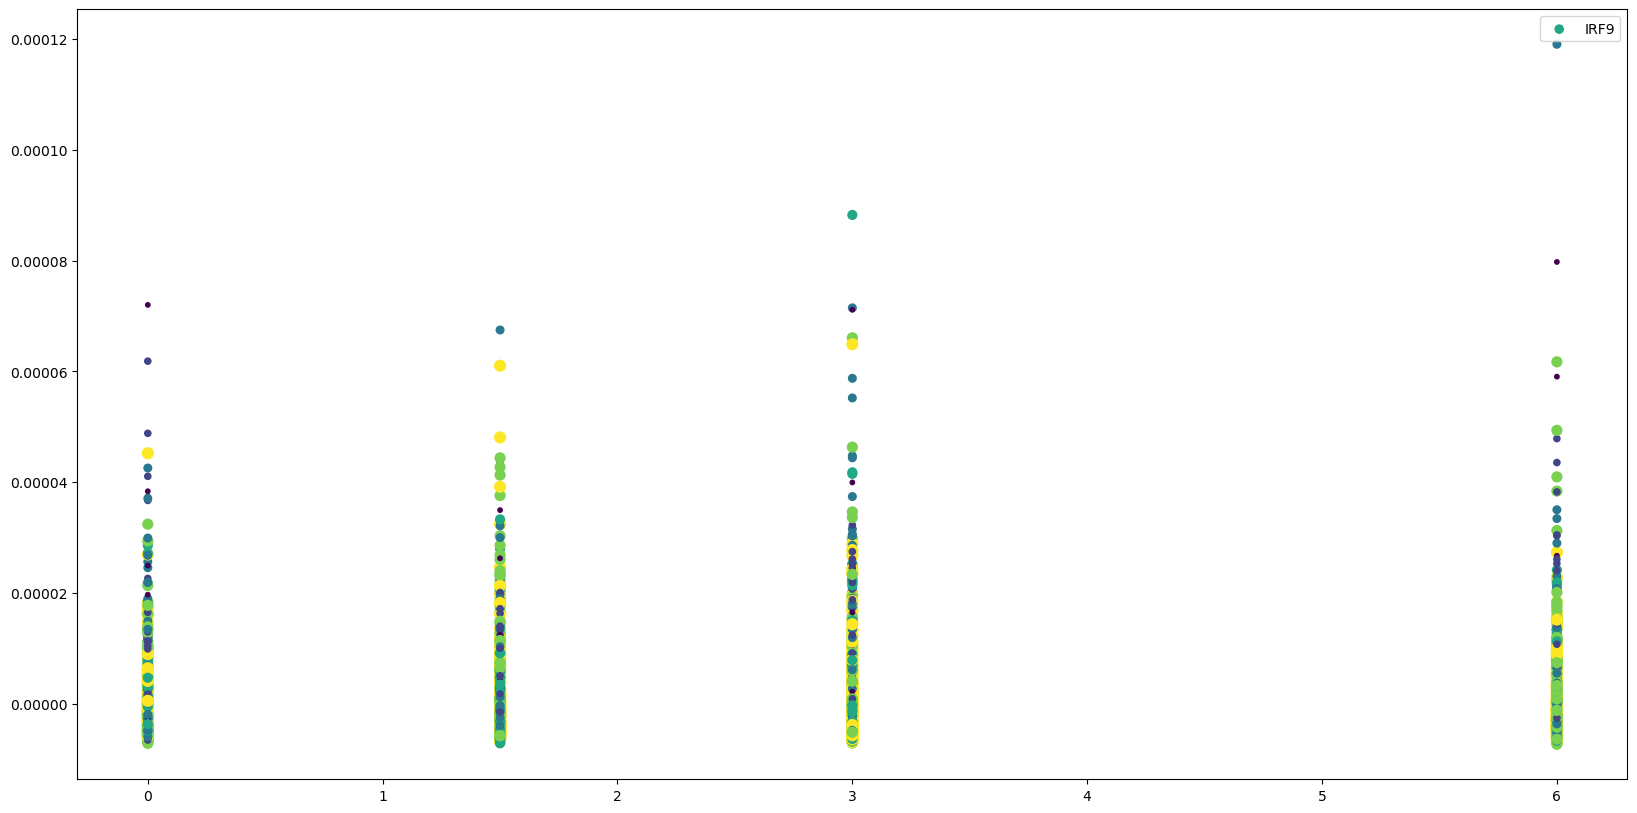

In [18]:
color_dict = {'IRF1-enhancer-2': 1, 'IRF1-enhancer-3': 2, 'IRF1-enhancer-4': 3, 'IRF1-enhancer-M': 4, 'IRF1-promoter': 5, 'NT': 6}
plt.scatter(adata.obs["Time"], adata[:, adata.var["features"] == "IRF9"].layers["scvi_normalized"], c=[color_dict[i] for i in adata.obs["NT"].values], 
            s=[color_dict[i]*10 for i in adata.obs["NT"].values])
#plt.scatter(adata.obs["Time"], adata[:, adata.var["features"] == "EEF2"].layers["scvi_normalized"], s=1, c="red")
plt.legend(["IRF9", "EEF2"])

# Data exploration

In [59]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [60]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

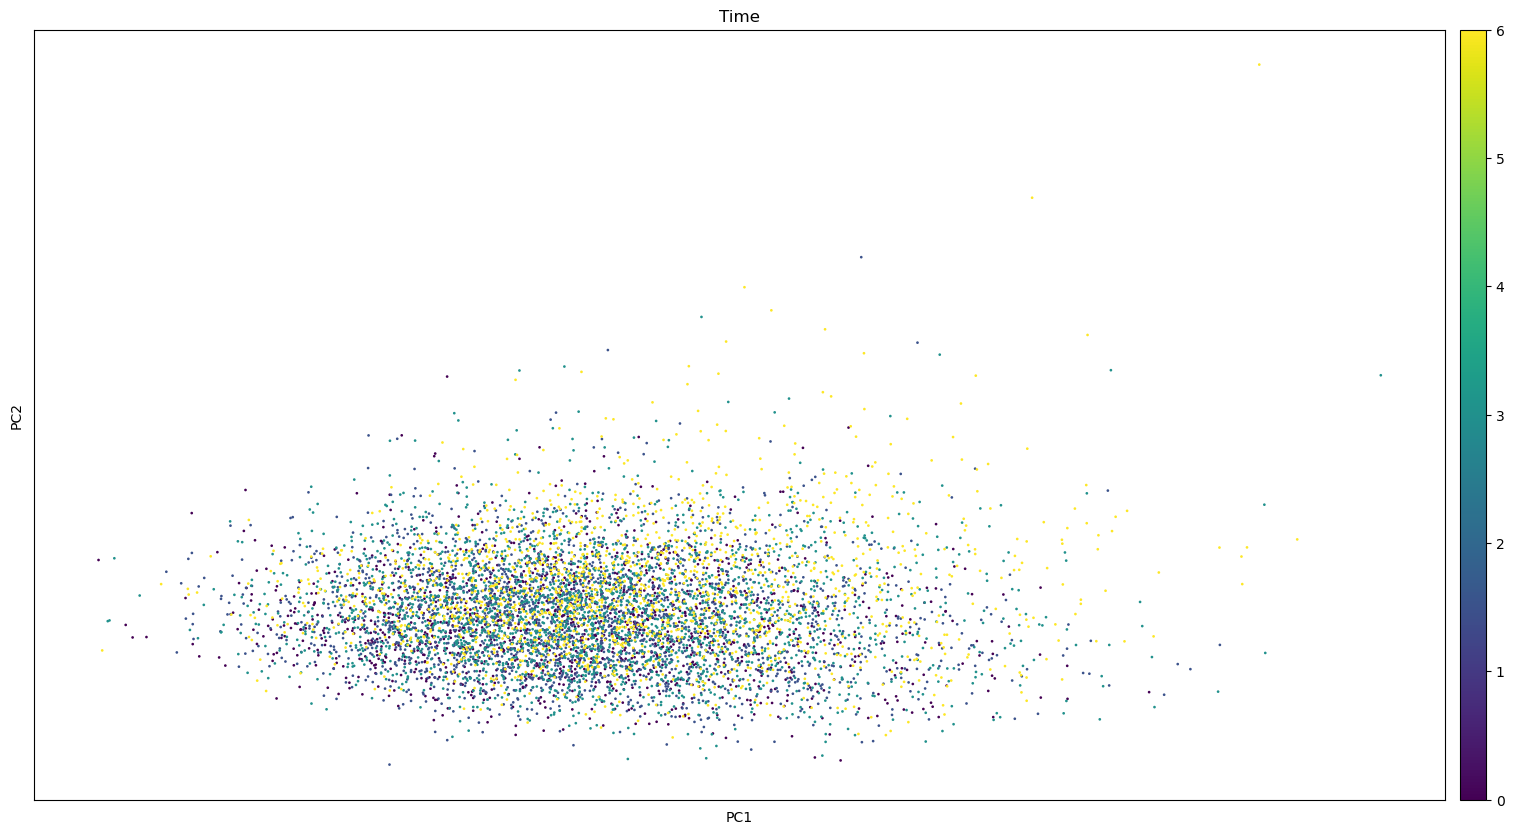

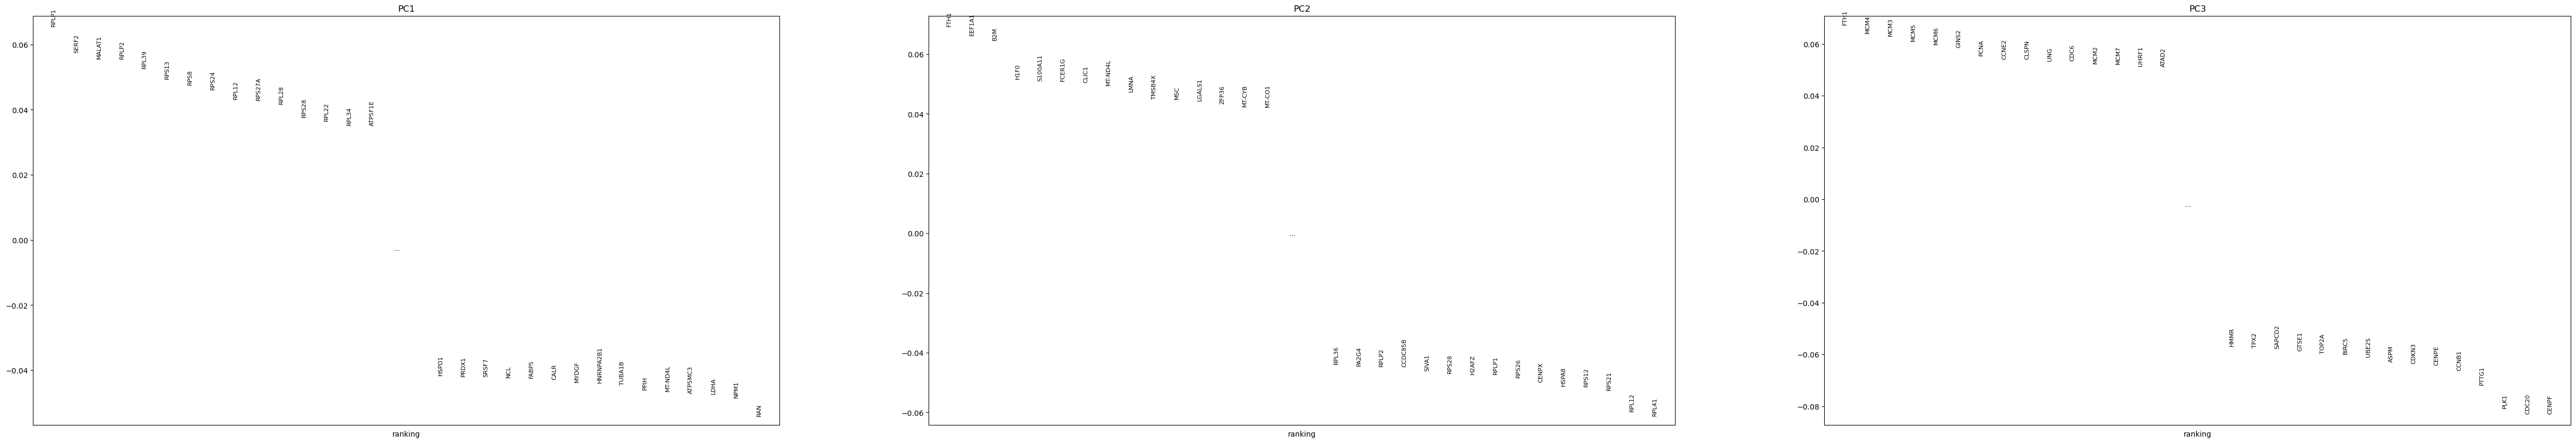

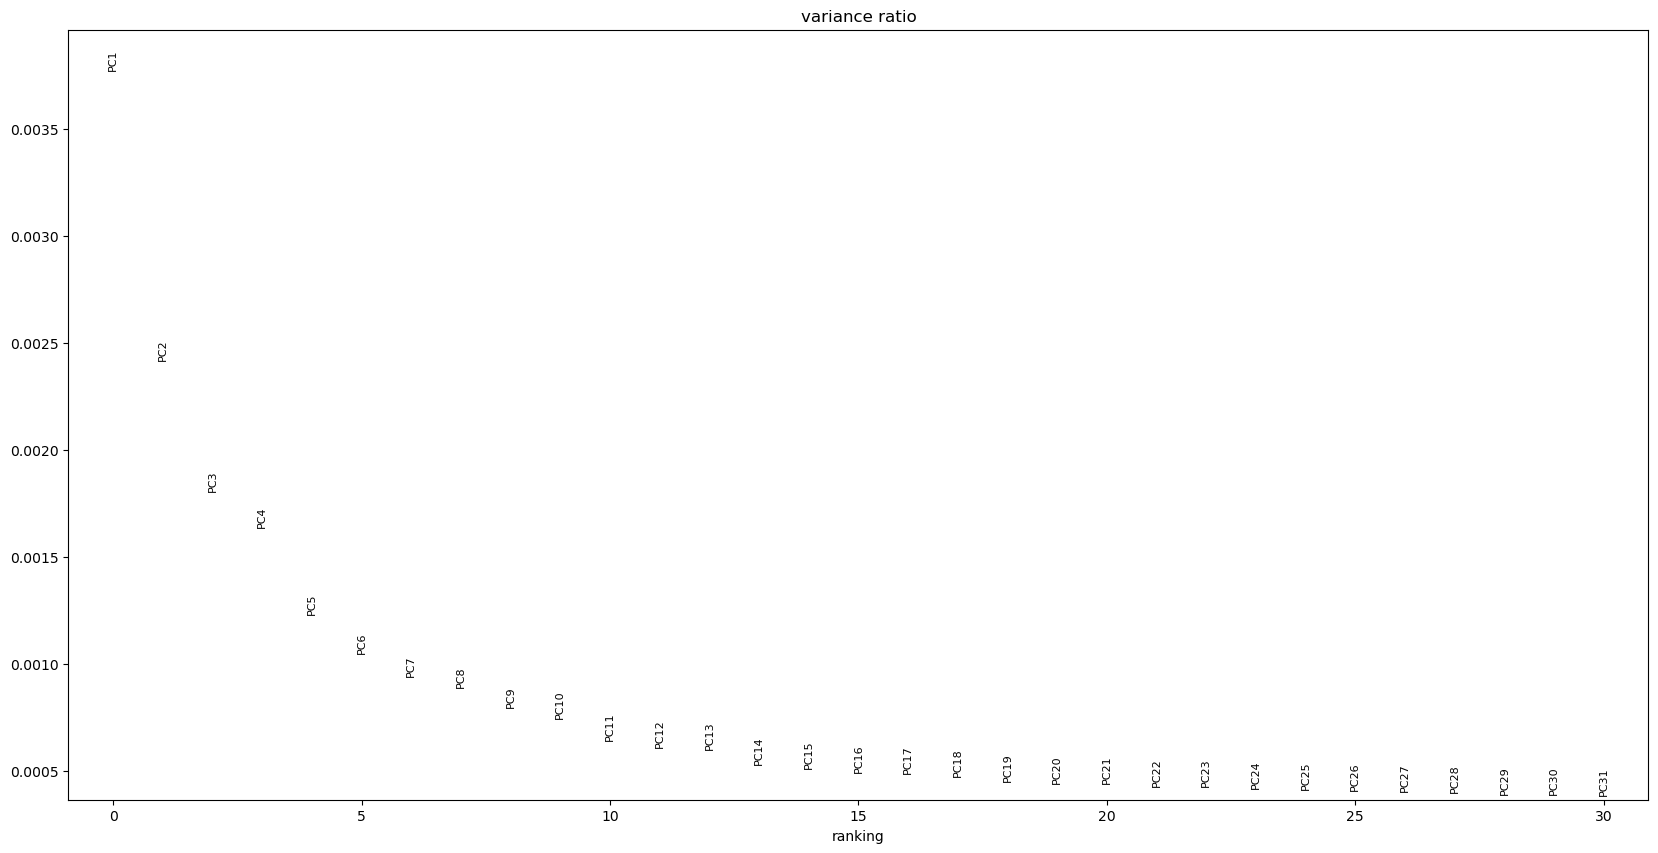

In [61]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca_overview(adata, color="Time")

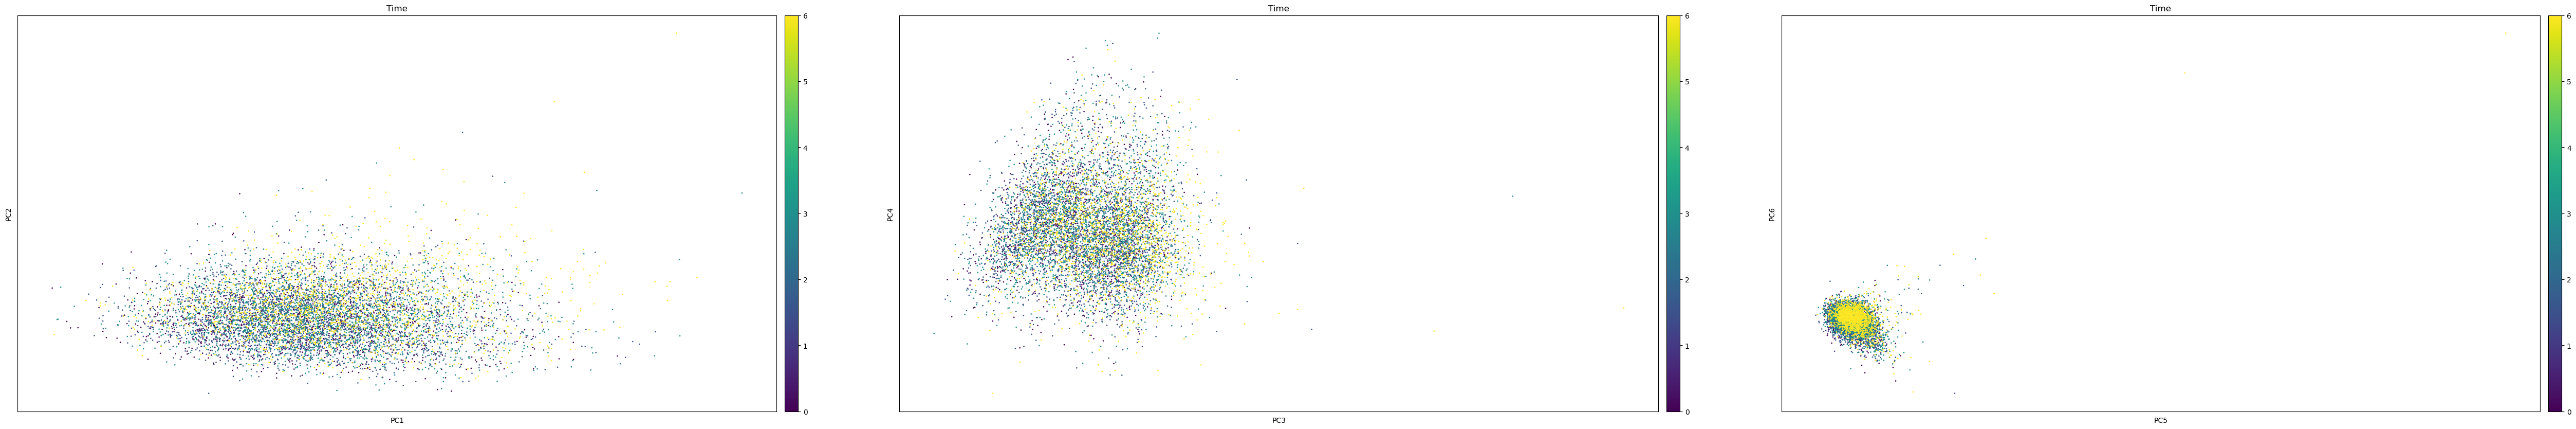

In [62]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca(adata, color="Time", components=["1,2", "3,4", "5,6"])

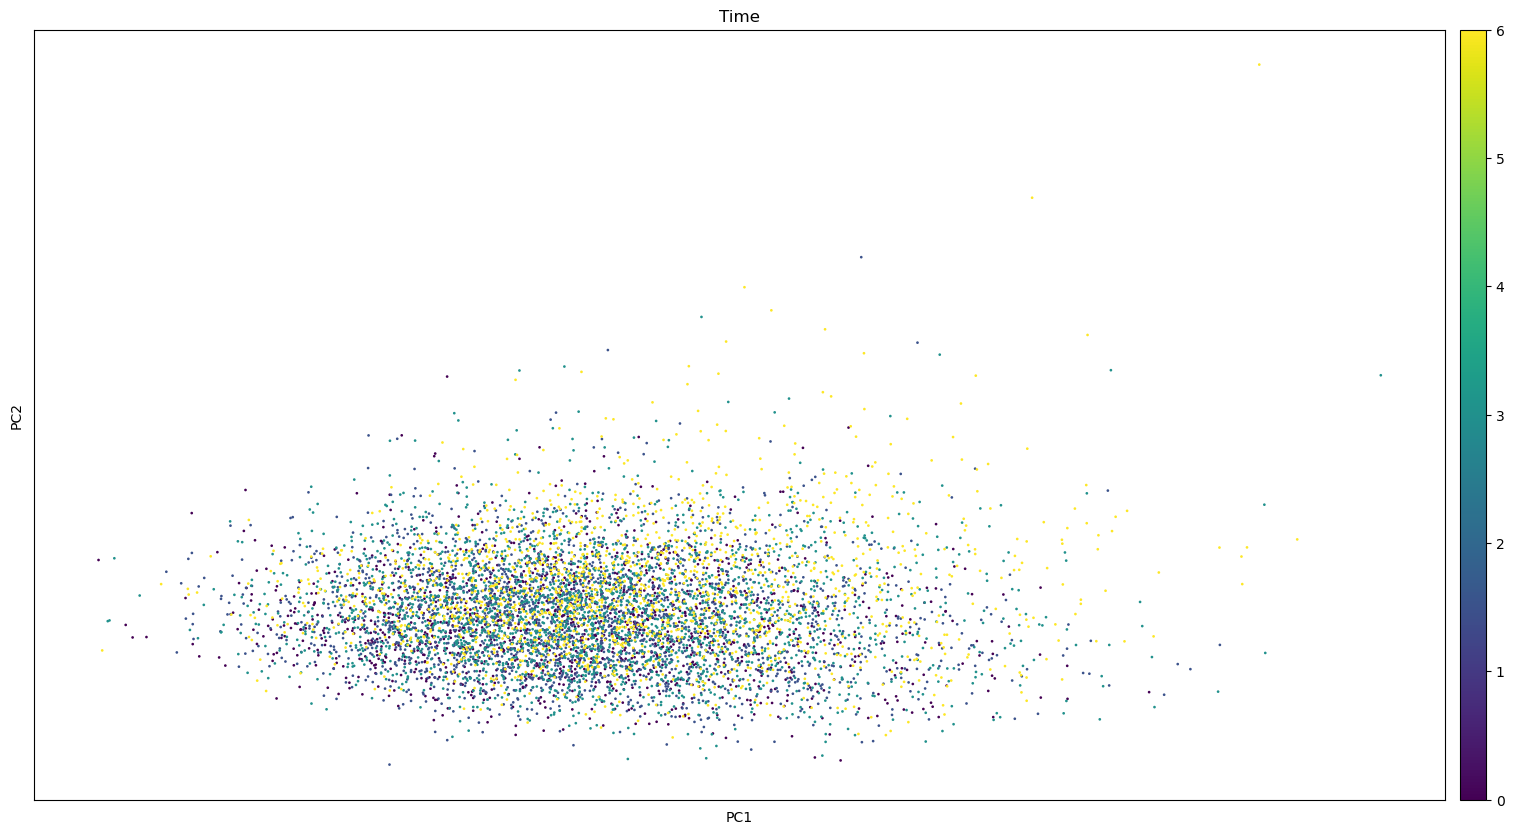

In [63]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca(adata, color="Time", components=["1,2"])

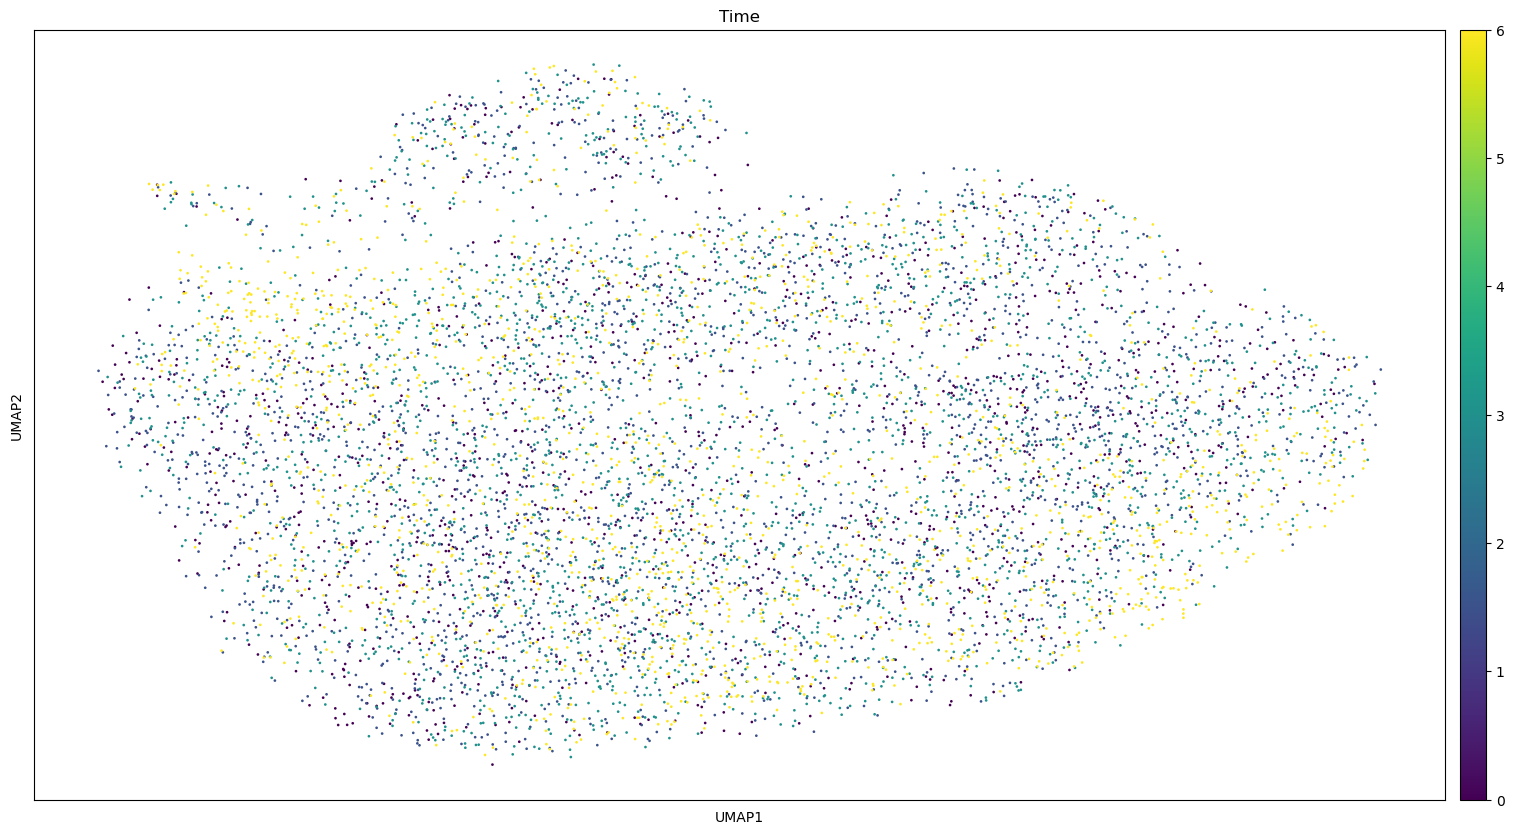

In [64]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.umap(adata, color="Time")

/home/x_mamin/.conda/envs/lilliput_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


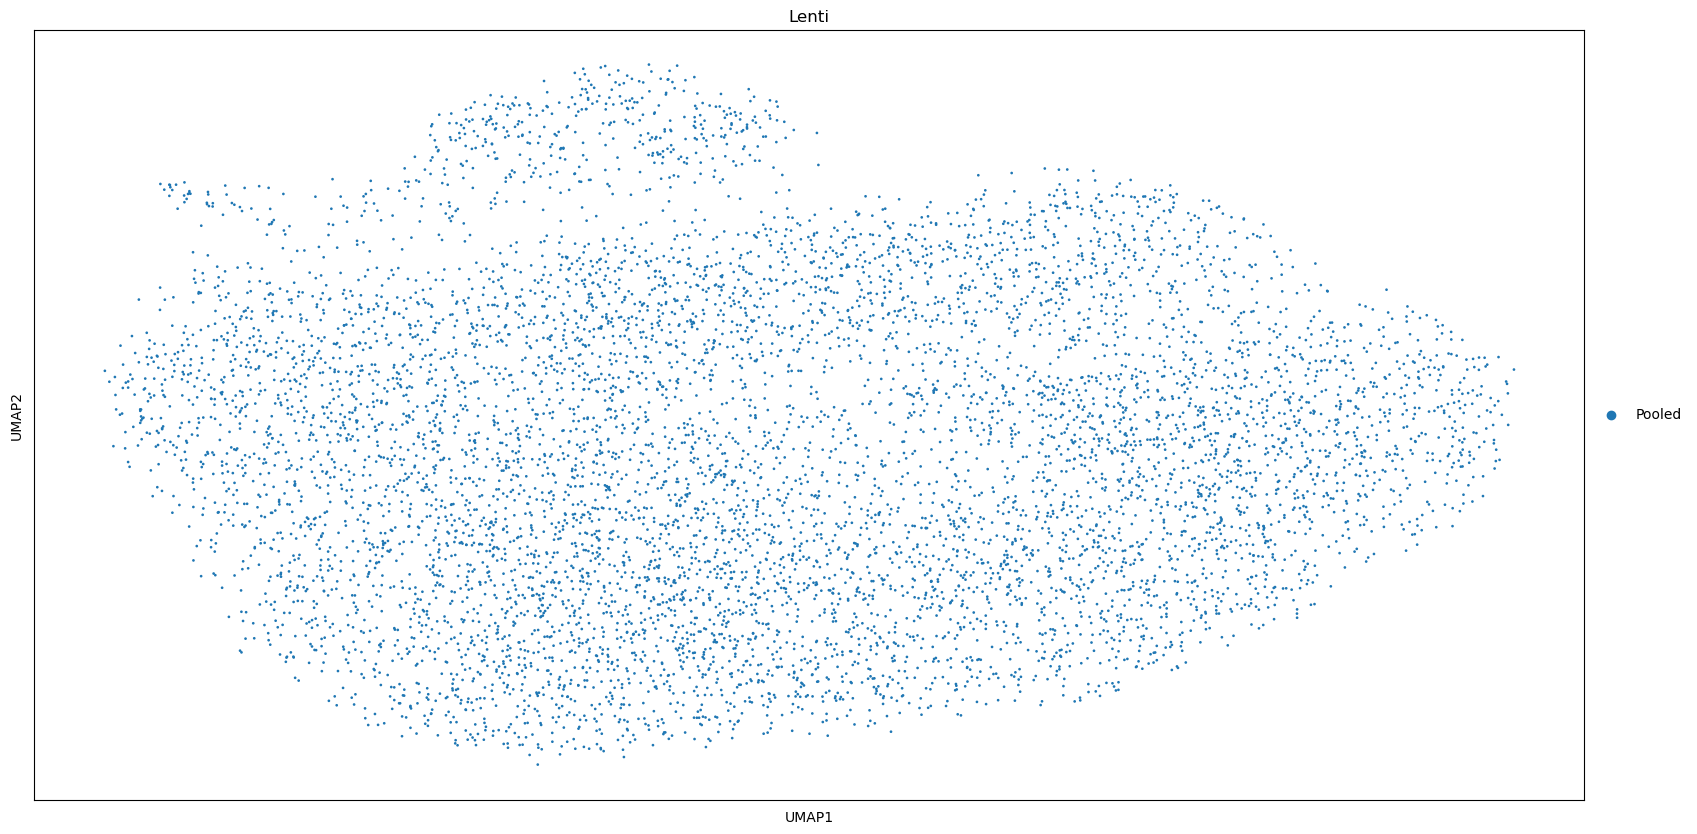

In [65]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.umap(adata, color="Lenti")

In [66]:
adata_pooled = adata[adata.obs["Lenti"] == "Pooled"]

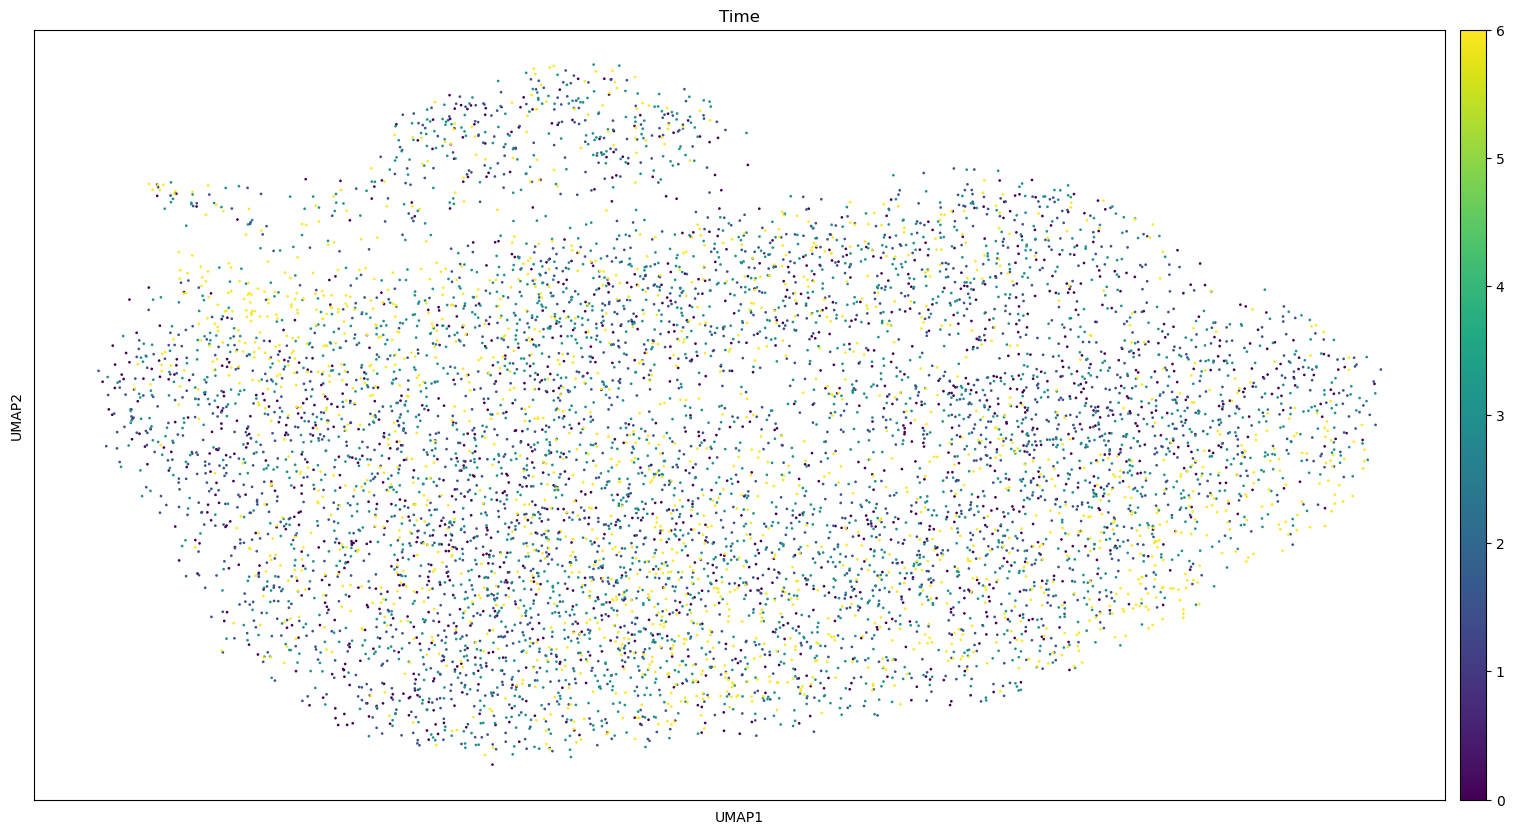

In [67]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.umap(adata_pooled, color="Time", size=15)

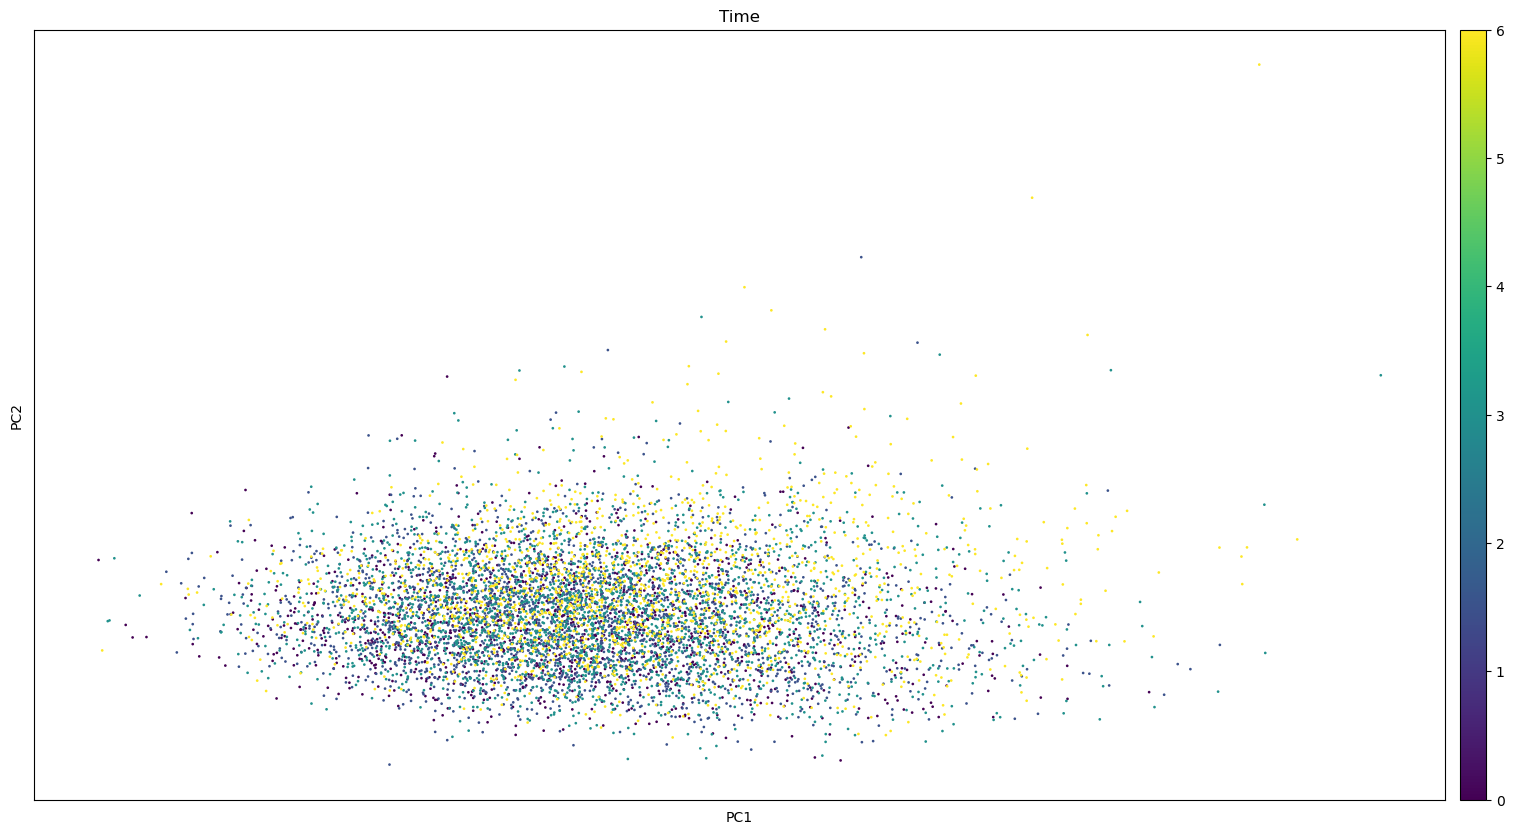

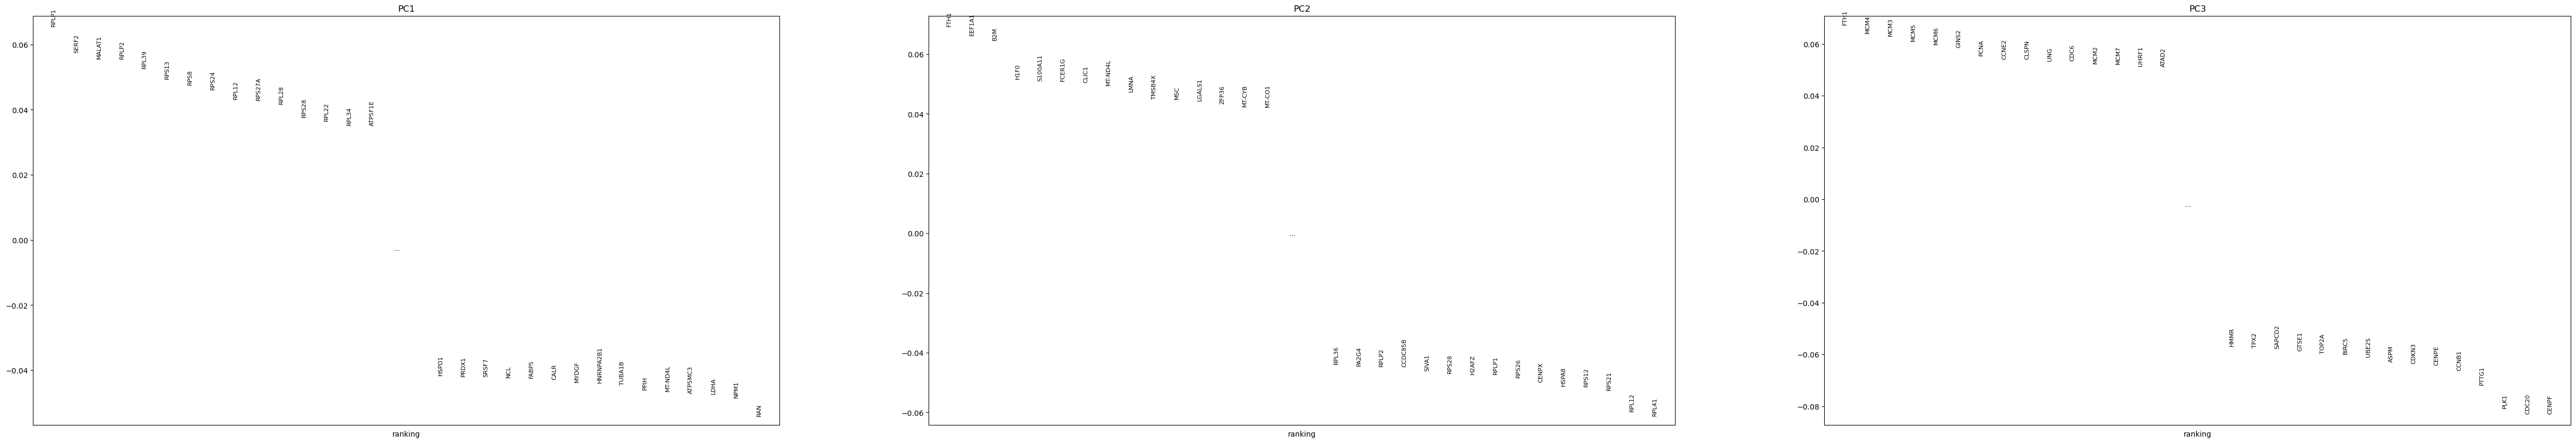

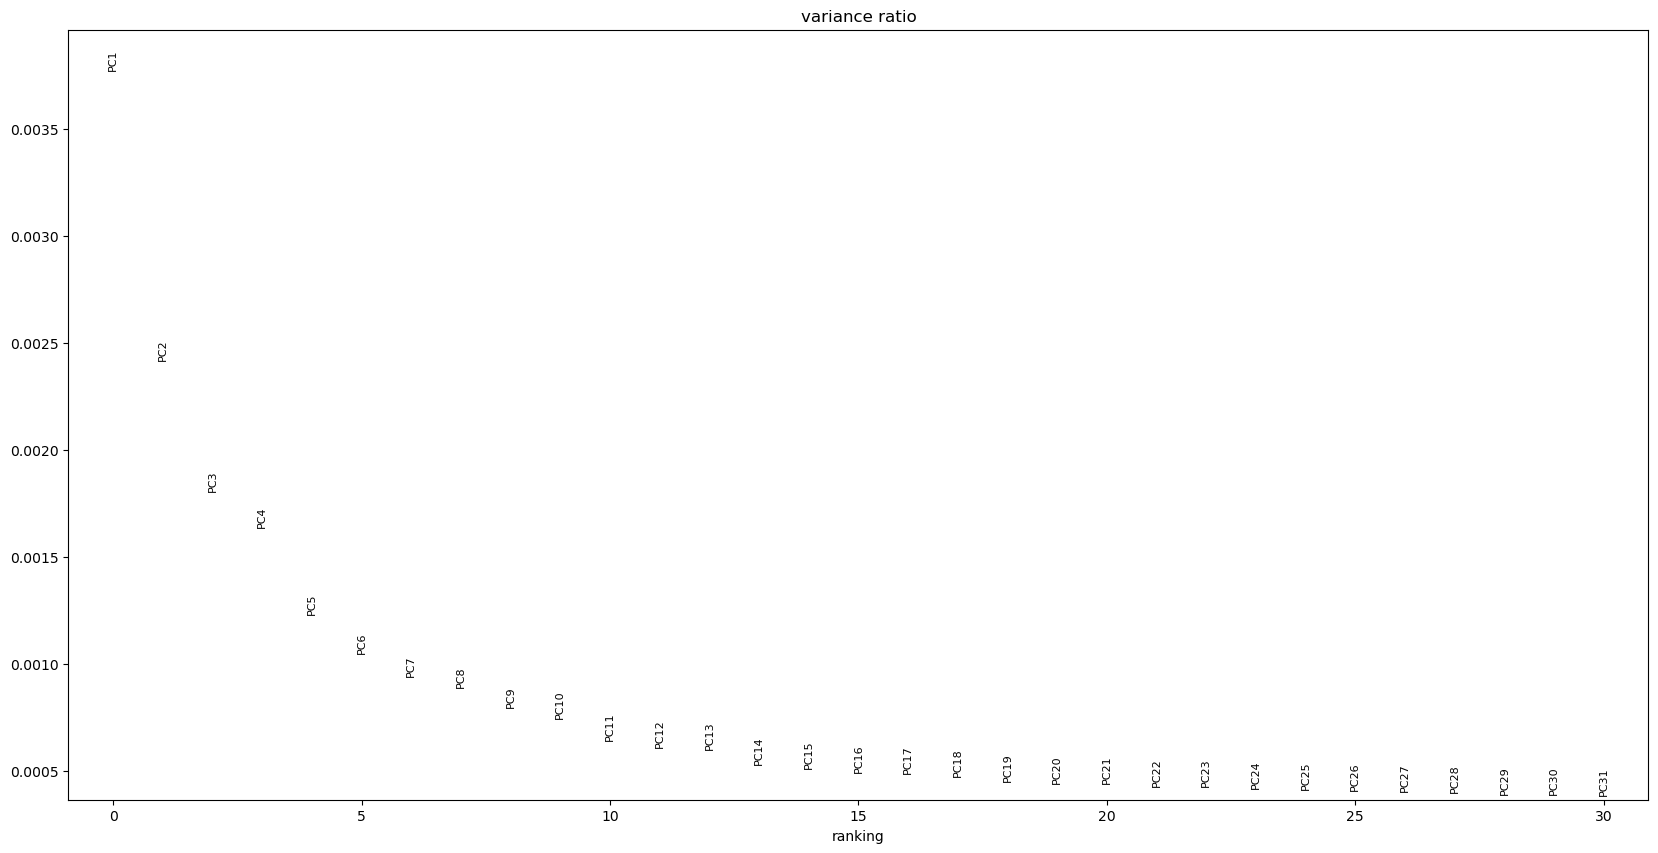

In [68]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca_overview(adata_pooled, color="Time")

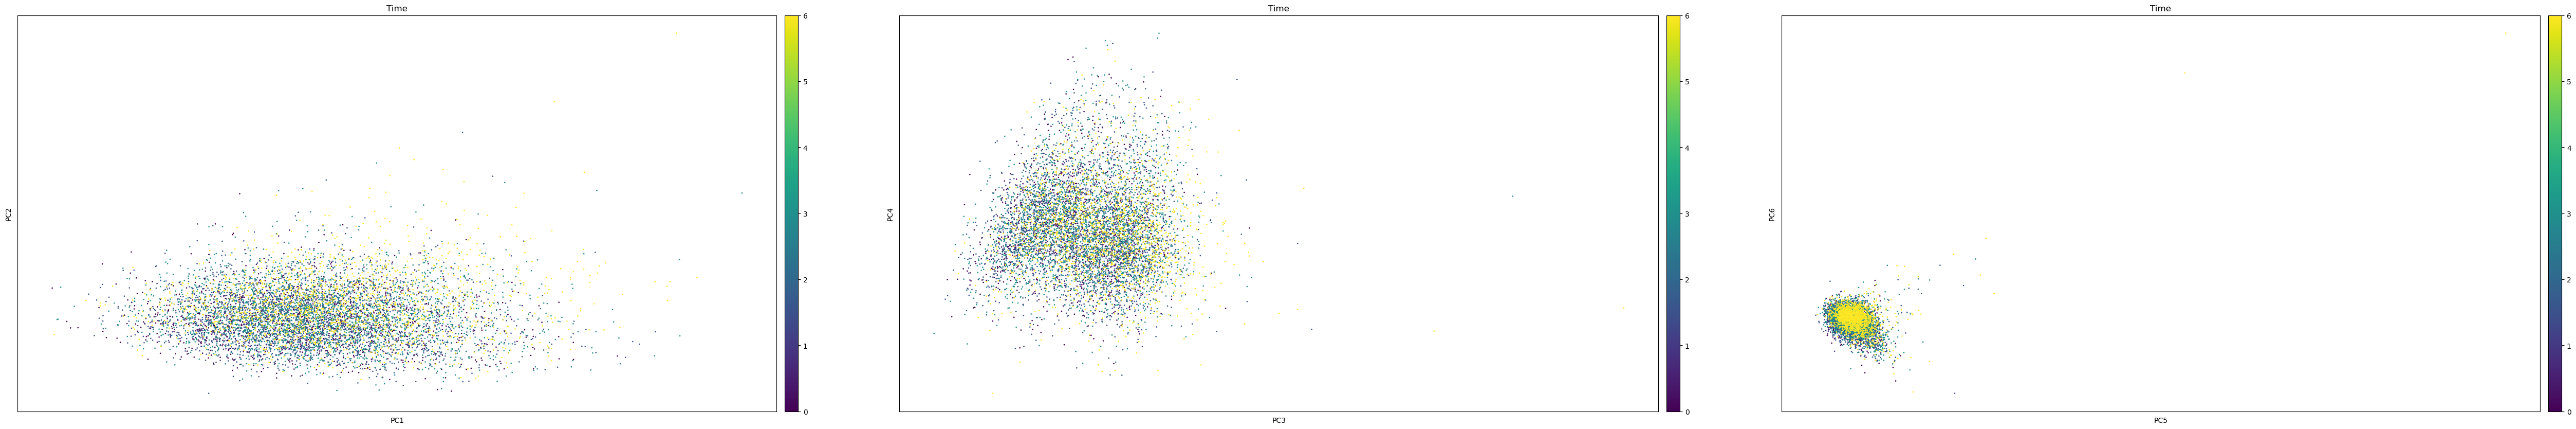

In [69]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca(adata_pooled, color="Time", components=["1,2", "3,4", "5,6"])

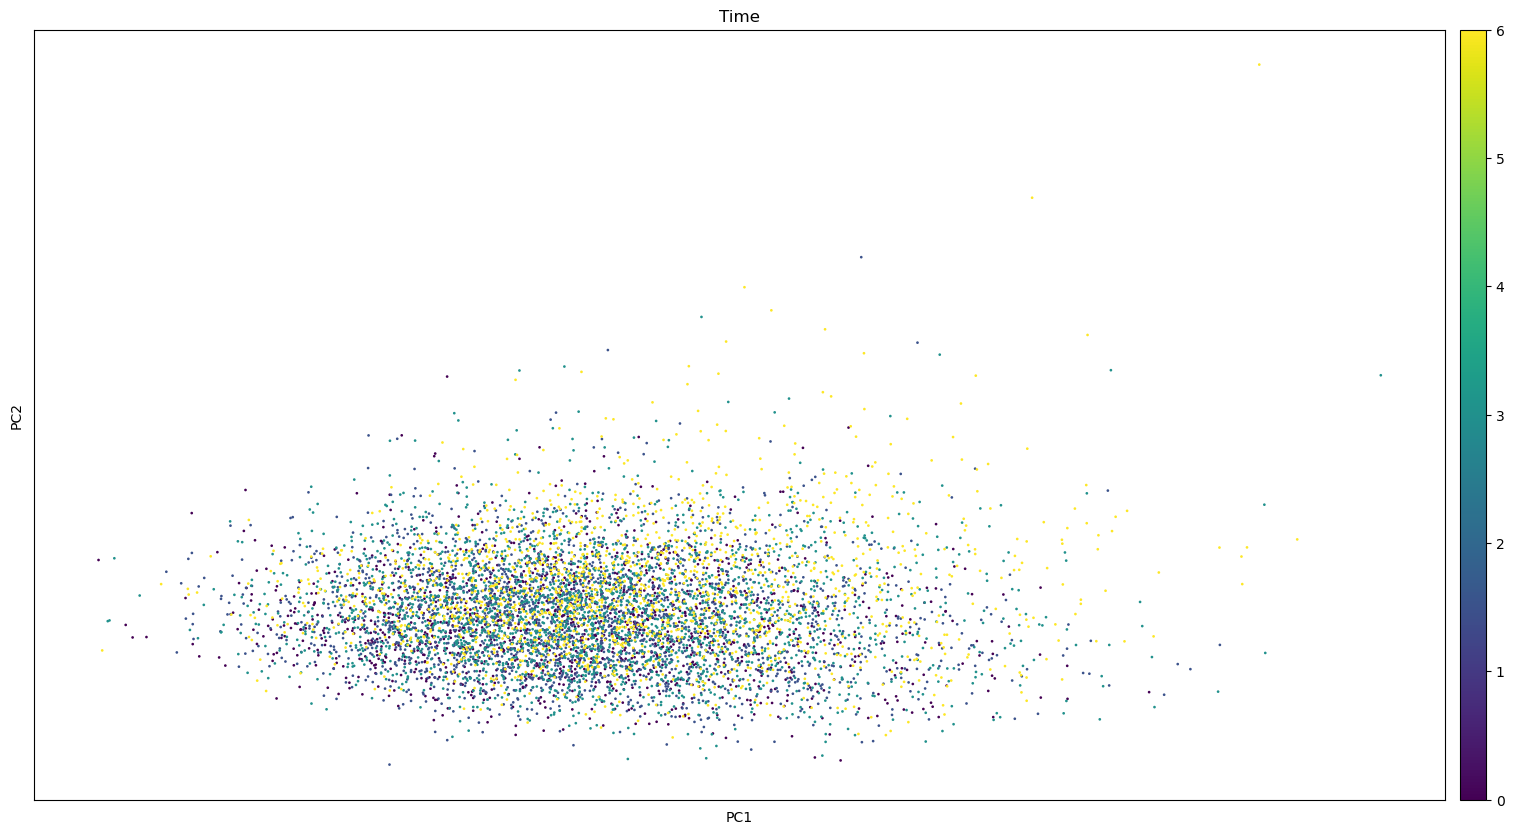

In [70]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca(adata_pooled, color="Time", components=["1,2"])

In [71]:
adata_arrayed = adata[adata.obs["Lenti"] == "Arrayed"]

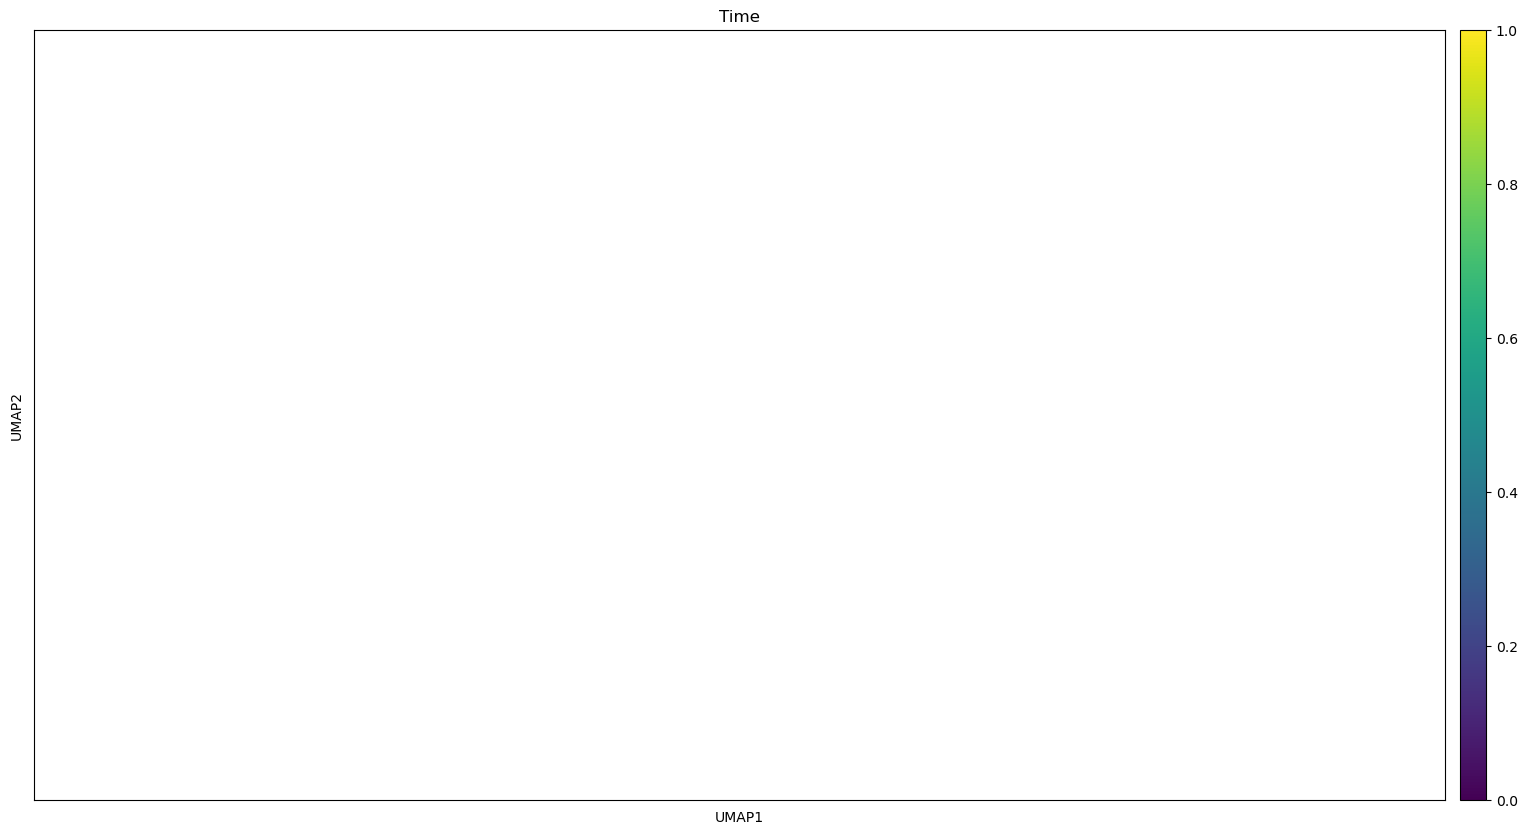

In [72]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.umap(adata_arrayed, color="Time", size=15)

In [73]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca_overview(adata_arrayed, color="Time")

ZeroDivisionError: division by zero

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
sc.pl.pca(adata_arrayed, color="Time", components=["1,2", "3,4", "5,6"])

In [76]:
adata_pooled.obsm["X_pca"].shape

(8064, 50)

In [77]:
gmm = sklearn.mixture.GaussianMixture(n_components=4, covariance_type="full")
gmm.fit(adata_pooled.obsm["X_pca"][:, 0:1])

GaussianMixture(n_components=4)

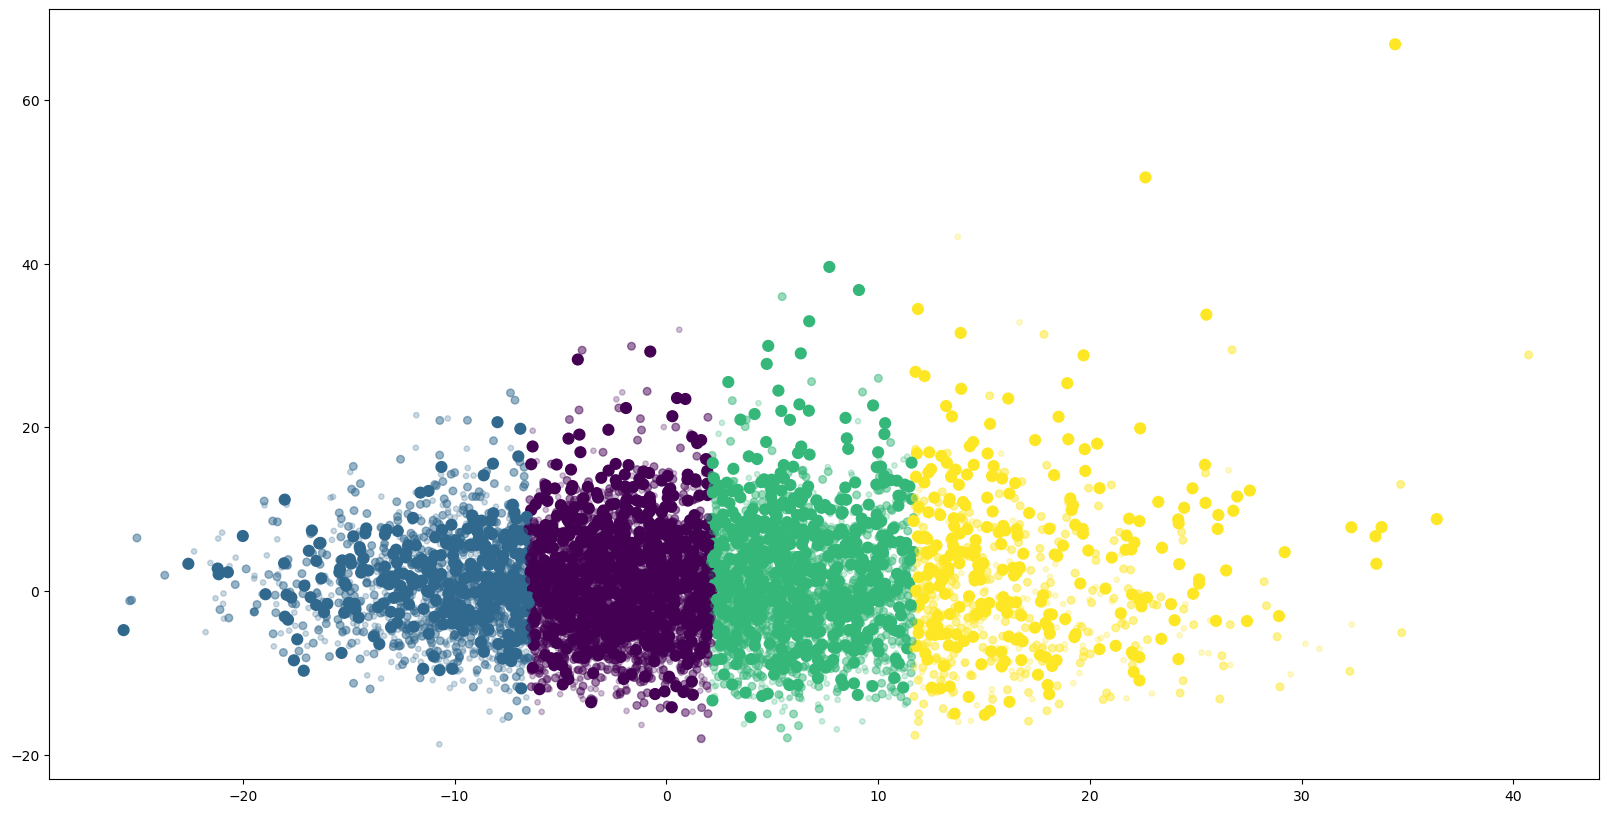

In [78]:
y_pred = gmm.predict(adata_pooled.obsm["X_pca"][:, 0:1])
mark_dict = {0.0: 'o', 1.5:"s", 3.0: "x", 6.0: "1"}
plt.scatter(adata_pooled.obsm["X_pca"][:, 0], adata_pooled.obsm["X_pca"][:, 1],
            c=y_pred, alpha=adata_pooled.obs["Time"]/6.0, s=adata_pooled.obs["Time"]*10)

In [ ]:
gmm = sklearn.mixture.GaussianMixture(n_components=4, covariance_type="full")
gmm.fit(adata_arrayed.obsm["X_pca"][:, 0:1])

In [ ]:
y_pred = gmm.predict(adata_arrayed.obsm["X_pca"][:, 0:1])
plt.scatter(adata_arrayed.obsm["X_pca"][:, 0], adata_arrayed.obsm["X_pca"][:, 1], 
            c=y_pred, alpha=adata_arrayed.obs["Time"]/6.0, s=adata_arrayed.obs["Time"]*10)

## SVD for the full dataset

In [79]:
sample_cells = np.random.randint(low=0, high=adata.X.shape[0], size=int(1e3))
sample_cells

array([1232, 5204, 5768, 7799, 2340, 7005, 1723,  235, 4204, 1295, 2061,
       3737, 5886, 5349, 1744, 2866,  302,  130, 3233, 4572, 4698, 7849,
       5377, 1434, 3528, 4435,  411, 7929, 5731, 7318, 2777, 3288,  364,
       5972, 1956, 7413, 7064, 6686, 1676, 5940, 7415, 6890, 5688, 4316,
       7922, 4164,   69, 1196, 5461, 2810, 1649, 5016, 5256, 1784,  492,
       6266, 3440, 5498,  414,  288, 1365, 4035, 6329, 3957, 8020, 5457,
       7294, 3217, 7499, 4498, 6009, 2723, 4922, 6741, 6637, 4395, 6591,
       7522,  371, 2145,  969, 2203, 4031, 5097, 5683, 7739, 5796,  688,
        225, 4491, 4333, 7752, 5867, 1518, 8029, 4513, 7855, 2190, 1390,
       2719, 5335, 3903, 5803, 3605, 5506,  666, 7396, 2542, 6153, 2433,
       1976,  835, 4945, 7425, 5232, 2334, 7714,  993, 7087, 2058, 1273,
       3718,  517, 2346,  198, 7273, 1702, 2565, 5436, 2718, 4667,    8,
       5311, 7377,  375, 1622, 6275, 4879, 4710, 2414, 2548, 3934, 4102,
       5725, 7190, 2058, 4764, 1927, 5467, 1520, 52

In [80]:
eigengenes_full, s_full, eigensamples_full =svd(adata.layers["scvi_normalized"][sample_cells,:], compute_uv=True, full_matrices=False)

In [81]:
eigengenes_full.shape

(1000, 1000)

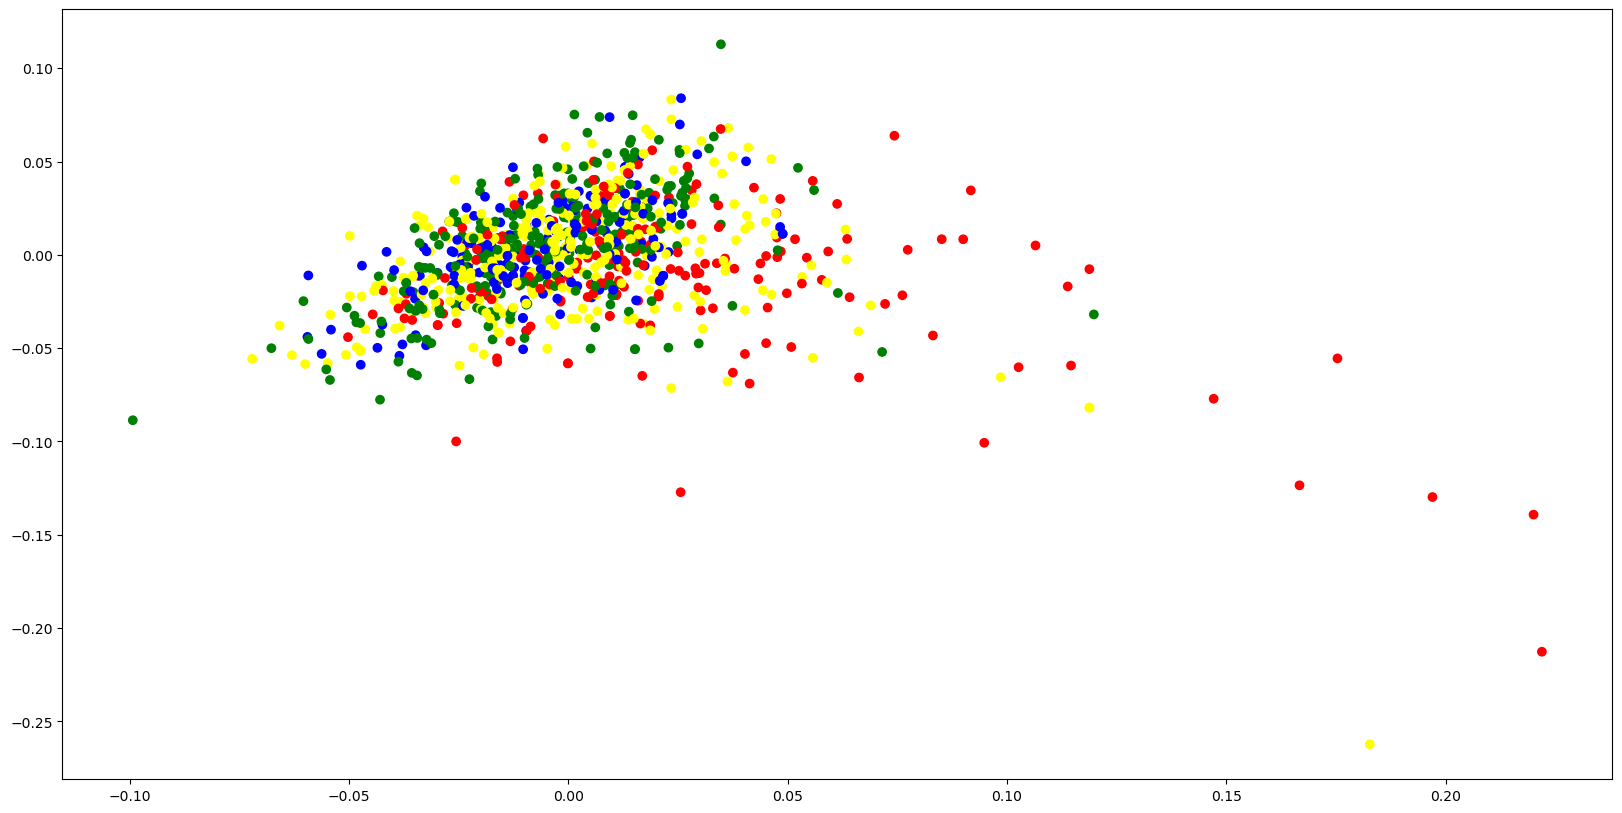

In [82]:
colors = {0.0:"blue", 1.5: "green", 3.0: "yellow", 6.0: "red"}
plt.scatter(eigengenes_full[:, 0], eigengenes_full[:, 1], c=[colors[time] for time in adata.obs["Time"][sample_cells]])

Text(0.5, 1.0, '6.0')

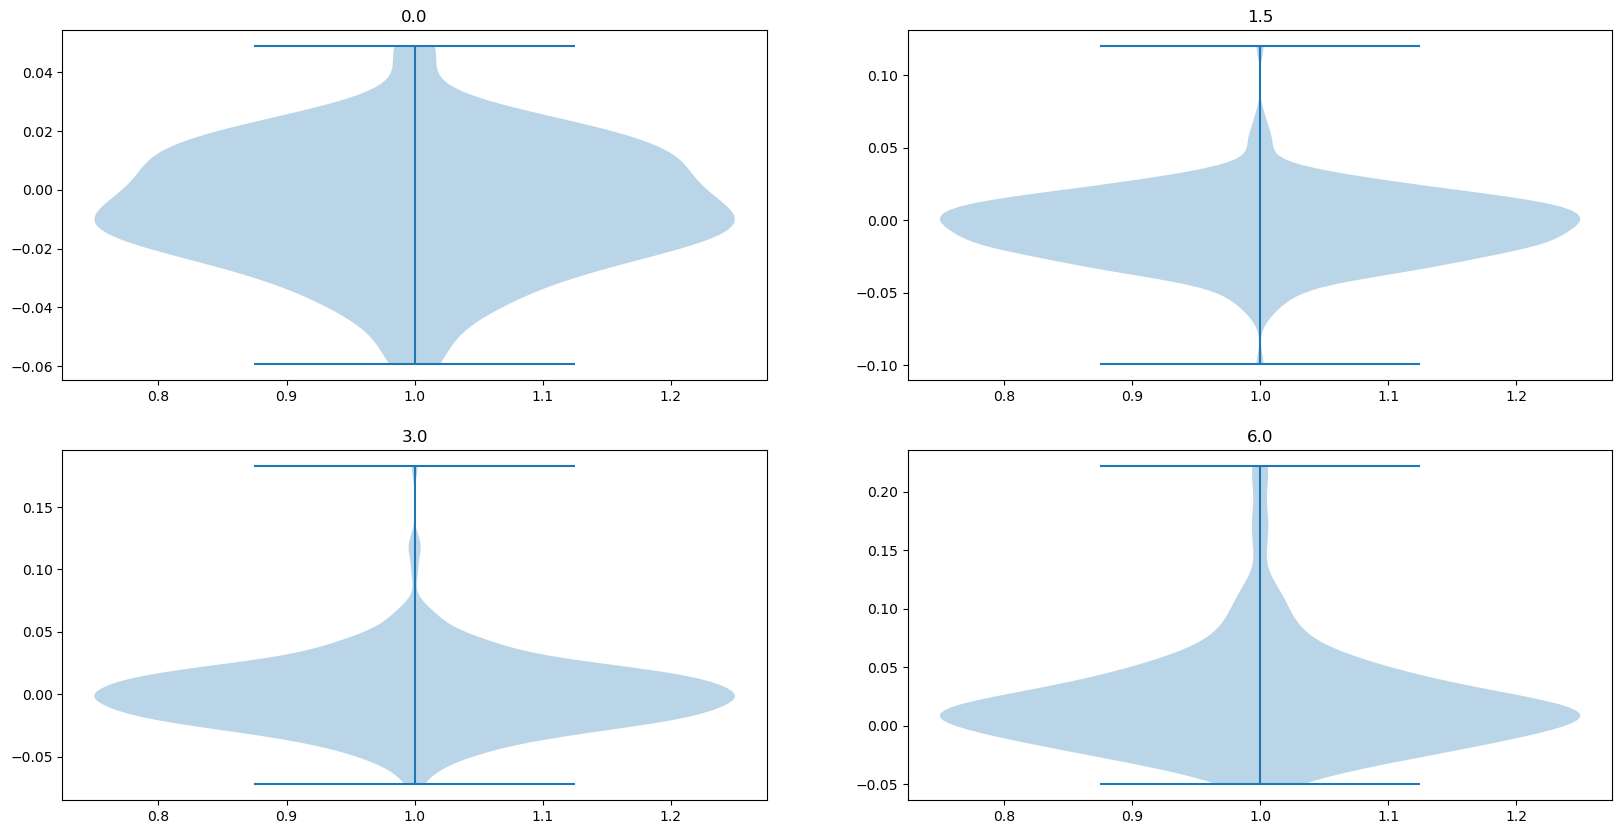

In [83]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(2,2)
axs[0,0].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 0.0, 0])
axs[0,0].set_title("0.0")
axs[0,1].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 1.5, 0])
axs[0,1].set_title("1.5")
axs[1,0].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 3.0, 0])
axs[1,0].set_title("3.0")
axs[1,1].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 6.0, 0])
axs[1,1].set_title("6.0")

## Pathways

In [84]:
# Pathways
genes = {
        "HSIAO_HOUSEKEEPING_GENES": ["AAMP","AARS1","ABLIM1","ACKR1","ACTB","ACTG1","AGPAT1","ALDOA","ANP32B",
                                     "ANXA11","ANXA2","AP3S1","APEX1","APLP2","ARAF","ARF1","ARF3","ARF4","ARHGAP1",
                                     "ARHGDIB","ARL6IP1","ARPC2","ATF4","ATIC","ATOX1","ATP5F1A","ATP5F1B","ATP5F1C",
                                     "ATP5MC1","ATP5MC2","ATP5MC3","ATP5PB","ATP6V1F","B2M","BCAP31","BCLAF1","BECN1",
                                     "BRD2","BTG2","BUD31","C1QBP","CALM2","CANX","CAP1","CAPN2","CAPNS1","CAPZA1",
                                     "CASC3","CAST","CCND2","CCNI","CCR9","CCT4","CD164","CD34","CD3E","CD63","CD74",
                                     "CD81","CES2","CETN2","CFL1","CHI3L2","CHKB","CIRBP","CLIC1","CLTA","CLTC","CLU",
                                     "COMT","COPA","COPS6","COX10","COX4I1","COX6A1","COX6B1","COX6C","COX7A2","COX7C",
                                     "COX8A","CSNK2B","CST3","CSTB","CTDSP2","CTNNB1","CYB5R3","DAZAP2","DCTN2","DDB1","DDT",
                                     "DDX39B","DDX5","DHPS","DSTN","DUSP1","DVL3","DYNLL1","ECHS1","EEF1A1","EEF1B2","EEF1D",
                                     "EEF1G","EEF2","EIF1","EIF3C","EIF3E","EIF3F","EIF4A1","EIF4A2","EIF4A3","EIF4G2",
                                     "EIF4H","ENO1","ERH","ESD","EZR","FAM193A","FAS","FBL","FCGRT","FHL1","FKBP1A","FKBP4",
                                     "FLNA","FMOD","FNTA","FTH1","FTL","FUCA1","FUS","FYN","GAPDH","GDI2","GLUL","GNAS",
                                     "GNB1","GPS1","GPS2","GPX4","GSTO1","GSTP1","GUSB","H2AC18","H2AZ1","H3-3A","H3-3B",
                                     "HDAC1","HINT1","HLA-A","HLA-B","HLA-DOA","HLA-DPA1","HLA-DQA1","HLA-DQB1","HLA-DRA",
                                     "HLA-E","HMGB1","HMGN2","HNRNPA1","HNRNPC","HNRNPF","HNRNPK","HNRNPL","HPN","HSP90AA1",
                                     "HSP90AB1","HSPB1","HSPD1","HTRA1","HYAL2","IFITM1","IFITM3","ILK","IQGAP1","IRAK1",
                                     "ISG20","ITGB1","ITPK1","JOSD1","JUNB","JUND","KARS1","KAT6A","LAMP1","LASP1","LDHA",
                                     "LDHB","LGALS1","LGALS3","LINC02967","LTA4H","MARCKS","MAZ","MDH1","MGP","MGST2","MLF2",
                                     "MLH1","MORF4L2","MPRIP","MSN","MT-RNR1","MT2A","MYH9","NACA","NAP1L1","NCL","NCOR2",
                                     "NCSTN","NDRG1","NDUFA12","NDUFA4","NDUFV2","NEDD8","NFIB","NFKBIA","NONO","NPC2",
                                     "NPIPB3","NPM1","OAZ1","OS9","PABPC1","PARP1","PAX6","PCBP2","PDLIM1","PEBP1","PFDN5",
                                     "PFN1","PGAM1","PGK1","PHB2","PI4KA","PIM1","PLP2","POLR2L","PPIA","PRDX1","PRDX6",
                                     "PSAP","PSD","PSEN1","PSMB2","PSMB3","PSMB4","PSMB5","PSMB6","PSMC1","PSMD2","PSMD7",
                                     "PSMD8","PSME1","PTDSS1","PTMA","PTP4A2","PTPN6","QARS1","RAC1","RACK1","RBPMS","RER1",
                                     "RFTN1","RHOA","RPA2","RPL10A","RPL11","RPL12","RPL13","RPL13A","RPL14","RPL17","RPL18",
                                     "RPL18A","RPL19","RPL21","RPL23","RPL23A","RPL24","RPL27","RPL27A","RPL28","RPL29",
                                     "RPL3","RPL31","RPL32","RPL34","RPL35","RPL35A","RPL36A","RPL36AL","RPL37A","RPL38",
                                     "RPL39","RPL4","RPL41","RPL6","RPL7","RPL7A","RPL8","RPL9P7","RPLP0","RPLP1","RPLP2",
                                     "RPN2","RPS10","RPS11","RPS14","RPS15","RPS15A","RPS16","RPS17","RPS18","RPS19","RPS2",
                                     "RPS21","RPS23","RPS25","RPS26","RPS27","RPS27A","RPS28","RPS29","RPS3","RPS3A","RPS5",
                                     "RPS6","RPS7","RPS8","RPS9","RPSA","S100A10","SARS1","SEC61B","SELENOW","SEPTIN2",
                                     "SERPINA3","SERPINB6","SET","SF1","SF3B2","SLC25A3","SLC25A5","SLC25A6","SLC6A8",
                                     "SNRNP70","SNRPD2","SNRPN","SOD1","SON","SPCS2","SPTBN1","SQSTM1","SRP14","SSB","SSR2",
                                     "STAT3","STMN1","STOM","SURF1","TAGLN2","TAX1BP1","TCEA1","TLE5","TMBIM6","TMED10",
                                     "TMSB10","TMSB4X","TPR","TPT1","TRAF4","TRIM28","TUBBP1","TXN","TXNIP","UBA1","UBA52",
                                     "UBB","UBC","UBE2C","UBE2D3","UQCRB","UQCRH","USP11","VDAC2","VIM","VPS72","WARS1",
                                     "XBP1","XPO1","YBX1","YWHAB","YWHAH","YWHAQ","YWHAZ","ZFP36","ZNF91"],
    
        "Reactome_TCA": ["ACO2", "CS", "DLD", "DLST", "FAHD1", "FH", "IDH2", "IDH3A", "IDH3B", 
                         "IDH3G", "MDH2", "ME2", "ME3", "NNT", "OGDH", "SDHA", "SDHB", "SDHC", 
                         "SDHD", "SUCLA2", "SUCLG1", "SUCLG2"],
    
        "NFKB": ["BIRC2","BIRC3","BTRC","CD27","CD40","CD40LG","CD70","CHUK","CUL1","EDA","EDA2R",
                 "EDAR","EDARADD","FASLG","FBXW11", "LTA","LTB","LTBR","MAP3K14","NFKB2","PSMA1",
                 "PSMA2","PSMA3","PSMA4","PSMA5","PSMA6","PSMA7","PSMA8","PSMB1",
                  "PSMB10","PSMB11","PSMB2","PSMB3","PSMB4","PSMB5","PSMB6","PSMB7","PSMB8","PSMB9",
                 "PSMC1","PSMC2","PSMC3","PSMC4", "PSMC5","PSMC6","PSMD1","PSMD10","PSMD11","PSMD12",
                 "PSMD13","PSMD14","PSMD2","PSMD3","PSMD4","PSMD5","PSMD6","PSMD7", "PSMD8","PSMD9",
                 "PSME1","PSME2","PSME3","PSME4","PSMF1","RELB","RPS27A","SEM1","SKP1","TNF","TNFRSF11A","TNFRSF11B",
                  "TNFRSF12A","TNFRSF13B","TNFRSF13C","TNFRSF14","TNFRSF17","TNFRSF18","TNFRSF1A",
                 "TNFRSF1B","TNFRSF25","TNFRSF4", "TNFRSF6B","TNFRSF8","TNFRSF9","TNFSF11","TNFSF12",
                 "TNFSF13","TNFSF13B","TNFSF14","TNFSF15","TNFSF18","TNFSF4",
                  "TNFSF8","TNFSF9","TRAF2","TRAF3","UBA3","UBA52","UBB","UBC","UBE2M"],
    
        "HALLMARK_TNFA_SIGNALING_VIA_NFKB": ["ABCA1","ACKR3","AREG","ATF3","ATP2B1","B4GALT1","B4GALT5","BCL2A1",
                                             "BCL3","BCL6","BHLHE40","BIRC2","BIRC3","BMP2","BTG1","BTG2","BTG3",
                                             "CCL2","CCL20","CCL4","CCL5","CCN1","CCND1","CCNL1","CCRL2","CD44",
                                             "CD69","CD80","CD83","CDKN1A","CEBPB","CEBPD","CFLAR","CLCF1","CSF1",
                                             "CSF2","CXCL1","CXCL10","CXCL11","CXCL2","CXCL3","CXCL6","DDX58",
                                             "DENND5A","DNAJB4","DRAM1","DUSP1","DUSP2","DUSP4","DUSP5","EDN1",
                                             "EFNA1","EGR1","EGR2","EGR3","EHD1","EIF1","ETS2","F2RL1","F3",
                                             "FJX1","FOS","FOSB","FOSL1","FOSL2","FUT4","G0S2","GADD45A","GADD45B",
                                             "GCH1","GEM","GFPT2","GPR183","HBEGF","HES1","ICAM1","ICOSLG","ID2",
                                             "IER2","IER3","IER5","IFIH1","IFIT2","IFNGR2","IL12B","IL15RA","IL18",
                                             "IL1A","IL1B","IL23A","IL6","IL6ST","IL7R","INHBA","IRF1","IRS2","JAG1",
                                             "JUN","JUNB","KDM6B","KLF10","KLF2","KLF4","KLF6","KLF9","KYNU","LAMB3",
                                             "LDLR","LIF","LITAF","MAFF","MAP2K3","MAP3K8","MARCKS","MCL1","MSC",
                                             "MXD1","MYC","NAMPT","NFAT5","NFE2L2","NFIL3","NFKB1","NFKB2","NFKBIA",
                                             "NFKBIE","NINJ1","NR4A1","NR4A2","NR4A3","OLR1","PANX1","PDE4B",
                                             "PDLIM5","PER1","PFKFB3","PHLDA1","PHLDA2","PLAU","PLAUR","PLEK","PLK2",
                                             "PLPP3","PMEPA1","PNRC1","PPP1R15A","PTGER4","PTGS2","PTPRE","PTX3",
                                             "RCAN1","REL","RELA","RELB","RHOB","RIPK2","RNF19B","SAT1","SDC4",
                                             "SERPINB2","SERPINB8","SERPINE1","SGK1","SIK1","SLC16A6","SLC2A3",
                                             "SLC2A6","SMAD3","SNN","SOCS3","SOD2","SPHK1","SPSB1","SQSTM1","STAT5A",
                                             "TANK","TAP1","TGIF1","TIPARP","TLR2","TNC","TNF","TNFAIP2","TNFAIP3",
                                             "TNFAIP6","TNFAIP8","TNFRSF9","TNFSF9","TNIP1","TNIP2","TRAF1","TRIB1",
                                             "TRIP10","TSC22D1","TUBB2A","VEGFA","YRDC","ZBTB10","ZC3H12A","ZFP36"],
    
        "REACTOME_TNFR2_NON_CANONICAL_NF_KB_PATHWAY": ["BIRC2","BIRC3","BTRC","CD27","CD40","CD40LG","CD70","CHUK",
                                                       "CUL1","EDA","EDA2R","EDAR","EDARADD","FASLG","FBXW11","LTA",
                                                       "LTB","LTBR","MAP3K14","NFKB2","PSMA1","PSMA2","PSMA3","PSMA4",
                                                       "PSMA5","PSMA6","PSMA7","PSMA8","PSMB1","PSMB10","PSMB11",
                                                       "PSMB2","PSMB3","PSMB4","PSMB5","PSMB6","PSMB7","PSMB8","PSMB9",
                                                       "PSMC1","PSMC2","PSMC3","PSMC4","PSMC5","PSMC6","PSMD1",
                                                       "PSMD10","PSMD11","PSMD12","PSMD13","PSMD14","PSMD2","PSMD3",
                                                       "PSMD4","PSMD5","PSMD6","PSMD7","PSMD8","PSMD9","PSME1",
                                                       "PSME2","PSME3","PSME4","PSMF1","RELB","RPS27A","SEM1","SKP1",
                                                       "TNF","TNFRSF11A","TNFRSF11B","TNFRSF12A","TNFRSF13B",
                                                       "TNFRSF13C","TNFRSF14","TNFRSF17","TNFRSF18","TNFRSF1A",
                                                       "TNFRSF1B","TNFRSF25","TNFRSF4","TNFRSF6B","TNFRSF8","TNFRSF9",
                                                       "TNFSF11","TNFSF12","TNFSF13","TNFSF13B","TNFSF14","TNFSF15",
                                                       "TNFSF18","TNFSF4","TNFSF8","TNFSF9","TRAF2","TRAF3","UBA3",
                                                       "UBA52","UBB","UBC","UBE2M"],
        "REACTOME_INTERFERON_ALPHA_BETA_SIGNALING": ["ABCE1","ADAR","BST2","EGR1","GBP2","HLA-A","HLA-B","HLA-C",
                                                     "HLA-E","HLA-F","HLA-G","HLA-H","IFI27","IFI35","IFI6","IFIT1",
                                                     "IFIT2","IFIT3","IFIT5","IFITM1","IFITM2","IFITM3","IFNA1",
                                                     "IFNA10","IFNA13","IFNA14","IFNA16","IFNA17","IFNA2","IFNA21",
                                                     "IFNA4","IFNA5","IFNA6","IFNA7","IFNA8","IFNAR1","IFNAR2",
                                                     "IFNB1","IP6K2","IRF1","IRF2","IRF3","IRF4","IRF5","IRF6",
                                                     "IRF7","IRF8","IRF9","ISG15","ISG20","JAK1","KPNA1","KPNB1",
                                                     "MX1","MX2","OAS1","OAS2","OAS3","OASL","PSMB8","PTPN1",
                                                     "PTPN11","PTPN6","RNASEL","RSAD2","SAMHD1","SOCS1","SOCS3",
                                                     "STAT1","STAT2","TYK2","USP18","XAF1"],
        "REACTOME_Type I IFN-regulated genes with ISRE promoter elements": ["ADAR","BST2","EGR1","GBP2","HLA-A","HLA-B","HLA-C",
                                                     "HLA-E","HLA-F","HLA-G","HLA-H","IFI27","IFI35","IFI6","IFIT1",
                                                     "IFIT2","IFIT3","IFIT5","IFITM1","IFITM2","IFITM3","IP6K2",
                                                        "IRF1","IRF2","IRF3","IRF4","IRF5","IRF6",
                                                     "IRF7","IRF8","IRF9","ISG15","ISG20", 
                                                     "MX1","MX2","OAS1","OAS2","OAS3","OASL","PSMB8","RNASEL","RSAD2",
                                                                            "SAMHD1", "XAF1"]}
    

## Selecting pathway genes

In [86]:
#adata_selected = adata[adata.obs["IRF1"] == 1.0]
adata_selected = adata
# substract average gene expression
print(len(genes["REACTOME_Type I IFN-regulated genes with ISRE promoter elements"]))
#adata_selected = adata_selected[adata_selected.obs["Perturbed"] == 'Perturbed']
adata_selected = adata_selected[:, [ind for ind, g in enumerate(adata_selected.var["features"]) 
                                    if g in genes["REACTOME_Type I IFN-regulated genes with ISRE promoter elements"]]]
pd.unique(adata_selected.obs["NT"])
#adata_selected = adata_selected.copy().T
adata_selected = adata_selected[adata_selected.obs["NT"] == 'NT']
adata_selected = adata_selected[adata_selected.obs["Lenti"] == 'Pooled']

44


In [87]:
adata_selected.X.shape

(834, 43)

In [88]:
# try doing imputations using scvi-tools

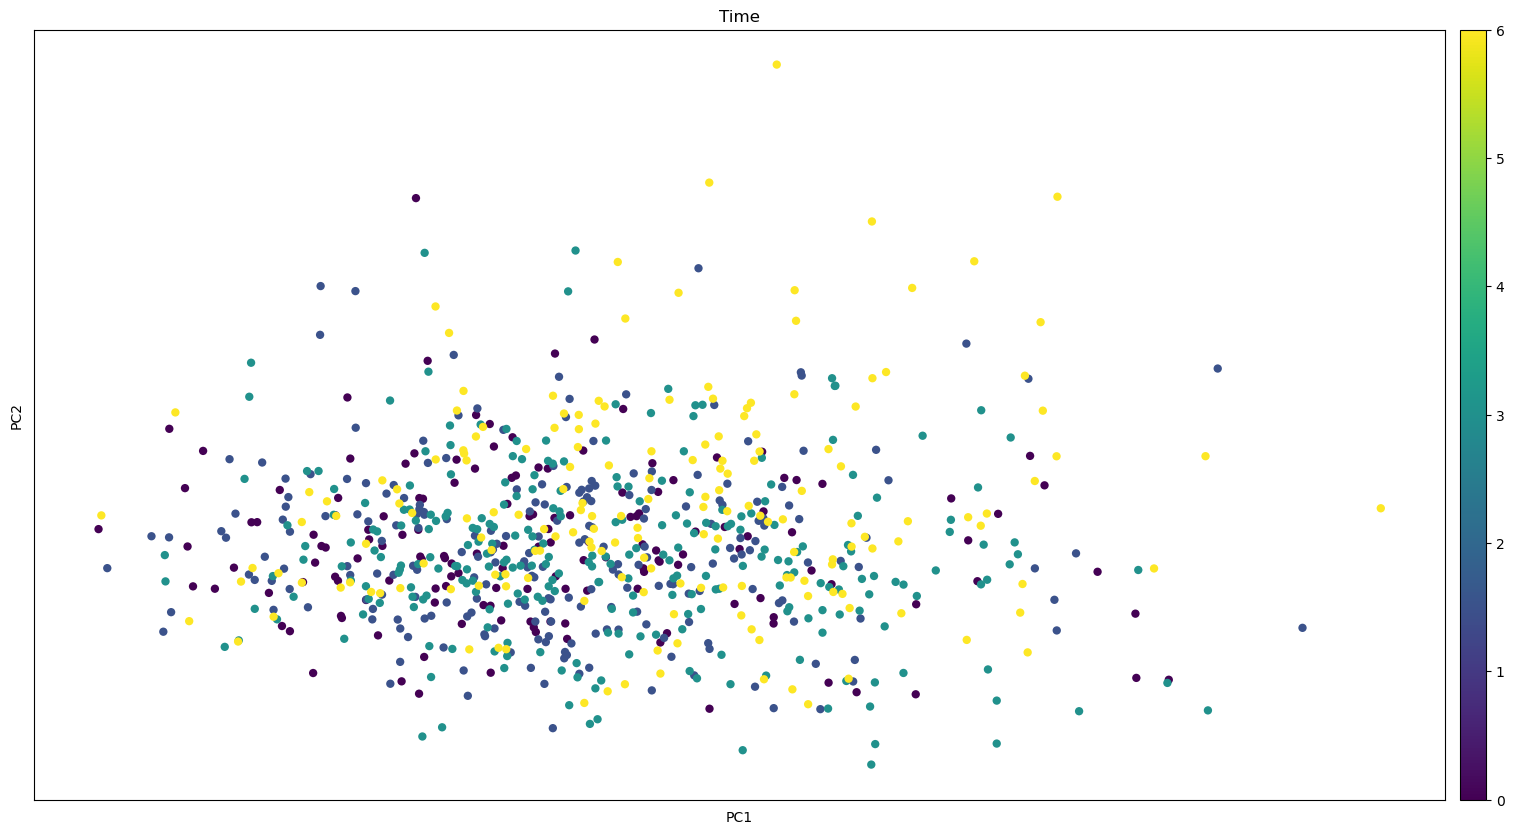

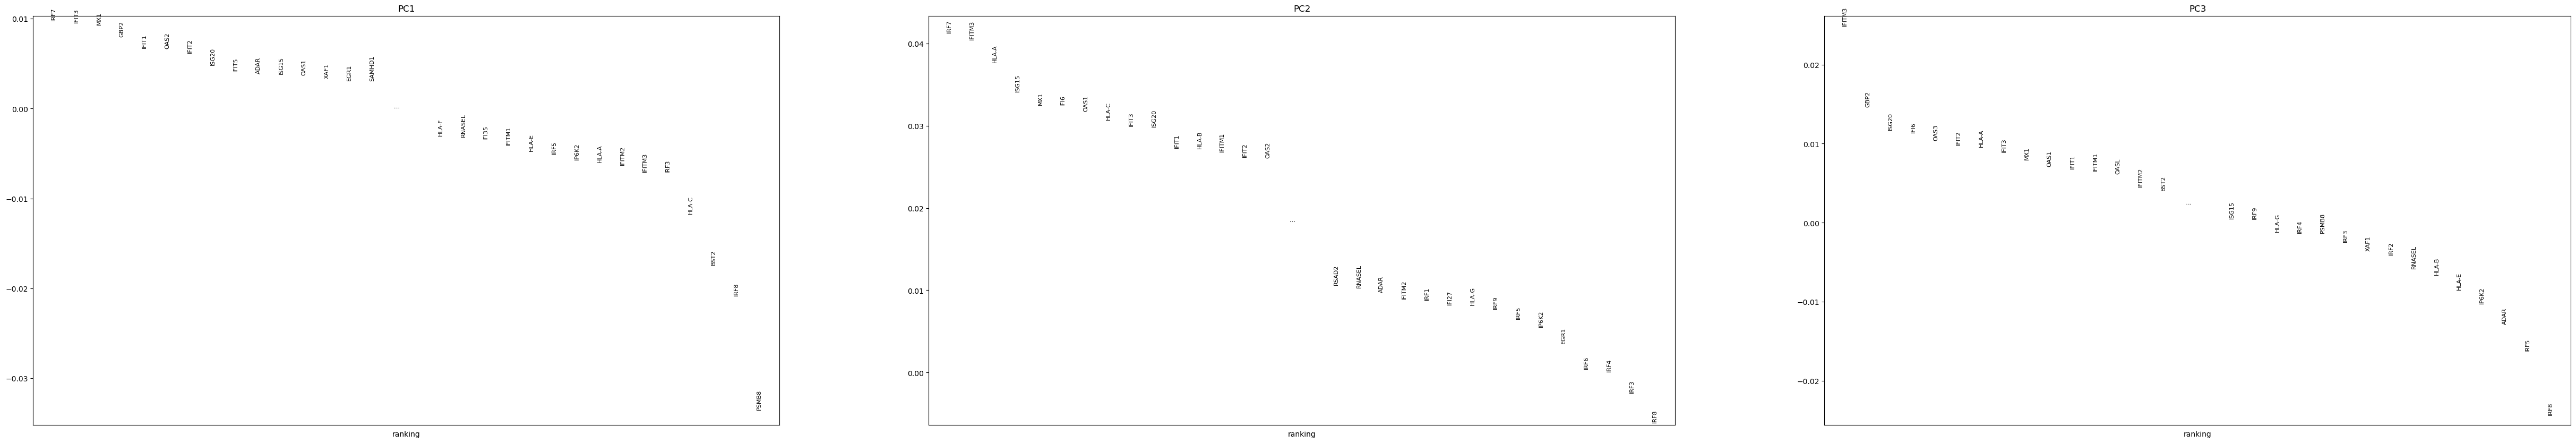

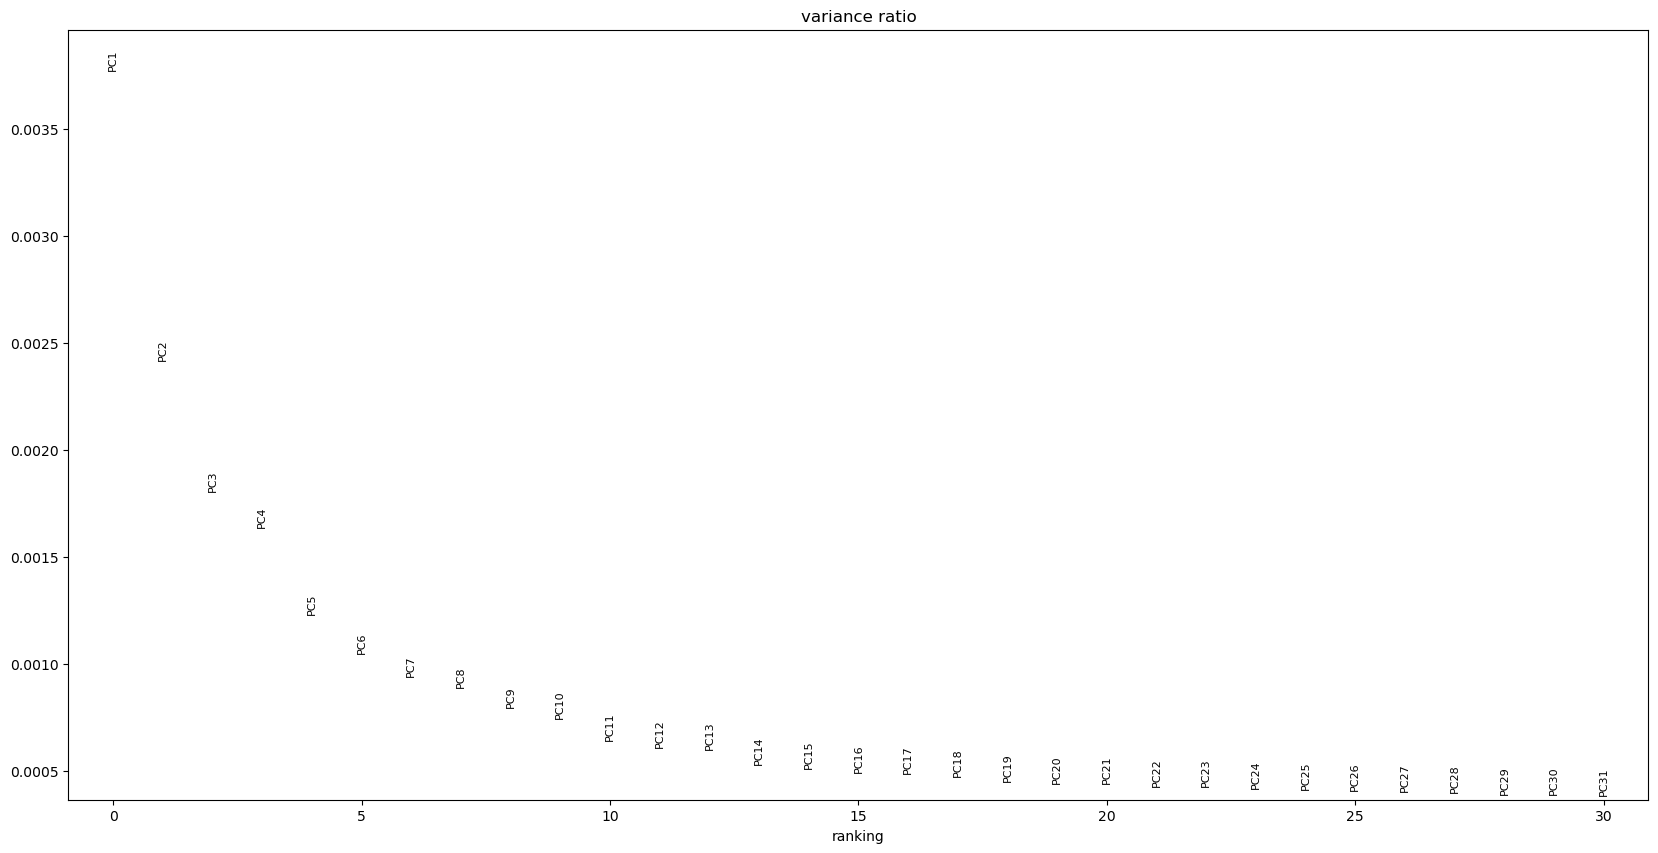

In [89]:
sc.pl.pca_overview(adata_selected, color="Time")

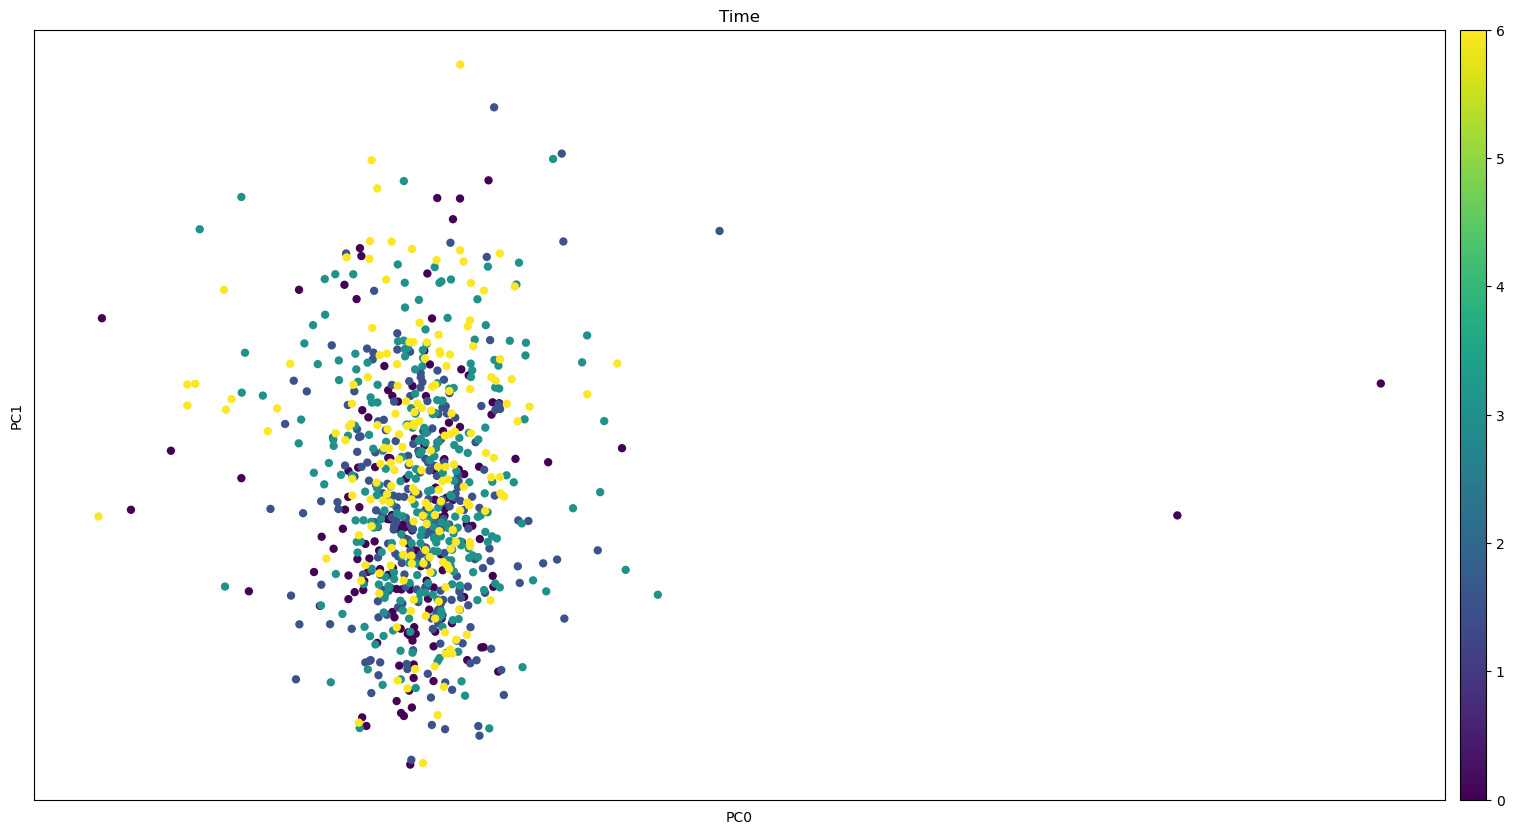

In [90]:
sc.pl.pca(adata_selected, color="Time", components=["0, 1"], save=True)

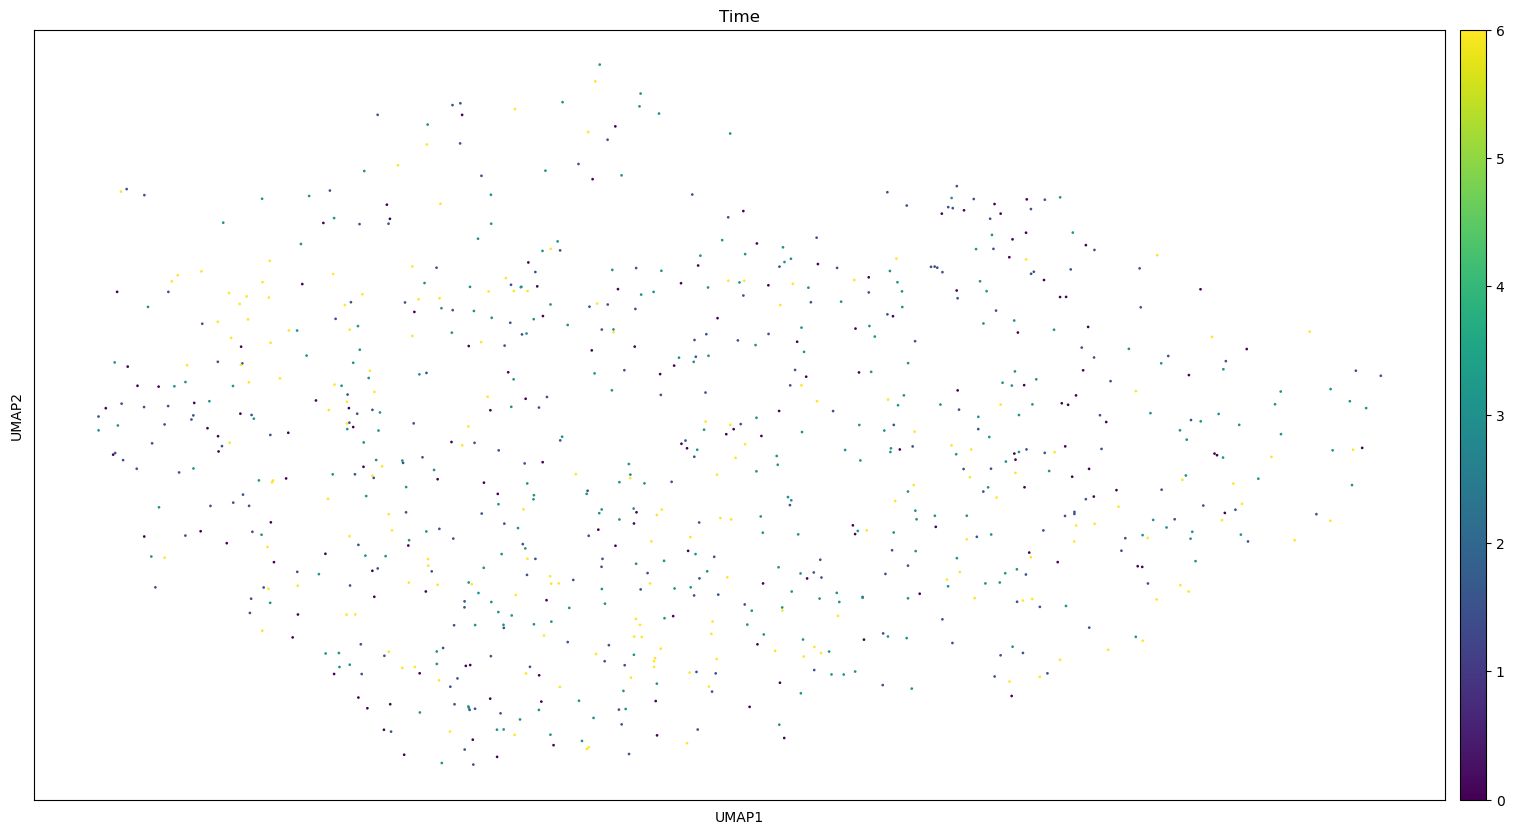

In [91]:
sc.pl.umap(adata_selected, color="Time", size=15)

# SVD

In [92]:
# SVD
eigengenes, s, eigensamples = svd(adata_selected.layers["scvi_normalized"], full_matrices=False)

## Plotting and fitting

            3            2
-0.0003291 x + 0.001889 x - 0.003414 x + 0.004256


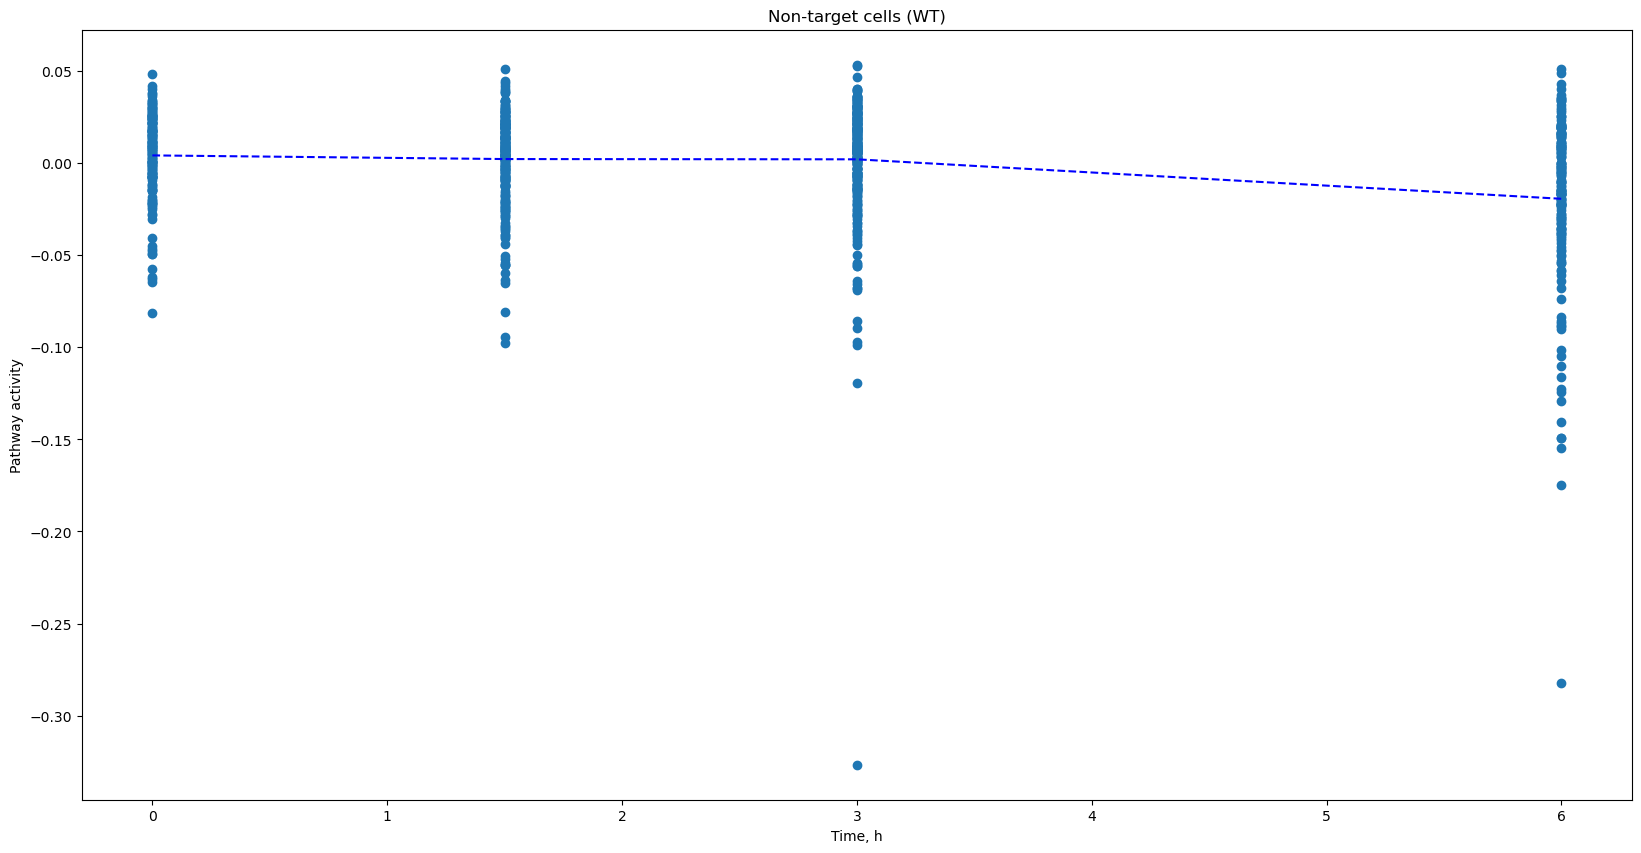

In [93]:
model4 = np.poly1d(np.polyfit(adata_selected.obs["Time"], eigengenes[:, 0], 3))
plt.scatter(adata_selected.obs["Time"], eigengenes[:, 0])
plt.plot(np.sort(adata_selected.obs["Time"]), model4(np.sort(adata_selected.obs["Time"])), '--', color='blue')
plt.title("Non-target cells (WT)")
plt.xlabel("Time, h")
plt.ylabel("Pathway activity")
print(model4)
plt.savefig("IFNA_IFNB_pathway_time_plot.png", dpi=300, bbox_inches='tight')

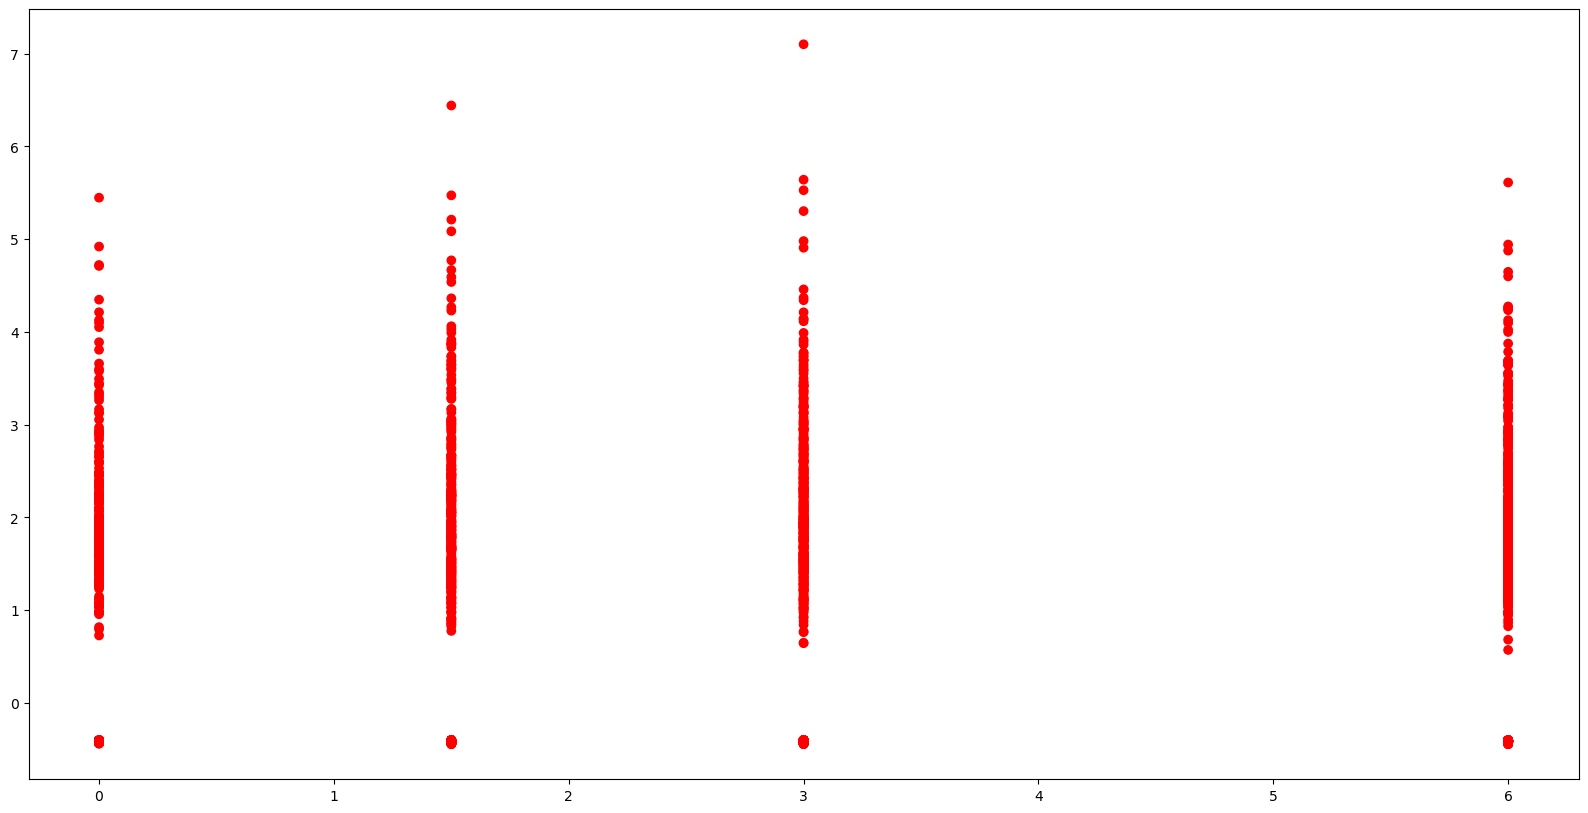

In [94]:
cols = {"Pooled": "red", "Arrayed": "blue"}
plt.scatter(adata[:, adata.var["features"] == "IRF1"].obs["Time"], 
            adata[:, adata.var["features"] == "IRF1"].X.toarray(),
           color=[cols[arr] for arr in adata[:, adata.var["features"] == "IRF1"].obs["Lenti"]])

(array([  3.,   9.,  28.,  43.,  65., 111., 208., 252., 319., 369., 443.,
        467., 498., 512., 512., 473., 477., 459., 412., 326., 297., 255.,
        220., 191., 165., 133., 114., 112.,  78.,  60.,  57.,  48.,  44.,
         32.,  32.,  33.,  24.,  17.,  17.,  14.,  14.,   9.,  11.,   7.,
          7.,   9.,   6.,   5.,  10.,   5.,   3.,   6.,   3.,   2.,   1.,
          3.,   1.,   4.,   2.,   0.,   3.,   3.,   2.,   1.,   1.,   2.,
          3.,   2.,   1.,   1.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-2.40787103e-05, -2.26357752e-05, -2.11928400e-05, -1.97499048e-05,
        -1.83069715e-05, -1.68640363e-05, -1.54211011e-05, -1.39781660e-05,
        -1.25352308e-05, -1.10922956e-05, -9.64936135e-06, -8.20642617e-06,
        -6.76349100e-06, -5.32055628e-06, -3.87762111e-06, -2.43468639e-06,
        -9.917

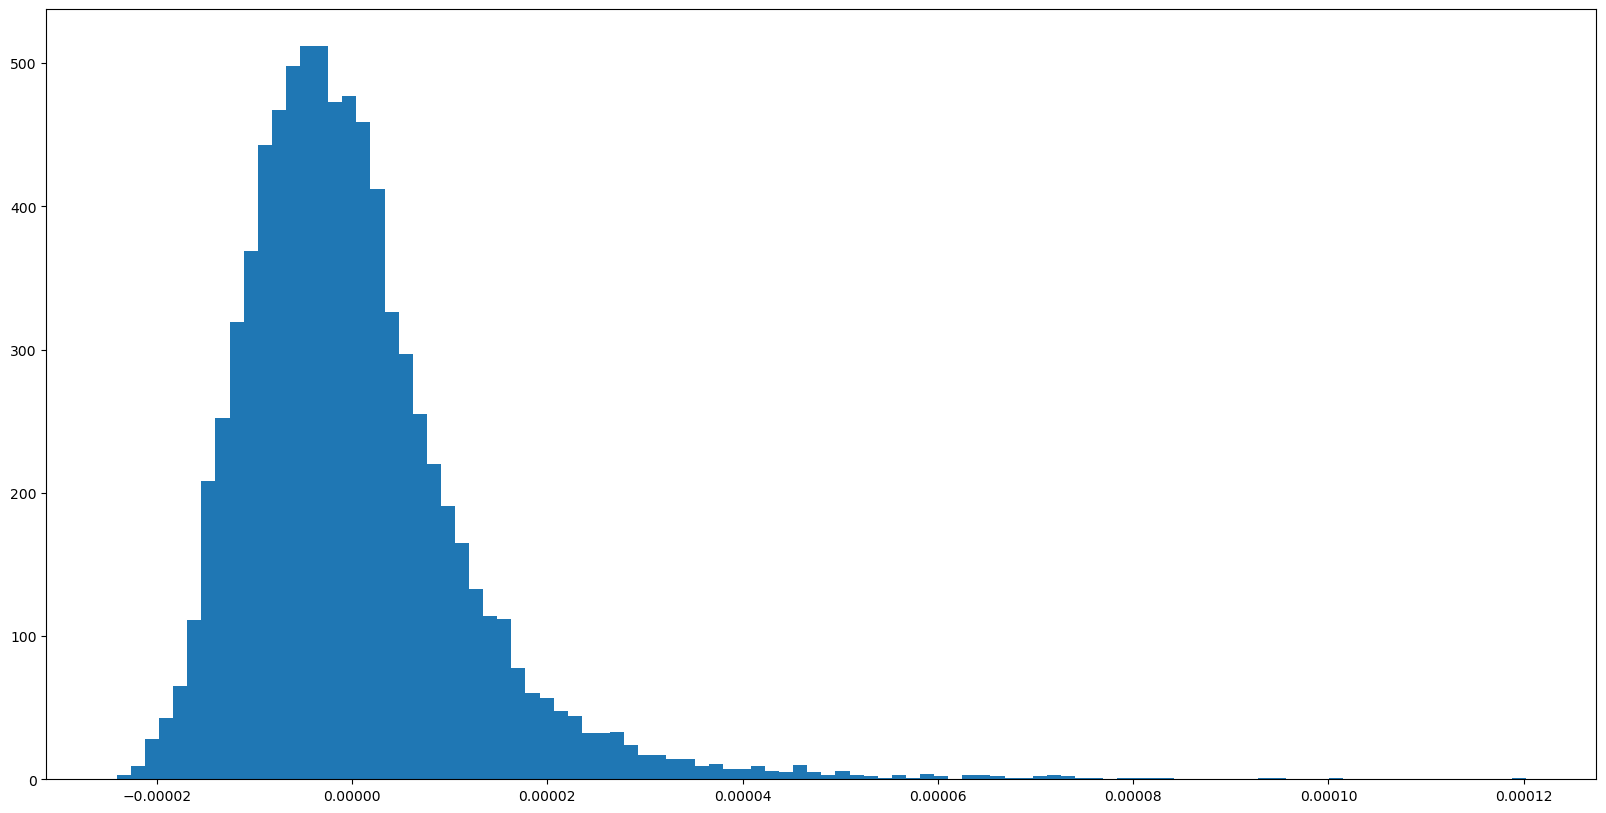

In [95]:
plt.hist( adata[:, adata.var["features"] == "IRF1"].layers["scvi_normalized"].toarray(), bins=100)

In [96]:
adata_selected.obs["Time"].shape

(834,)

/home/x_mamin/.conda/envs/lilliput_env/lib/python3.9/site-packages/numpy/core/function_base.py:164: ImplicitModificationWarning: Trying to modify attribute `.layers` of view, initializing view as actual.
  y[-1] = stop


(-0.07, 0.13)

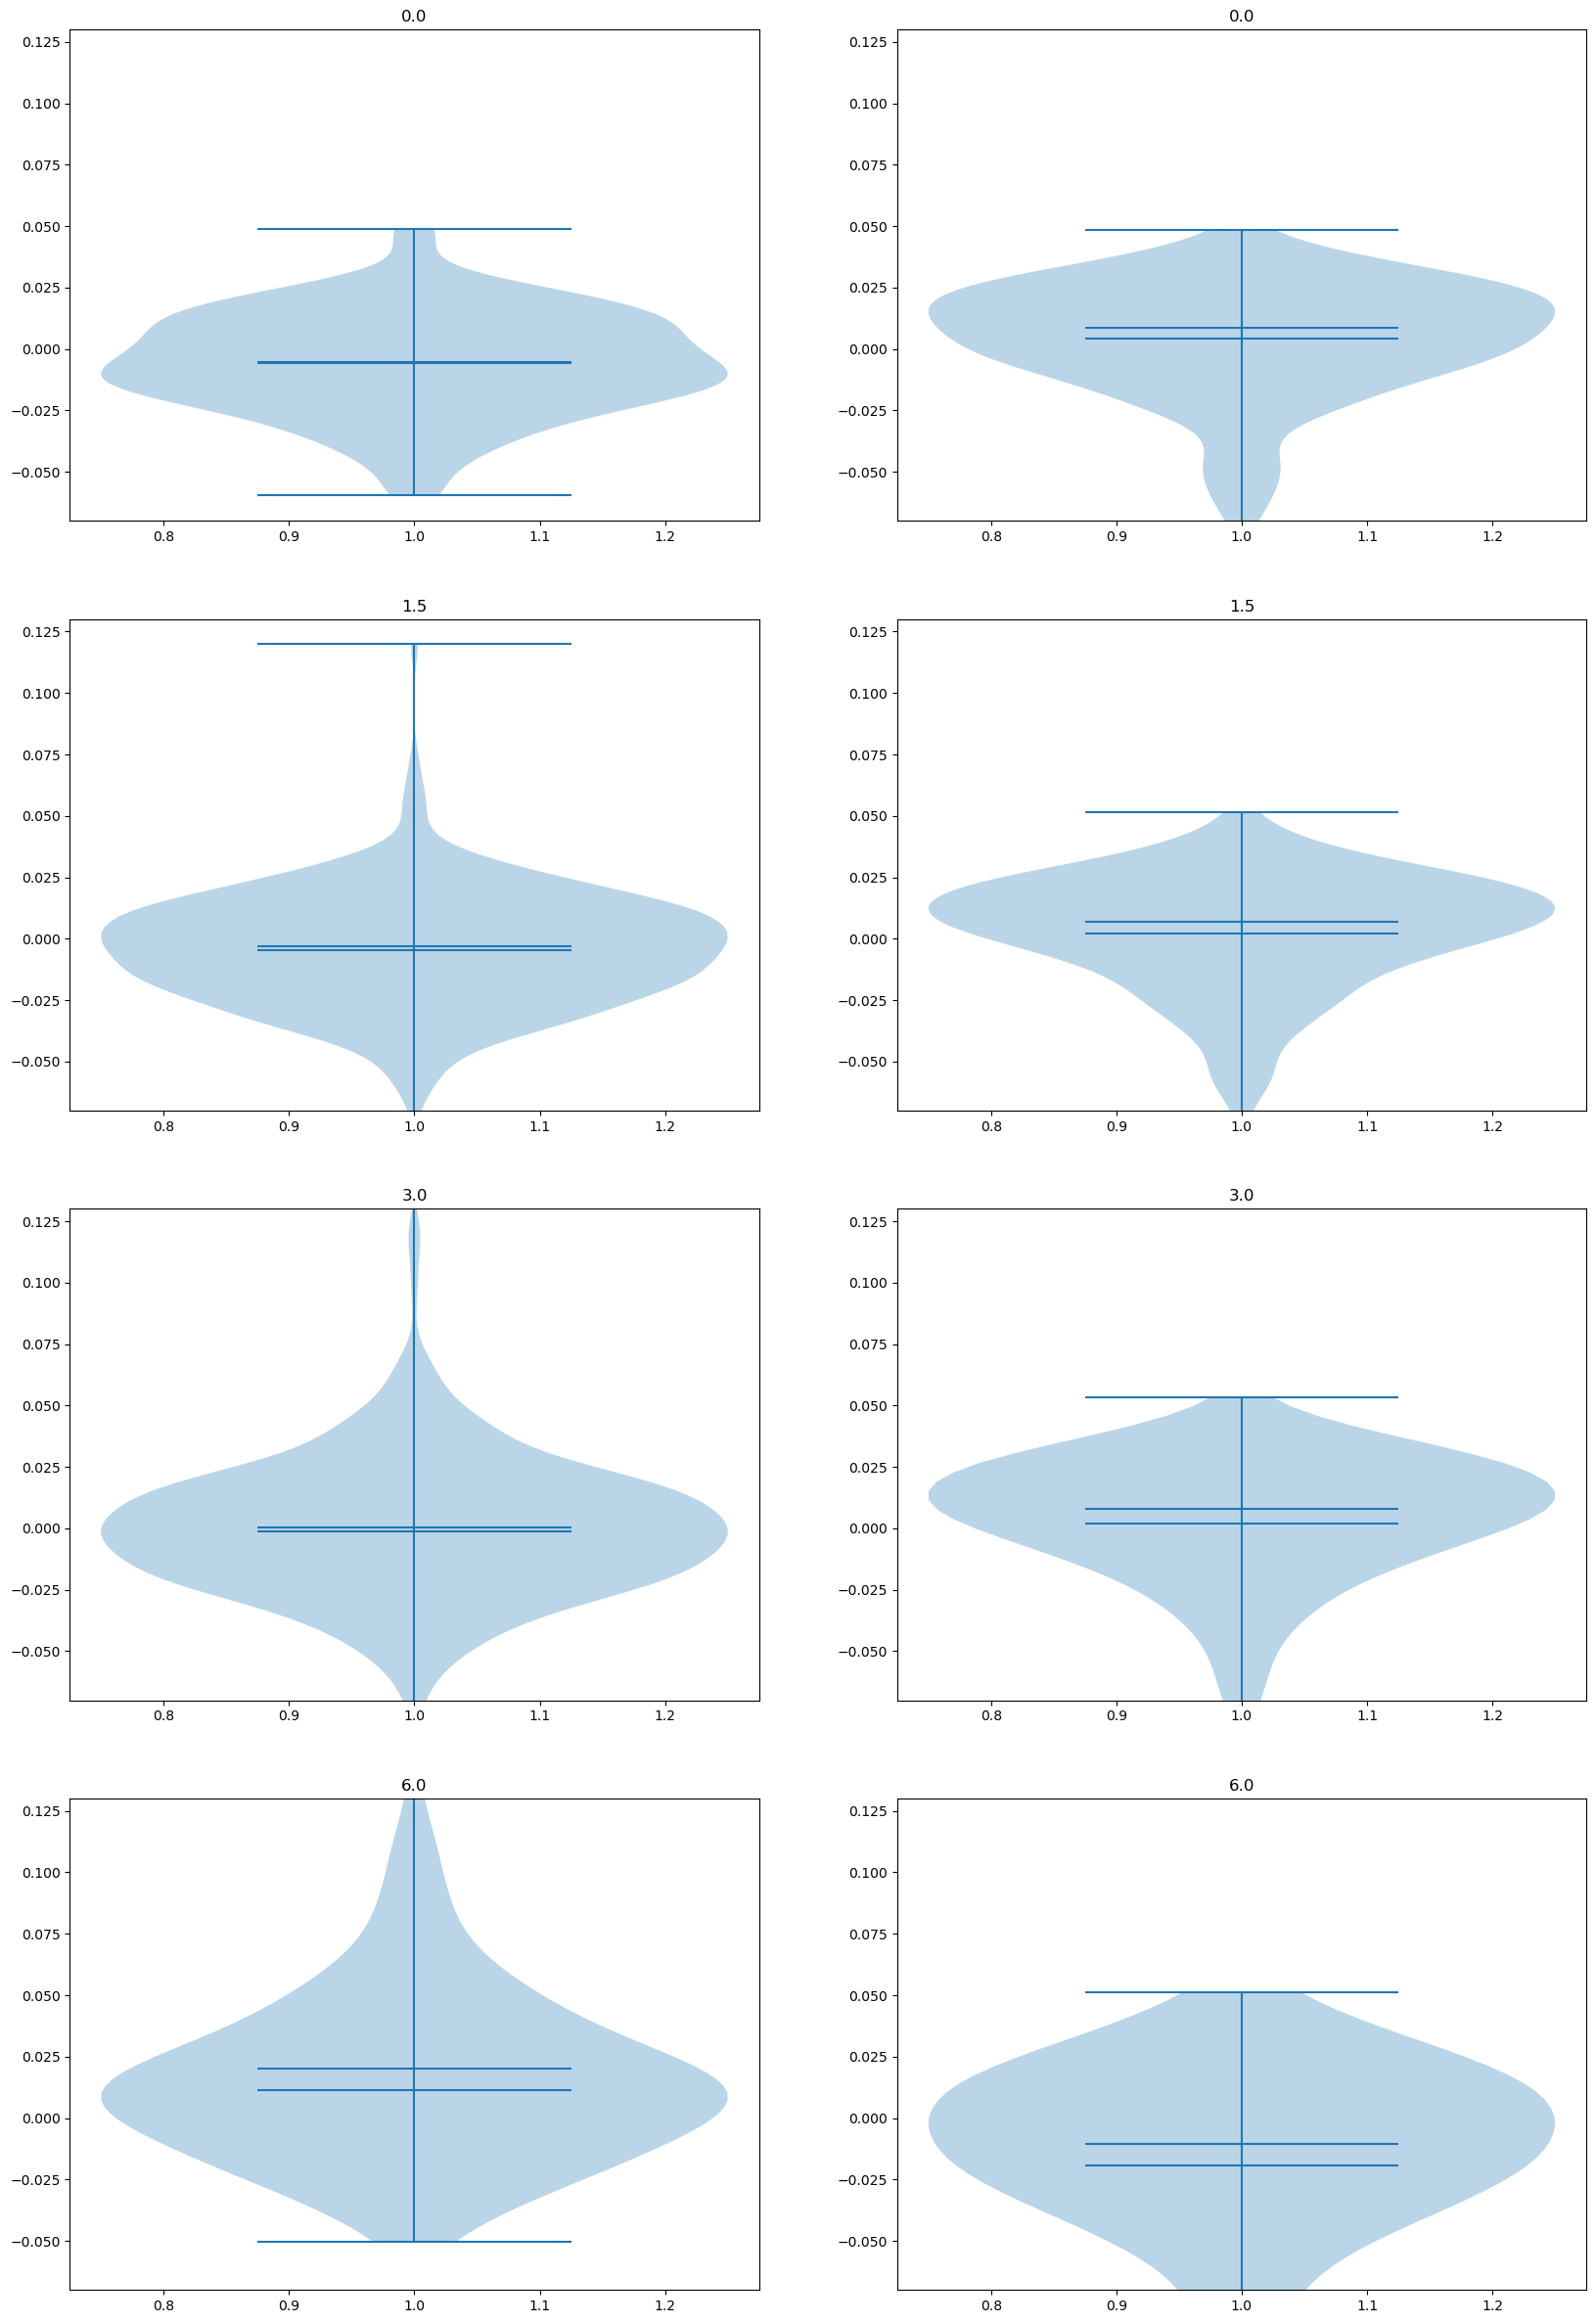

In [97]:
plt.rcParams['figure.figsize'] = [20, 30]
fig, axs = plt.subplots(4,2)
axs[0,0].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 0.0, 0], showmeans = True, showextrema = True, showmedians = True)
axs[0,0].set_title("0.0")
axs[0,0].set_ylim([-0.07, 0.13])
axs[0,1].violinplot(eigengenes[adata_selected.obs["Time"] == 0.0, 0], showmeans = True, showextrema = True, showmedians = True)
axs[0,1].set_title("0.0")
axs[0,1].set_ylim([-0.07, 0.13])

axs[1,0].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 1.5, 0], showmeans = True, showextrema = True, showmedians = True)
axs[1,0].set_title("1.5")
axs[1,0].set_ylim([-0.07, 0.13])
axs[1,1].violinplot(eigengenes[adata_selected.obs["Time"] == 1.5, 0], showmeans = True, showextrema = True, showmedians = True)
axs[1,1].set_title("1.5")
axs[1,1].set_ylim([-0.07, 0.13])

axs[2,0].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 3.0, 0], showmeans = True, showextrema = True, showmedians = True)
axs[2,0].set_title("3.0")
axs[2,0].set_ylim([-0.07, 0.13])
axs[2,1].violinplot(eigengenes[adata_selected.obs["Time"] == 3.0, 0], showmeans = True, showextrema = True, showmedians = True)
axs[2,1].set_title("3.0")
axs[2,1].set_ylim([-0.07, 0.13])

axs[3,0].violinplot(eigengenes_full[adata[sample_cells,0].obs["Time"] == 6.0, 0], showmeans = True, showextrema = True, showmedians = True)
axs[3,0].set_title("6.0")
axs[3,0].set_ylim([-0.07, 0.13])
axs[3,1].violinplot(eigengenes[adata_selected.obs["Time"] == 6.0, 0], showmeans = True, showextrema = True, showmedians = True)
axs[3,1].set_title("6.0")
axs[3,1].set_ylim([-0.07, 0.13])

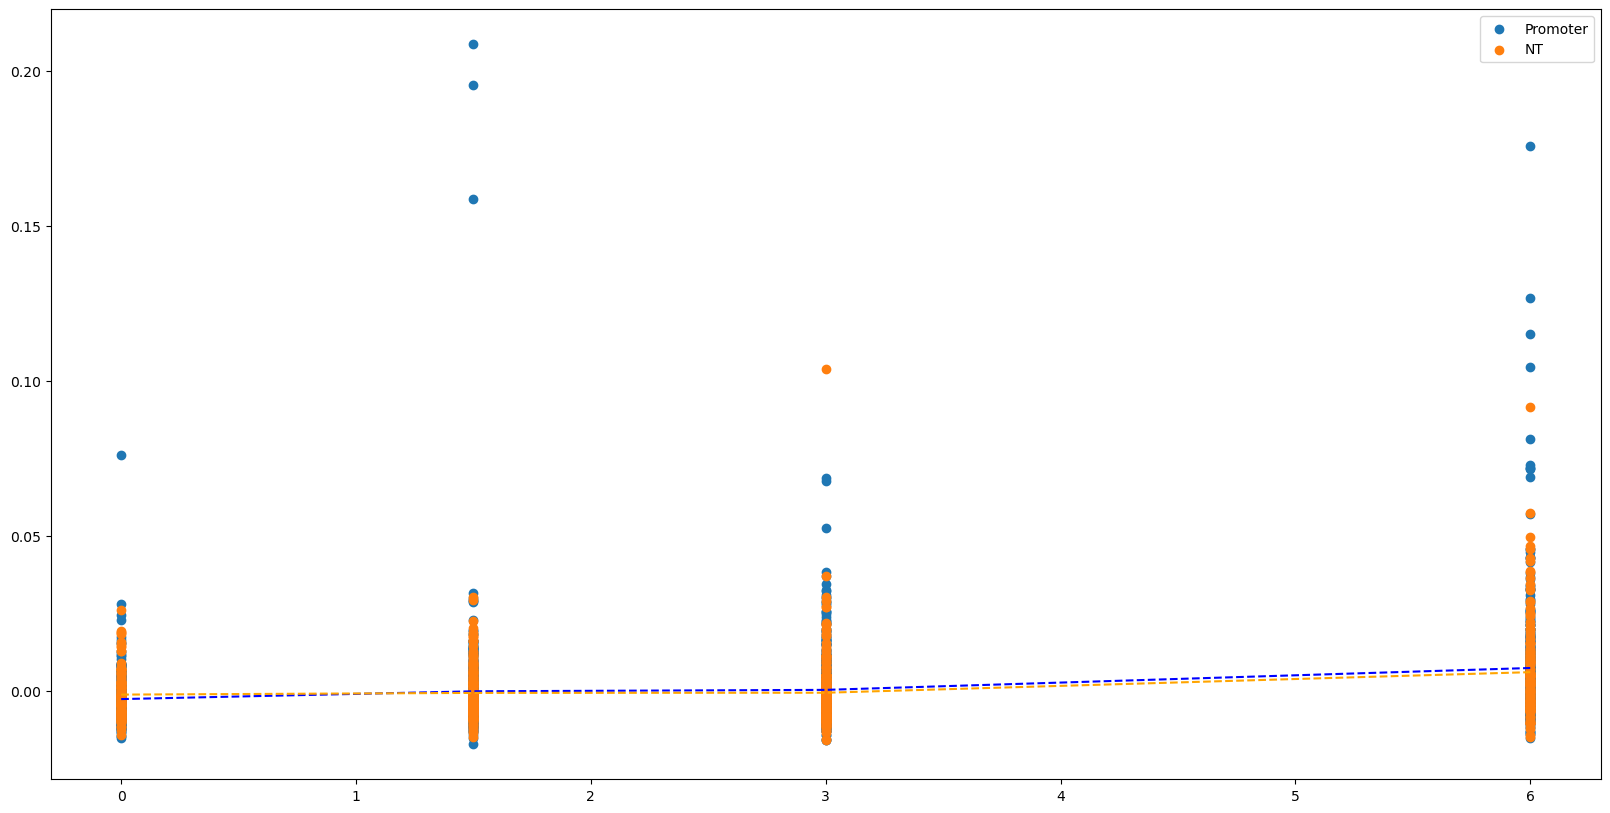

In [98]:
plt.rcParams['figure.figsize'] = [20, 10]
#adata_selected = adata[adata.obs["Lenti"] == "Pooled"]
adata_selected = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["REACTOME_INTERFERON_ALPHA_BETA_SIGNALING"]]]
#adata_selected = adata_selected.copy().T
eigengenes, s, eigensamples = svd(adata_selected.layers["scvi_normalized"], full_matrices=False)
model4 = np.poly1d(np.polyfit(adata_selected[adata_selected.obs["NT"] == "IRF1-promoter"].obs["Time"], 
            eigengenes[np.where(adata_selected.obs["NT"] == "IRF1-promoter")[0], 0], 3))
model_nt4 = np.poly1d(np.polyfit(adata_selected[adata_selected.obs["NT"] == "NT"].obs["Time"], 
            eigengenes[np.where(adata_selected.obs["NT"] == "NT")[0], 0], 3))

plt.scatter(adata_selected[adata_selected.obs["NT"] == "IRF1-promoter"].obs["Time"], 
            eigengenes[np.where(adata_selected.obs["NT"] == "IRF1-promoter")[0], 0])
plt.scatter(adata_selected[adata_selected.obs["NT"] == "NT"].obs["Time"], 
            eigengenes[np.where(adata_selected.obs["NT"] == "NT")[0], 0])

plt.plot(np.sort(adata_selected[adata_selected.obs["NT"] == "IRF1-promoter"].obs["Time"]), 
         model4(np.sort(adata_selected[adata_selected.obs["NT"] == "IRF1-promoter"].obs["Time"])), 
         '--', color='blue')
plt.plot(np.sort(adata_selected[adata_selected.obs["NT"] == "NT"].obs["Time"]), 
         model_nt4(np.sort(adata_selected[adata_selected.obs["NT"] == "NT"].obs["Time"])), '--', color='orange')
plt.legend(["Promoter", "NT"])

In [99]:
sample = np.where(eigengenes[:, 0] > 0.1)
sample = [i for i in sample[0] if adata_selected.obs["Time"][i] == 6.0]
sample

[2393, 2409, 2637, 2798, 2830, 5123, 6705]

In [100]:
adata_selected.X.shape

(8064, 59)

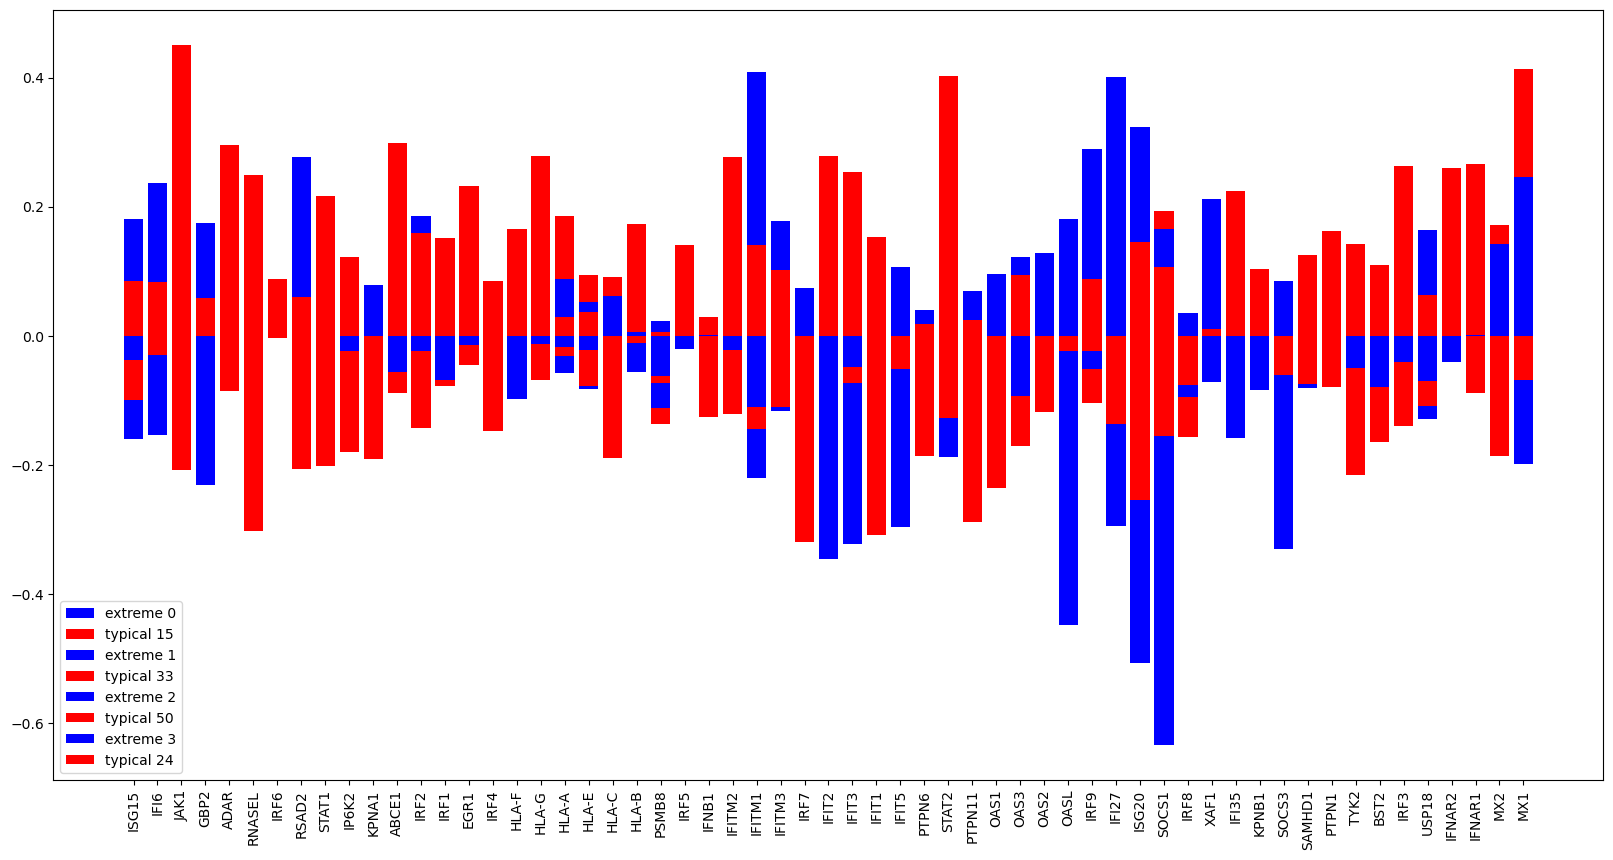

In [101]:
extreme_cells = adata_selected.X[sample, :]
typ_index = [i for i in range(adata_selected.X.shape[0]) if i not in sample]
typical_cells = adata_selected.X[typ_index and adata_selected.obs["Time"] == 6.0, :]
eigengenes_extreme, s_extreme, eigensamples_extreme = svd(extreme_cells, full_matrices=False, compute_uv=True)
eigengenes_typical, s_typical, eigensamples_typical = svd(typical_cells, full_matrices=False, compute_uv=True)

chosen_cells = np.random.randint(0, eigensamples_typical.shape[0], 4)
for samp in zip(range(eigensamples_extreme.shape[0]), chosen_cells):
    plt.bar(adata_selected.var["features"], eigensamples_extreme[samp[0], :], color="blue", label="extreme {}".format(samp[0]))
    plt.bar(adata_selected.var["features"], eigensamples_typical[samp[1], :], color="red", label="typical {}".format(samp[1]))
    plt.xticks(rotation = 90)
    plt.legend()
plt.show()

In [102]:
temp = {gene: np.abs(np.mean(eigensamples_extreme - eigensamples_typical[chosen_cells, :], axis=0))[i] for i, gene in enumerate(adata_selected.var["features"])}
sorted(temp.items(), key=lambda item: item[1])

ValueError: operands could not be broadcast together with shapes (7,59) (4,59) 

## Separate plots for different perturbations

### NFkB pathway

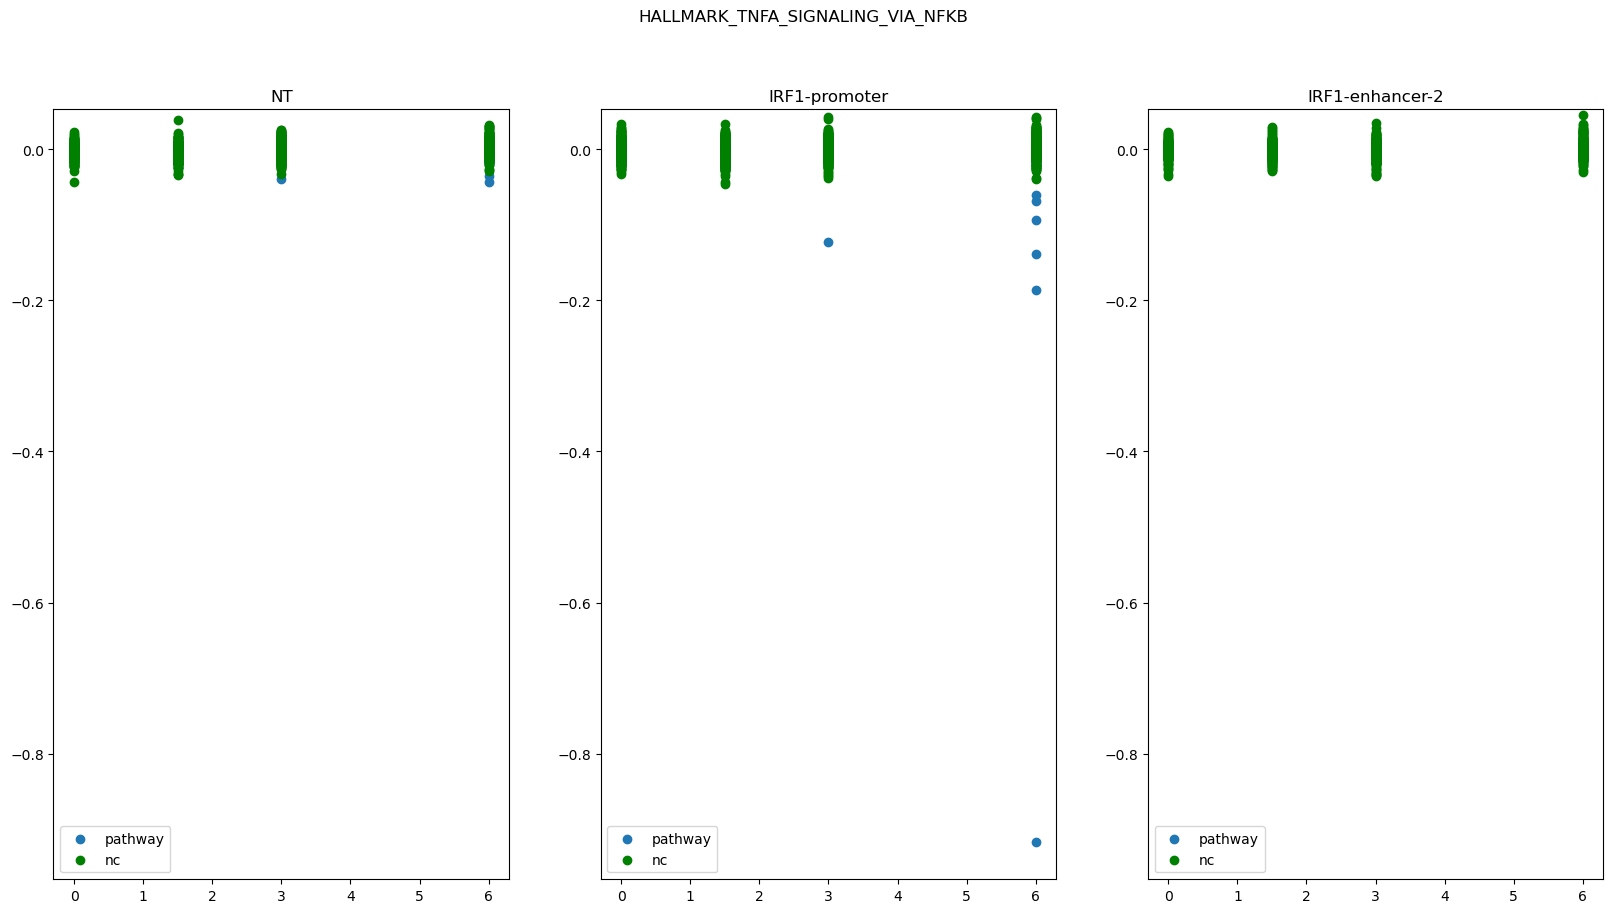

In [103]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.suptitle("HALLMARK_TNFA_SIGNALING_VIA_NFKB")

adata_selected = adata[adata.obs["Lenti"] == "Pooled"]
adata_selected = adata_selected[:, [ind for ind, g in enumerate(adata_selected.var["features"]) 
                                    if g in genes["HALLMARK_TNFA_SIGNALING_VIA_NFKB"]]]

adata_selected_nc = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["HSIAO_HOUSEKEEPING_GENES"]]]


group = ["NT", "IRF1-promoter", 'IRF1-enhancer-2'] #, 'IRF1-enhancer-M', 'IRF1-enhancer-3', 'IRF1-enhancer-4']



# svd
eigengenes, s, eigensamples = svd(adata_selected.layers["scvi_normalized"], full_matrices=False)
eigengenes_nc, s_nc, eigensamples_nc = svd(adata_selected_nc.layers["scvi_normalized"], full_matrices=False)


for g in zip(group, (ax1, ax2, ax3)):
    # Selecting perturbation
    cell_index = np.where(adata_selected.obs["NT"] == g[0])[0]
    cell_index_nc = np.where(adata_selected_nc.obs["NT"] == g[0])[0]
    
    # model fitting
    model4 = np.poly1d(np.polyfit(adata_selected[cell_index].obs["Time"], 
                                  eigengenes[cell_index, 0], 3))
    model4_nc = np.poly1d(np.polyfit(adata_selected_nc[cell_index_nc].obs["Time"], 
                                     eigengenes_nc[cell_index_nc, 0], 3))
    
    # plotting
    g[1].scatter(adata_selected[cell_index].obs["Time"], 
                 eigengenes[cell_index, 0])
    g[1].scatter(adata_selected_nc[cell_index_nc].obs["Time"], 
                 eigengenes_nc[cell_index_nc, 0], color="green")
    
    #g[1].plot(np.sort(adata_selected_group.obs["Time"]), model4(np.sort(adata_selected_group.obs["Time"])), '--', color='blue')
    #g[1].plot(np.sort(adata_selected_group_nc.obs["Time"]), model4_nc(np.sort(adata_selected_group_nc.obs["Time"])), '--', color='green')
    
    g[1].set_title(g[0])
    g[1].set_ylim([np.min(eigengenes[:, 0]) - 0.05, np.max(eigengenes[:, 0]) + 0.05])
    g[1].legend(['pathway', 'nc'])#, 'pathway', 'nc'])
plt.show()

In [104]:
# do pca together for nt prom, enh2

#### Track pert effect

DescribeResult(nobs=834, minmax=(-0.042677682, 0.0026740045), mean=-0.00023412182, variance=1.4345506798975044e-05, skewness=-5.584778749753717, kurtosis=45.95655295816147)
DescribeResult(nobs=1809, minmax=(-0.91629165, 0.0029534919), mean=-0.0007583652, variance=0.000519201671691772, skewness=-36.456358536012836, kurtosis=1443.144926177694)
DescribeResult(nobs=689, minmax=(-0.033721764, 0.0029507447), mean=0.00037055524, variance=7.381981708534979e-06, skewness=-5.329109858013109, kurtosis=45.50129606621598)


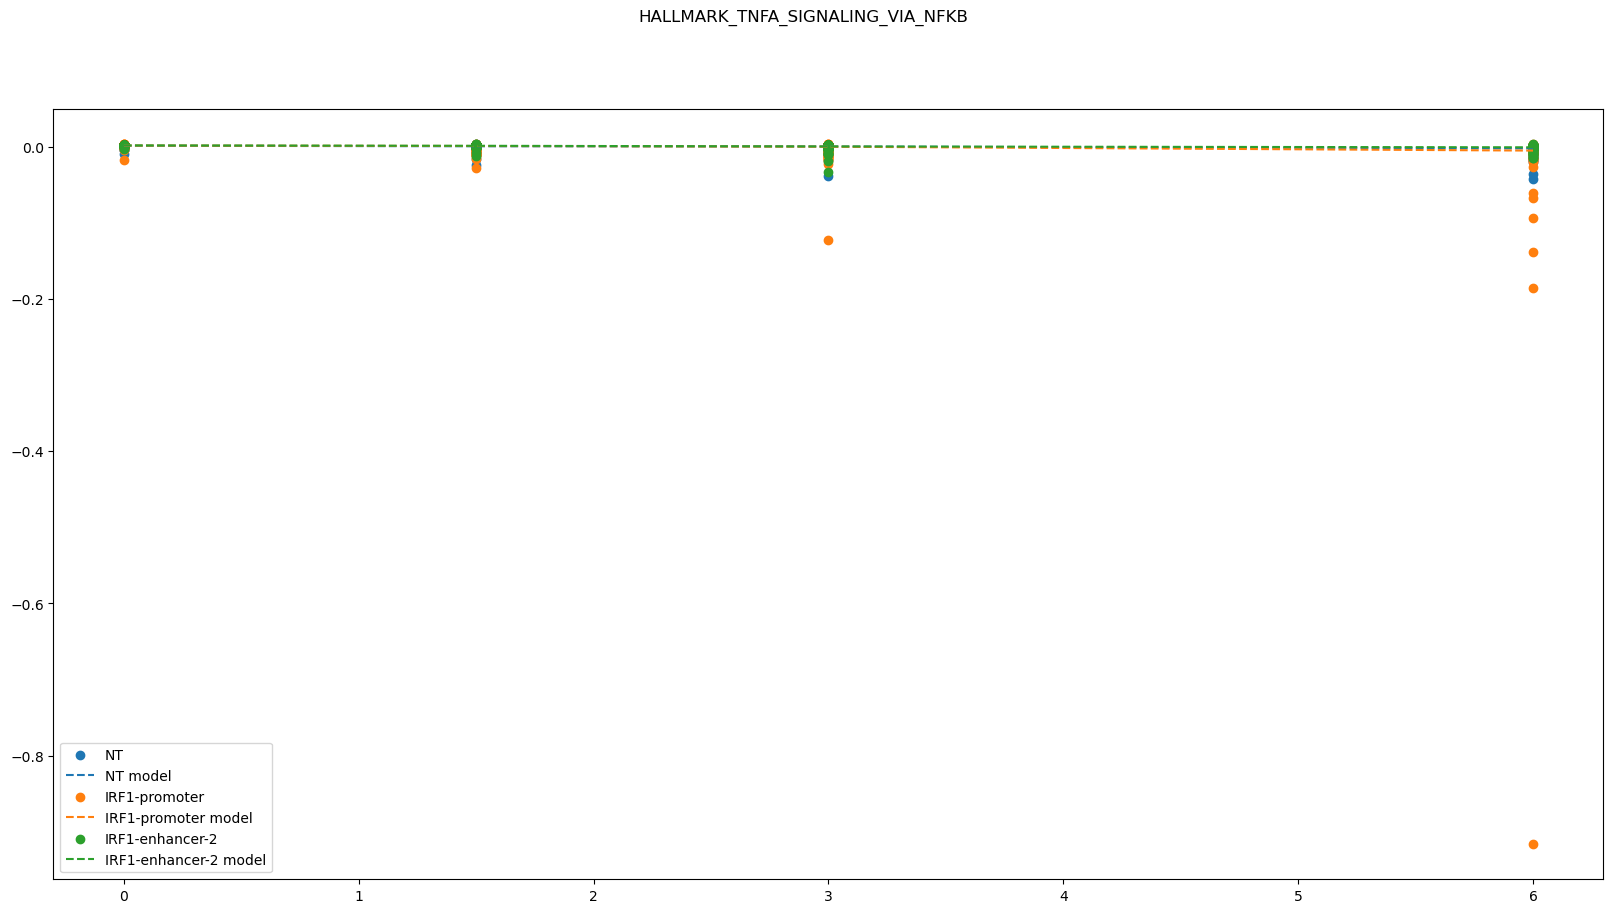

In [105]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(ncols=1)
fig.suptitle("HALLMARK_TNFA_SIGNALING_VIA_NFKB")

#adata_selected = adata[adata.obs["Lenti"] == "Pooled"]
adata_selected = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["HALLMARK_TNFA_SIGNALING_VIA_NFKB"]]]

adata_selected_nc = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["HSIAO_HOUSEKEEPING_GENES"]]]


group = ["NT", "IRF1-promoter", 'IRF1-enhancer-2'] #, 'IRF1-enhancer-M', 'IRF1-enhancer-3', 'IRF1-enhancer-4']

to_test = []
to_time = []


# svd
eigengenes, s, eigensamples = svd(adata_selected.layers["scvi_normalized"], full_matrices=False)
eigengenes_nc, s_nc, eigensamples_nc = svd(adata_selected_nc.layers["scvi_normalized"], full_matrices=False)


for g in zip(group):
    # Selecting perturbation
    cell_index = np.where(adata_selected.obs["NT"] == g[0])[0]
    cell_index_nc = np.where(adata_selected_nc.obs["NT"] == g[0])[0]
    # model fitting
    model4 = np.poly1d(np.polyfit(adata_selected[cell_index].obs["Time"], 
                                  eigengenes[cell_index, 0], 3))
    model4_nc = np.poly1d(np.polyfit(adata_selected_nc[cell_index_nc].obs["Time"], 
                                     eigengenes_nc[cell_index_nc, 0], 3))
    
    # plotting
    ax.scatter(adata_selected[cell_index].obs["Time"], eigengenes[cell_index, 0], label=g[0])
    print(stats.describe(eigengenes[cell_index, 0]))
    to_time.append(adata_selected[cell_index].obs["Time"])
    to_test.append(eigengenes[cell_index, 0])
    ax.plot(np.sort(adata_selected[cell_index].obs["Time"]), 
            model4(np.sort(adata_selected[cell_index].obs["Time"])), '--', label=g[0] + " model")
    
ax.legend()
plt.show()

## TNFR2 non-canonical pathway

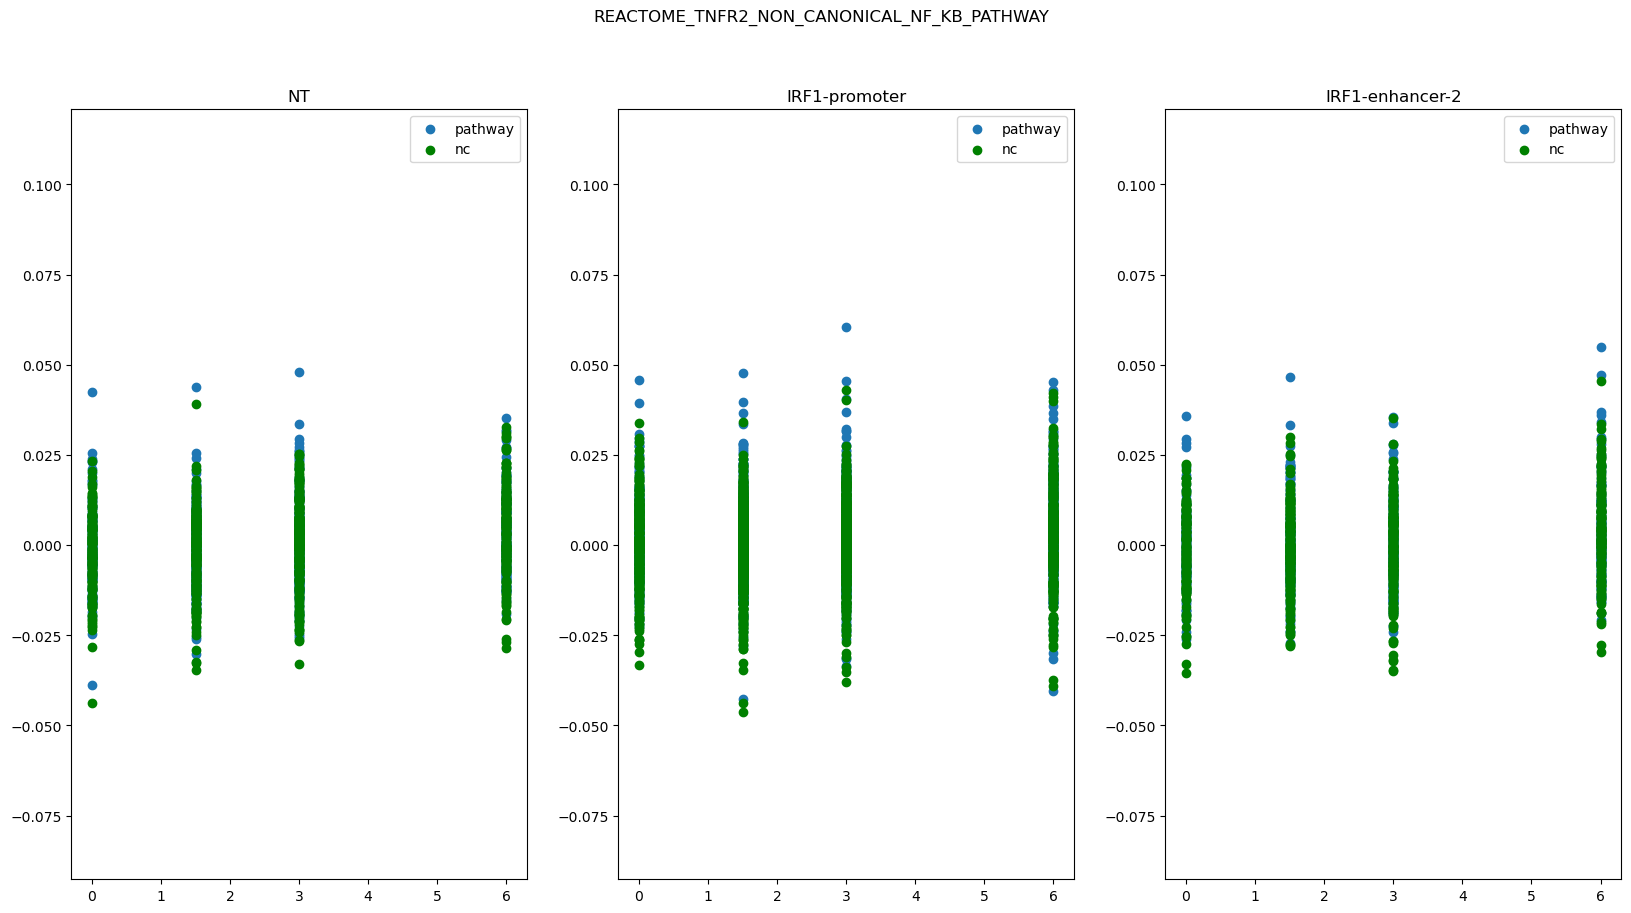

In [106]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.suptitle("REACTOME_TNFR2_NON_CANONICAL_NF_KB_PATHWAY")

adata_selected = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["REACTOME_TNFR2_NON_CANONICAL_NF_KB_PATHWAY"]]]


adata_selected_nc = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["HSIAO_HOUSEKEEPING_GENES"]]]


group = ["NT", "IRF1-promoter", 'IRF1-enhancer-2'] #, 'IRF1-enhancer-M', 'IRF1-enhancer-3', 'IRF1-enhancer-4']



# svd
eigengenes, s, eigensamples = svd(adata_selected.layers["scvi_normalized"], full_matrices=False)
eigengenes_nc, s_nc, eigensamples_nc = svd(adata_selected_nc.layers["scvi_normalized"], full_matrices=False)


for g in zip(group, (ax1, ax2, ax3)):
    # Selecting perturbation
    cell_index = np.where(adata_selected.obs["NT"] == g[0])[0]
    cell_index_nc = np.where(adata_selected_nc.obs["NT"] == g[0])[0]
    
    # model fitting
    model4 = np.poly1d(np.polyfit(adata_selected[cell_index].obs["Time"], 
                                  eigengenes[cell_index, 0], 3))
    model4_nc = np.poly1d(np.polyfit(adata_selected_nc[cell_index_nc].obs["Time"], 
                                     eigengenes_nc[cell_index_nc, 0], 3))
    
    # plotting
    g[1].scatter(adata_selected[cell_index].obs["Time"], 
                 eigengenes[cell_index, 0])
    g[1].scatter(adata_selected_nc[cell_index_nc].obs["Time"], 
                 eigengenes_nc[cell_index_nc, 0], color="green")
    
    #g[1].plot(np.sort(adata_selected_group.obs["Time"]), model4(np.sort(adata_selected_group.obs["Time"])), '--', color='blue')
    #g[1].plot(np.sort(adata_selected_group_nc.obs["Time"]), model4_nc(np.sort(adata_selected_group_nc.obs["Time"])), '--', color='green')
    
    g[1].set_title(g[0])
    g[1].set_ylim([np.min(eigengenes[:, 0]) - 0.05, np.max(eigengenes[:, 0]) + 0.05])
    g[1].legend(['pathway', 'nc'])#, 'pathway', 'nc'])
plt.show()

## IFNA/IFNB signaling

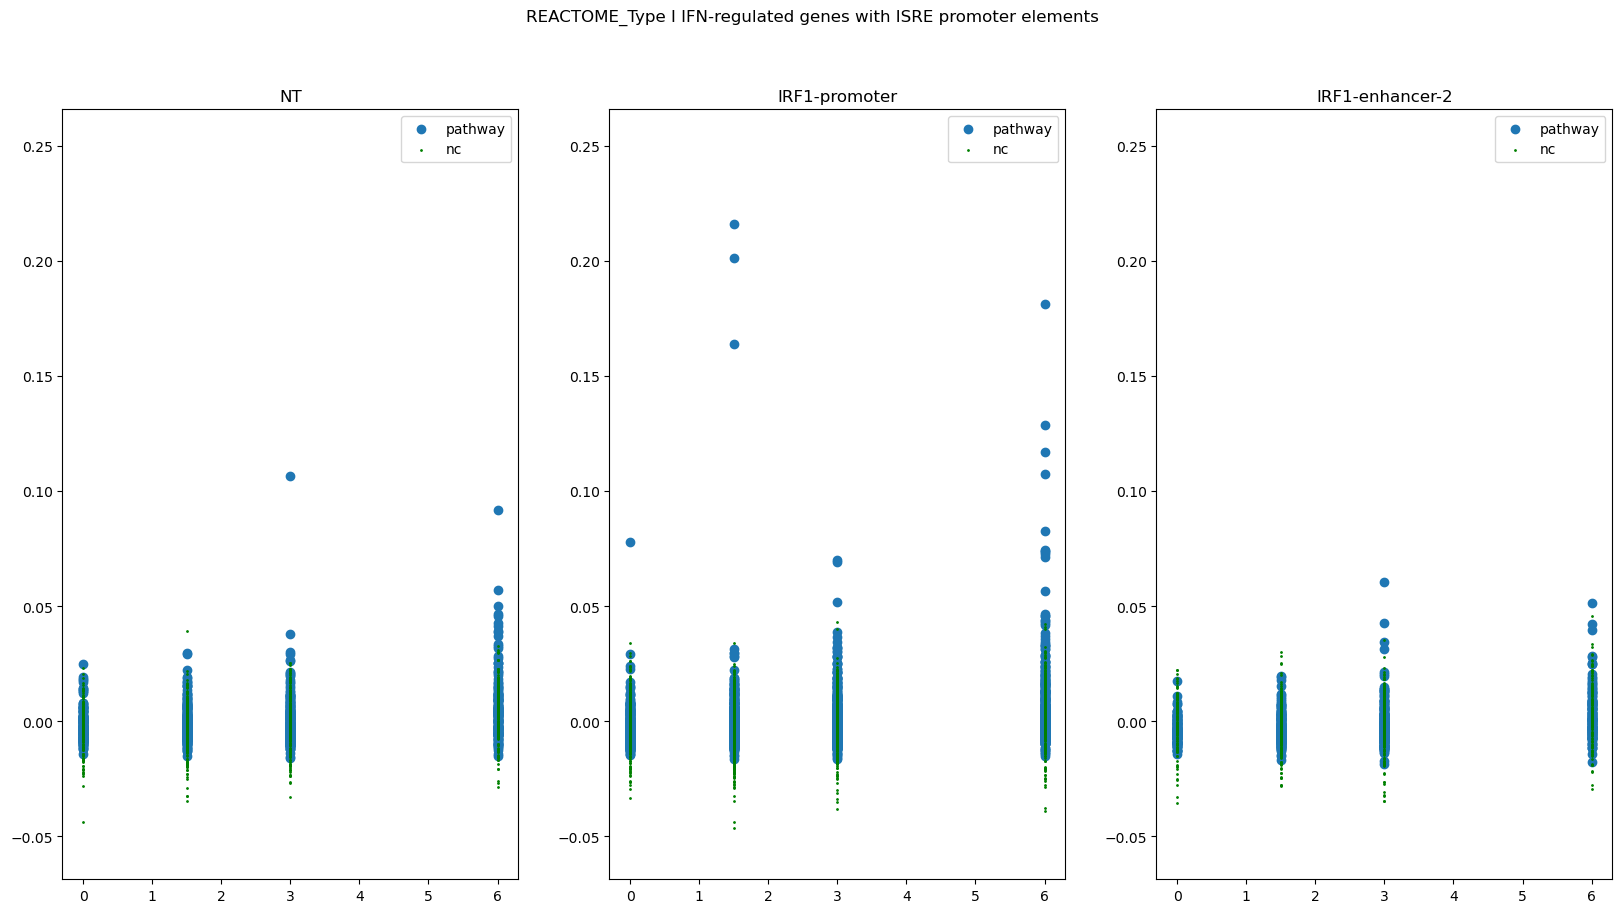

In [112]:
plt.rcParams['figure.figsize'] = [20, 10]
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.suptitle("REACTOME_Type I IFN-regulated genes with ISRE promoter elements")

adata_selected = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["REACTOME_Type I IFN-regulated genes with ISRE promoter elements"]]]


adata_selected_nc = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["HSIAO_HOUSEKEEPING_GENES"]]]


group = ["NT", "IRF1-promoter", 'IRF1-enhancer-2'] #, 'IRF1-enhancer-M', 'IRF1-enhancer-3', 'IRF1-enhancer-4']



# svd
eigengenes, s, eigensamples = svd(adata_selected.layers["scvi_normalized"], full_matrices=False)
eigengenes_nc, s_nc, eigensamples_nc = svd(adata_selected_nc.layers["scvi_normalized"], full_matrices=False)


for g in zip(group, (ax1, ax2, ax3)):
    # Selecting perturbation
    cell_index = np.where(adata_selected.obs["NT"] == g[0])[0]
    cell_index_nc = np.where(adata_selected_nc.obs["NT"] == g[0])[0]
    
    # model fitting
    model4 = np.poly1d(np.polyfit(adata_selected[cell_index].obs["Time"], 
                                  eigengenes[cell_index, 0], 3))
    model4_nc = np.poly1d(np.polyfit(adata_selected_nc[cell_index_nc].obs["Time"], 
                                     eigengenes_nc[cell_index_nc, 0], 3))
    
    # plotting
    g[1].scatter(adata_selected[cell_index].obs["Time"], 
                 eigengenes[cell_index,0])
    g[1].scatter(adata_selected_nc[cell_index_nc].obs["Time"], 
                 eigengenes_nc[cell_index_nc,0], color="green", s=1)
    
    #g[1].plot(np.sort(adata_selected_group.obs["Time"]), model4(np.sort(adata_selected_group.obs["Time"])), '--', color='blue')
    #g[1].plot(np.sort(adata_selected_group_nc.obs["Time"]), model4_nc(np.sort(adata_selected_group_nc.obs["Time"])), '--', color='green')
    
    g[1].set_title(g[0])
    g[1].set_ylim([np.min(eigengenes[:, 0]) - 0.05, np.max(eigengenes[:, 0]) + 0.05])
    g[1].legend(['pathway', 'nc'])#, 'pathway', 'nc'])
plt.show()

#### Track pert effect

DescribeResult(nobs=834, minmax=(-0.015732577, 0.10662773), mean=0.000596109, variance=0.00011344459993733453, skewness=3.206467466911973, kurtosis=20.486837816944032)
DescribeResult(nobs=1809, minmax=(-0.016416548, 0.21601553), mean=0.0011071383, variance=0.00021434289172135416, skewness=6.784396672779393, kurtosis=74.39313703348479)
DescribeResult(nobs=689, minmax=(-0.01864437, 0.06039001), mean=-0.0013442852, variance=7.462262453563472e-05, skewness=2.097526442504784, kurtosis=8.448746193146569)


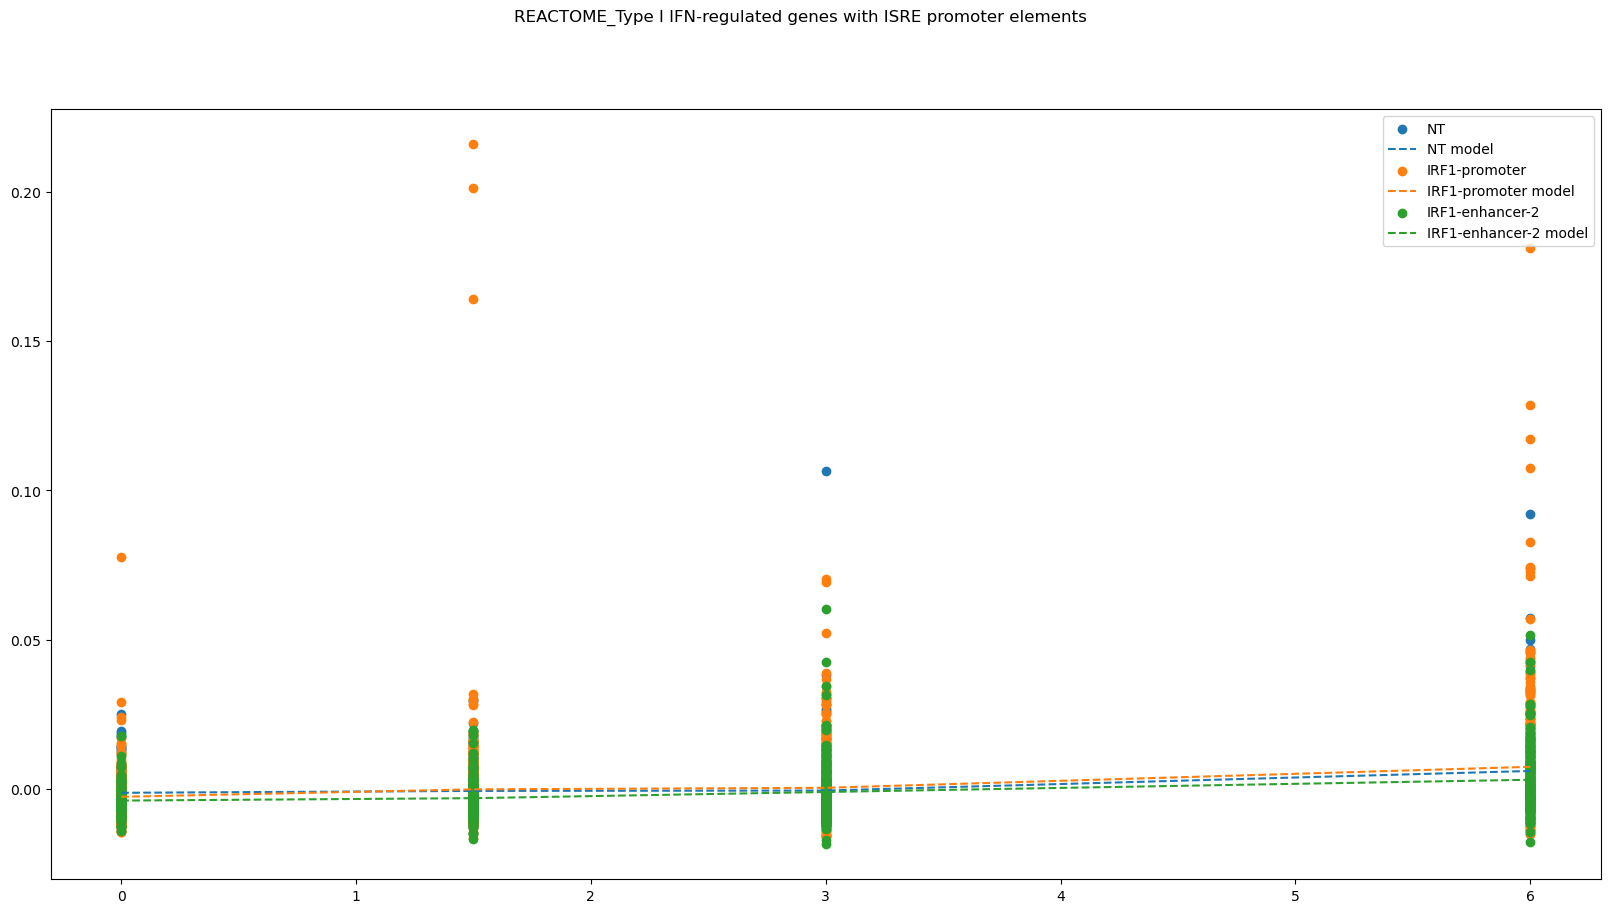

In [117]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(ncols=1)
fig.suptitle("REACTOME_Type I IFN-regulated genes with ISRE promoter elements")

adata_selected = adata[:, [ind for ind, g in enumerate(adata.var["features"]) 
                                    if g in genes["REACTOME_Type I IFN-regulated genes with ISRE promoter elements"]]]


group = ["NT", "IRF1-promoter", 'IRF1-enhancer-2'] #, 'IRF1-enhancer-M', 'IRF1-enhancer-3', 'IRF1-enhancer-4']

to_test = []
to_time = []


# svd
eigengenes, s, eigensamples = svd(adata_selected.layers["scvi_normalized"], full_matrices=False)
eigengenes_nc, s_nc, eigensamples_nc = svd(adata_selected_nc.layers["scvi_normalized"], full_matrices=False)


for g in zip(group):
    # Selecting perturbation
    cell_index = np.where(adata_selected.obs["NT"] == g[0])[0]
    cell_index_nc = np.where(adata_selected_nc.obs["NT"] == g[0])[0]
    # model fitting
    model4 = np.poly1d(np.polyfit(adata_selected[cell_index].obs["Time"], 
                                  eigengenes[cell_index, 0], 3))
    model4_nc = np.poly1d(np.polyfit(adata_selected_nc[cell_index_nc].obs["Time"], 
                                     eigengenes_nc[cell_index_nc, 0], 3))
    
    # plotting
    ax.scatter(adata_selected[cell_index].obs["Time"], eigengenes[cell_index,0], label=g[0])
    print(stats.describe(eigengenes[cell_index, 0]))
    to_time.append(adata_selected[cell_index].obs["Time"])
    to_test.append(eigengenes[cell_index,0])
    ax.plot(np.sort(adata_selected[cell_index].obs["Time"]), 
            model4(np.sort(adata_selected[cell_index].obs["Time"])), '--', label=g[0] + " model")
    
ax.legend()
plt.show()

3.0_NT vs. 3.0_IRF1-promoter: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.121e-02 U_stat=7.242e+04
6.0_NT vs. 6.0_IRF1-promoter: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.330e-01 U_stat=3.336e+04
0.0_NT vs. 0.0_IRF1-promoter: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.673e-02 U_stat=2.552e+04
1.5_NT vs. 1.5_IRF1-promoter: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.267e-01 U_stat=6.677e+04
3.0_NT vs. 3.0_IRF1-enhancer-2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.337e-01 U_stat=2.995e+04
6.0_NT vs. 6.0_IRF1-enhancer-2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.336e-01 U_stat=1.473e+04
1.5_NT vs. 1.5_IRF1-enhancer-2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.177e-04 U_stat=2.673e+04
0.0_NT vs. 0.0_IRF1-enhancer-2: Mann-Whitn

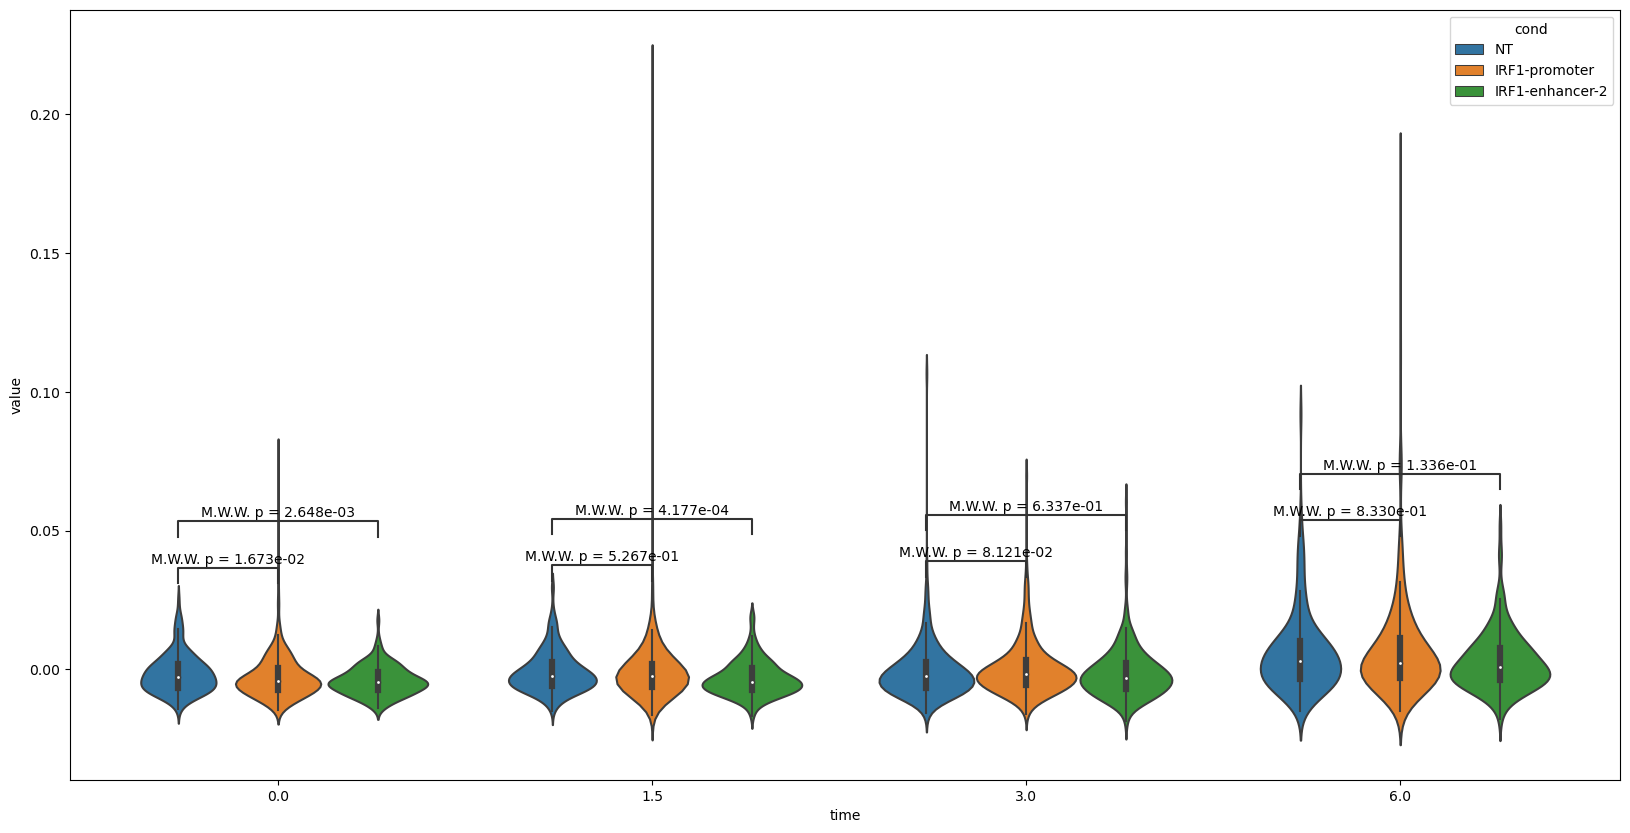

In [114]:
to_test_dict = {'cond':[], "value": [], "time":[]}
for cond in zip(group, to_test, to_time):
    to_test_dict["cond"].extend([cond[0]]*len(cond[1]))
    to_test_dict["value"].extend(cond[1])
    to_test_dict["time"].extend(cond[2])
    
    
box_pairs=[((0.0, "NT"), (0.0, "IRF1-promoter")), 
                                #((0.0, "NT"), (0.0, "IRF1-enhancer-M")), 
                                ((0.0, "NT"), (0.0, "IRF1-enhancer-2")), 
                               #((0.0, "NT"), (0.0, "IRF1-enhancer-3")), 
                                #((0.0, "NT"), (0.0, "IRF1-enhancer-4")),
                              ((1.5, "NT"), (1.5, "IRF1-promoter")), 
                                #((1.5, "NT"), (1.5, "IRF1-enhancer-M")), 
                                ((1.5, "NT"), (1.5, "IRF1-enhancer-2")), 
                               #((1.5, "NT"), (1.5, "IRF1-enhancer-3")), 
                                #((1.5, "NT"), (1.5, "IRF1-enhancer-4")),
                              ((3.0, "NT"), (3.0, "IRF1-promoter")), 
                                #((3.0, "NT"), (3.0, "IRF1-enhancer-M")), 
                                ((3.0, "NT"), (3.0, "IRF1-enhancer-2")), 
                               #((3.0, "NT"), (3.0, "IRF1-enhancer-3")), 
                                #((3.0, "NT"), (3.0, "IRF1-enhancer-4")),
                              ((6.0, "NT"), (6.0, "IRF1-promoter")), 
                                #((6.0, "NT"), (6.0, "IRF1-enhancer-M")), 
                                ((6.0, "NT"), (6.0, "IRF1-enhancer-2")), 
                               #((6.0, "NT"), (6.0, "IRF1-enhancer-3")), 
                                #((6.0, "NT"), (6.0, "IRF1-enhancer-4"))
          ]
to_test_dict = pd.DataFrame(to_test_dict)
ax = sns.violinplot(data=to_test_dict, hue="cond", x="time", y="value")
annotator = Annotator.Annotator(ax, box_pairs, data=to_test_dict, hue="cond", x="time", y="value")
annotator.configure(test='Mann-Whitney', text_format='full', loc='inside', comparisons_correction="fdr_bh")
annotator.apply_and_annotate()
plt.savefig("IFNA_IFNB_diff_test.png", dpi=300, bbox_inches='tight')

IRF1-enhancer-2_0.0 vs. IRF1-enhancer-2_1.5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.017e-01 U_stat=1.195e+04
NT_0.0 vs. NT_1.5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.956e-01 U_stat=1.666e+04
IRF1-promoter_0.0 vs. IRF1-promoter_1.5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.004e-04 U_stat=6.950e+04
NT_0.0 vs. NT_3.0: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.898e-01 U_stat=2.073e+04
IRF1-promoter_0.0 vs. IRF1-promoter_3.0: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.873e-07 U_stat=6.656e+04
IRF1-enhancer-2_0.0 vs. IRF1-enhancer-2_3.0: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.490e-03 U_stat=1.152e+04
IRF1-enhancer-2_0.0 vs. IRF1-enhancer-2_6.0: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.026e-11 U_stat=5.421e+03
NT_

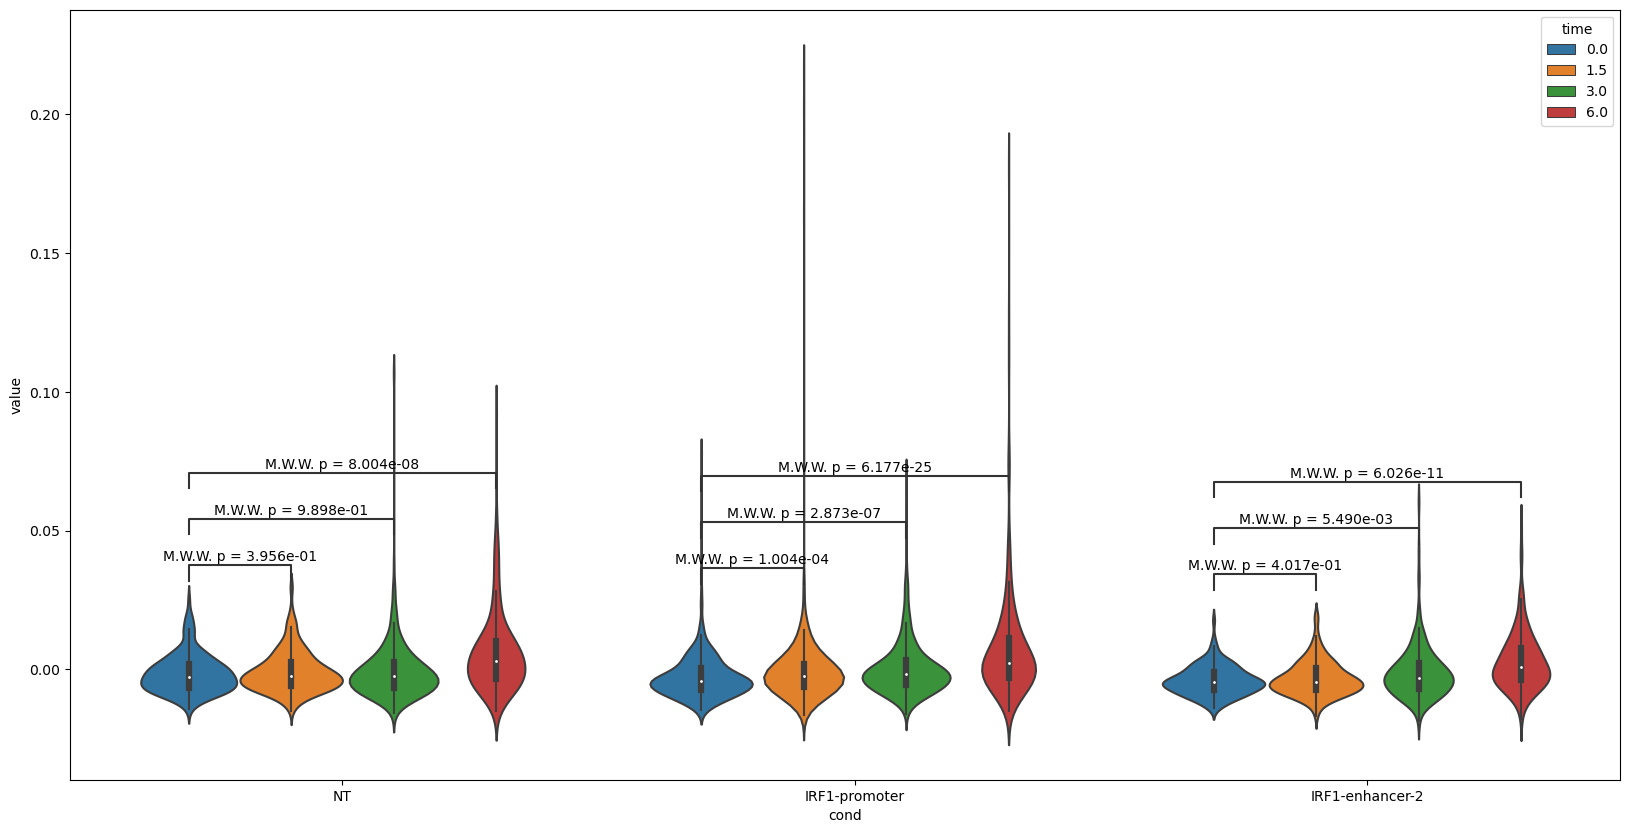

In [115]:
ax = sns.violinplot(data=to_test_dict, hue="time", x="cond", y="value")
box_pairs=[(("NT", 0.0), ("NT", 1.5)), 
           (("NT", 0.0), ("NT", 3.0)), 
           (("NT", 0.0), ("NT", 6.0)),
           (("IRF1-promoter", 0.0), ("IRF1-promoter", 1.5)),
           (("IRF1-promoter", 0.0), ("IRF1-promoter", 3.0)),
           (("IRF1-promoter", 0.0),("IRF1-promoter", 6.0)),
           #(("IRF1-enhancer-M", 0.0), ("IRF1-enhancer-M", 1.5)),
           #(("IRF1-enhancer-M", 0.0), ("IRF1-enhancer-M", 3.0)),
           #(("IRF1-enhancer-M", 0.0), ("IRF1-enhancer-M", 6.0)),
           (("IRF1-enhancer-2", 0.0), ("IRF1-enhancer-2", 1.5)),
           (("IRF1-enhancer-2", 0.0), ("IRF1-enhancer-2", 3.0)),
           (("IRF1-enhancer-2", 0.0), ("IRF1-enhancer-2", 6.0)),
           #(("IRF1-enhancer-3", 0.0), ("IRF1-enhancer-3", 1.5)),
           #(("IRF1-enhancer-3", 0.0), ("IRF1-enhancer-3", 3.0)),
           #(("IRF1-enhancer-3", 0.0), ("IRF1-enhancer-3", 6.0)),
           #(("IRF1-enhancer-4", 0.0), ("IRF1-enhancer-4", 1.5)),
           #(("IRF1-enhancer-4", 0.0), ("IRF1-enhancer-4", 3.0)),
           #(("IRF1-enhancer-4", 0.0), ("IRF1-enhancer-4", 6.0))
          ]
annotator = Annotator.Annotator(ax, box_pairs, data=to_test_dict, hue="time", x="cond", y="value")
annotator.configure(test='Mann-Whitney', text_format='full', loc='inside', comparisons_correction="fdr_bh")
annotator.apply_and_annotate()
plt.savefig("IFNA_IFNB_diff_test_effect.png", dpi=300, bbox_inches='tight')